In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

start_time = time.time()

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
print (tf.__version__)

2.6.0


### Define PINN neural network

In [4]:
def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(1))
    
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    
    model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))
    
    return model

In [5]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, model):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = model
        
        self.iter = 0
        self.loss_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1, loss_2, loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)

        return loss, g
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()

### Generate training data

In [6]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 5000                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([60000.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [7]:
N = 30000

### Train PINN without PCGrad

In [8]:
PINN_solver = PINN(x_u, y_u, x_r, init_model())
initial_weights = PINN_solver.model.get_weights()

In [9]:
optim = tf.keras.optimizers.Adam(epsilon=1e-08)
PINN_solver.train(N=N*2, optimizer=optim, method = 'original')

Iteration 00000: loss = 0.3108814,2.009435e-09,3.0407413e-10,3.0394391e-09
Iteration 00005: loss = 0.1549211,1.8324492e-09,9.967111e-11,2.766052e-09
Iteration 00010: loss = 0.054250892,2.152137e-09,2.6858224e-10,2.614525e-09
Iteration 00015: loss = 0.016276916,2.7465237e-09,5.915088e-10,2.566031e-09
Iteration 00020: loss = 0.0055662873,3.310693e-09,8.6496993e-10,2.5682827e-09
Iteration 00025: loss = 0.0024359932,3.7296455e-09,1.0475523e-09,2.5820361e-09
Iteration 00030: loss = 0.0013419633,4.0167563e-09,1.1616735e-09,2.593796e-09
Iteration 00035: loss = 0.0008823997,4.2101407e-09,1.2323235e-09,2.601433e-09
Iteration 00040: loss = 0.0006581627,4.341262e-09,1.2764176e-09,2.6057334e-09
Iteration 00045: loss = 0.0005352322,4.4318433e-09,1.304356e-09,2.6078026e-09
Iteration 00050: loss = 0.0004612557,4.4961967e-09,1.3224276e-09,2.6084965e-09
Iteration 00055: loss = 0.00041304846,4.5436264e-09,1.3344506e-09,2.6083824e-09
Iteration 00060: loss = 0.00037928508,4.580152e-09,1.3427573e-09,2.6078

Iteration 00530: loss = 3.0129782e-05,5.5870673e-09,1.5249129e-09,2.610768e-09
Iteration 00535: loss = 2.9653369e-05,5.592859e-09,1.526087e-09,2.6111044e-09
Iteration 00540: loss = 2.9187375e-05,5.5986025e-09,1.5272515e-09,2.6114408e-09
Iteration 00545: loss = 2.8732473e-05,5.6042992e-09,1.528407e-09,2.6117775e-09
Iteration 00550: loss = 2.8286695e-05,5.6099494e-09,1.529554e-09,2.6121143e-09
Iteration 00555: loss = 2.78519e-05,5.615554e-09,1.5306925e-09,2.6124505e-09
Iteration 00560: loss = 2.7426948e-05,5.6211125e-09,1.5318222e-09,2.6127867e-09
Iteration 00565: loss = 2.701083e-05,5.626629e-09,1.5329439e-09,2.6131233e-09
Iteration 00570: loss = 2.6604534e-05,5.632099e-09,1.5340568e-09,2.6134594e-09
Iteration 00575: loss = 2.6206379e-05,5.637527e-09,1.5351616e-09,2.6137954e-09
Iteration 00580: loss = 2.5817104e-05,5.6429137e-09,1.536258e-09,2.6141318e-09
Iteration 00585: loss = 2.5436535e-05,5.648257e-09,1.5373469e-09,2.6144666e-09
Iteration 00590: loss = 2.506336e-05,5.6535607e-09,1.5

Iteration 01060: loss = 8.548389e-06,6.02729e-09,1.615289e-09,2.6437919e-09
Iteration 01065: loss = 8.470852e-06,6.0303496e-09,1.6159203e-09,2.6440692e-09
Iteration 01070: loss = 8.394683e-06,6.0333987e-09,1.6165497e-09,2.644346e-09
Iteration 01075: loss = 8.319239e-06,6.036434e-09,1.6171758e-09,2.6446219e-09
Iteration 01080: loss = 8.244516e-06,6.0394543e-09,1.617799e-09,2.6448965e-09
Iteration 01085: loss = 8.170804e-06,6.042465e-09,1.61842e-09,2.6451707e-09
Iteration 01090: loss = 8.098109e-06,6.0454606e-09,1.6190377e-09,2.645445e-09
Iteration 01095: loss = 8.026415e-06,6.0484426e-09,1.6196529e-09,2.6457183e-09
Iteration 01100: loss = 7.955705e-06,6.0514136e-09,1.6202656e-09,2.6459912e-09
Iteration 01105: loss = 7.885669e-06,6.054371e-09,1.6208757e-09,2.6462632e-09
Iteration 01110: loss = 7.816586e-06,6.057316e-09,1.6214828e-09,2.6465352e-09
Iteration 01115: loss = 7.748627e-06,6.0602483e-09,1.6220876e-09,2.6468057e-09
Iteration 01120: loss = 7.681142e-06,6.063168e-09,1.6226902e-09,

Iteration 01590: loss = 3.791002e-06,6.2947225e-09,1.670273e-09,2.6700744e-09
Iteration 01595: loss = 3.7662342e-06,6.296826e-09,1.6707028e-09,2.6702967e-09
Iteration 01600: loss = 3.7418083e-06,6.2989245e-09,1.6711321e-09,2.670519e-09
Iteration 01605: loss = 3.7175103e-06,6.301015e-09,1.6715594e-09,2.6707407e-09
Iteration 01610: loss = 3.6934473e-06,6.3031003e-09,1.6719856e-09,2.670961e-09
Iteration 01615: loss = 3.6696147e-06,6.3051826e-09,1.6724109e-09,2.671182e-09
Iteration 01620: loss = 3.6459007e-06,6.3072556e-09,1.6728349e-09,2.6714027e-09
Iteration 01625: loss = 3.6225276e-06,6.3093246e-09,1.6732574e-09,2.671623e-09
Iteration 01630: loss = 3.5993783e-06,6.311387e-09,1.6736789e-09,2.6718425e-09
Iteration 01635: loss = 3.576238e-06,6.3134435e-09,1.6740991e-09,2.6720617e-09
Iteration 01640: loss = 3.5534301e-06,6.315495e-09,1.674518e-09,2.672281e-09
Iteration 01645: loss = 3.5307373e-06,6.3175394e-09,1.674936e-09,2.6724993e-09
Iteration 01650: loss = 3.5085807e-06,6.3195817e-09,1.

Iteration 02120: loss = 2.0428395e-06,6.490403e-09,1.7100312e-09,2.6917202e-09
Iteration 02125: loss = 2.0322077e-06,6.4920322e-09,1.7103601e-09,2.6919078e-09
Iteration 02130: loss = 2.0214582e-06,6.49366e-09,1.7106884e-09,2.6920963e-09
Iteration 02135: loss = 2.0109906e-06,6.4952843e-09,1.711016e-09,2.692284e-09
Iteration 02140: loss = 2.0006464e-06,6.496907e-09,1.7113427e-09,2.6924714e-09
Iteration 02145: loss = 1.990029e-06,6.4985244e-09,1.7116688e-09,2.6926583e-09
Iteration 02150: loss = 1.9798465e-06,6.5001373e-09,1.7119942e-09,2.6928453e-09
Iteration 02155: loss = 1.9696288e-06,6.5017494e-09,1.7123187e-09,2.6930314e-09
Iteration 02160: loss = 1.9594488e-06,6.503359e-09,1.7126431e-09,2.6932183e-09
Iteration 02165: loss = 1.9495467e-06,6.504963e-09,1.7129665e-09,2.6934044e-09
Iteration 02170: loss = 1.939451e-06,6.506565e-09,1.7132891e-09,2.693591e-09
Iteration 02175: loss = 1.929395e-06,6.508163e-09,1.7136114e-09,2.6937768e-09
Iteration 02180: loss = 1.919455e-06,6.50976e-09,1.713

Iteration 02640: loss = 1.236038e-06,6.6449544e-09,1.7409854e-09,2.7100897e-09
Iteration 02645: loss = 1.2305693e-06,6.6463146e-09,1.7412558e-09,2.7102562e-09
Iteration 02650: loss = 1.2249938e-06,6.647672e-09,1.7415254e-09,2.7104223e-09
Iteration 02655: loss = 1.2195619e-06,6.649027e-09,1.7417949e-09,2.7105875e-09
Iteration 02660: loss = 1.2141484e-06,6.6503825e-09,1.7420639e-09,2.7107538e-09
Iteration 02665: loss = 1.2088165e-06,6.6517343e-09,1.7423325e-09,2.7109195e-09
Iteration 02670: loss = 1.203439e-06,6.6530834e-09,1.742601e-09,2.7110851e-09
Iteration 02675: loss = 1.1979577e-06,6.6544317e-09,1.7428683e-09,2.71125e-09
Iteration 02680: loss = 1.1927409e-06,6.655779e-09,1.7431357e-09,2.7114155e-09
Iteration 02685: loss = 1.1874196e-06,6.6571206e-09,1.7434024e-09,2.7115803e-09
Iteration 02690: loss = 1.1822372e-06,6.6584622e-09,1.7436687e-09,2.711745e-09
Iteration 02695: loss = 1.1770109e-06,6.6598025e-09,1.7439347e-09,2.7119094e-09
Iteration 02700: loss = 1.1718654e-06,6.6611414e-

Iteration 03170: loss = 7.9113187e-07,6.7791284e-09,1.7674571e-09,2.7268734e-09
Iteration 03175: loss = 7.8798377e-07,6.78031e-09,1.7676887e-09,2.7270242e-09
Iteration 03180: loss = 7.847466e-07,6.7814887e-09,1.7679195e-09,2.7271752e-09
Iteration 03185: loss = 7.817157e-07,6.7826664e-09,1.7681501e-09,2.7273255e-09
Iteration 03190: loss = 7.785956e-07,6.7838477e-09,1.7683809e-09,2.7274765e-09
Iteration 03195: loss = 7.754848e-07,6.785024e-09,1.7686103e-09,2.7276272e-09
Iteration 03200: loss = 7.72482e-07,6.7861983e-09,1.7688402e-09,2.7277782e-09
Iteration 03205: loss = 7.6938863e-07,6.787371e-09,1.7690698e-09,2.7279283e-09
Iteration 03210: loss = 7.664039e-07,6.788544e-09,1.7692989e-09,2.7280787e-09
Iteration 03215: loss = 7.633294e-07,6.7897163e-09,1.7695282e-09,2.7282288e-09
Iteration 03220: loss = 7.6041056e-07,6.7908856e-09,1.769757e-09,2.7283786e-09
Iteration 03225: loss = 7.573546e-07,6.792055e-09,1.7699855e-09,2.728529e-09
Iteration 03230: loss = 7.544047e-07,6.793222e-09,1.77021

Iteration 03695: loss = 5.311562e-07,6.8965775e-09,1.7902737e-09,2.74216e-09
Iteration 03700: loss = 5.292011e-07,6.89764e-09,1.7904785e-09,2.7423008e-09
Iteration 03705: loss = 5.272523e-07,6.8986976e-09,1.7906828e-09,2.742441e-09
Iteration 03710: loss = 5.253901e-07,6.899757e-09,1.7908869e-09,2.7425813e-09
Iteration 03715: loss = 5.2345064e-07,6.900815e-09,1.7910906e-09,2.7427225e-09
Iteration 03720: loss = 5.215577e-07,6.901873e-09,1.7912942e-09,2.7428617e-09
Iteration 03725: loss = 5.1970966e-07,6.9029302e-09,1.7914977e-09,2.743002e-09
Iteration 03730: loss = 5.178668e-07,6.9039867e-09,1.7917008e-09,2.743142e-09
Iteration 03735: loss = 5.1594805e-07,6.9050388e-09,1.7919034e-09,2.7432818e-09
Iteration 03740: loss = 5.140348e-07,6.906093e-09,1.7921064e-09,2.7434217e-09
Iteration 03745: loss = 5.122868e-07,6.907145e-09,1.7923089e-09,2.7435616e-09
Iteration 03750: loss = 5.103841e-07,6.9081993e-09,1.7925109e-09,2.743701e-09
Iteration 03755: loss = 5.085654e-07,6.9092487e-09,1.792713e-0

Iteration 04225: loss = 3.663415e-07,7.0041977e-09,1.8108464e-09,2.7566216e-09
Iteration 04230: loss = 3.6511082e-07,7.005171e-09,1.811031e-09,2.7567544e-09
Iteration 04235: loss = 3.638834e-07,7.006144e-09,1.8112151e-09,2.7568865e-09
Iteration 04240: loss = 3.6259118e-07,7.0071144e-09,1.8113993e-09,2.7570193e-09
Iteration 04245: loss = 3.614372e-07,7.0080866e-09,1.8115835e-09,2.7571514e-09
Iteration 04250: loss = 3.6021865e-07,7.009055e-09,1.8117667e-09,2.7572842e-09
Iteration 04255: loss = 3.5893595e-07,7.0100263e-09,1.8119505e-09,2.7574165e-09
Iteration 04260: loss = 3.5772334e-07,7.0109962e-09,1.812134e-09,2.7575486e-09
Iteration 04265: loss = 3.5658073e-07,7.011965e-09,1.812317e-09,2.757681e-09
Iteration 04270: loss = 3.5537383e-07,7.0129316e-09,1.8125004e-09,2.7578133e-09
Iteration 04275: loss = 3.5417023e-07,7.0138975e-09,1.8126831e-09,2.7579452e-09
Iteration 04280: loss = 3.529694e-07,7.014863e-09,1.8128662e-09,2.7580773e-09
Iteration 04285: loss = 3.5177155e-07,7.0158306e-09,1

Iteration 04755: loss = 2.5837377e-07,7.1037465e-09,1.8295595e-09,2.7703606e-09
Iteration 04760: loss = 2.5758277e-07,7.1046555e-09,1.8297284e-09,2.7704874e-09
Iteration 04765: loss = 2.5673685e-07,7.1055632e-09,1.8298976e-09,2.7706144e-09
Iteration 04770: loss = 2.5589273e-07,7.1064687e-09,1.8300663e-09,2.770741e-09
Iteration 04775: loss = 2.5510735e-07,7.1073716e-09,1.8302347e-09,2.770867e-09
Iteration 04780: loss = 2.5429537e-07,7.1082797e-09,1.8304036e-09,2.7709939e-09
Iteration 04785: loss = 2.535136e-07,7.1091852e-09,1.8305718e-09,2.771121e-09
Iteration 04790: loss = 2.526772e-07,7.110089e-09,1.8307404e-09,2.7712475e-09
Iteration 04795: loss = 2.5184264e-07,7.110992e-09,1.8309085e-09,2.7713734e-09
Iteration 04800: loss = 2.5106633e-07,7.1118977e-09,1.8310767e-09,2.7715001e-09
Iteration 04805: loss = 2.5029172e-07,7.112797e-09,1.8312447e-09,2.7716265e-09
Iteration 04810: loss = 2.4946277e-07,7.1137025e-09,1.8314124e-09,2.7717528e-09
Iteration 04815: loss = 2.4869152e-07,7.114603e-

Iteration 05275: loss = 1.8649017e-07,7.1954602e-09,1.8464954e-09,2.7832998e-09
Iteration 05280: loss = 1.8591066e-07,7.1963164e-09,1.8466524e-09,2.7834224e-09
Iteration 05285: loss = 1.8533218e-07,7.1971744e-09,1.8468094e-09,2.783545e-09
Iteration 05290: loss = 1.8475504e-07,7.1980297e-09,1.8469661e-09,2.7836666e-09
Iteration 05295: loss = 1.841792e-07,7.1988864e-09,1.8471226e-09,2.7837894e-09
Iteration 05300: loss = 1.8365284e-07,7.1997444e-09,1.8472791e-09,2.7839109e-09
Iteration 05305: loss = 1.8303143e-07,7.2005997e-09,1.8474355e-09,2.7840332e-09
Iteration 05310: loss = 1.8250728e-07,7.2014545e-09,1.8475917e-09,2.7841554e-09
Iteration 05315: loss = 1.8198432e-07,7.20231e-09,1.847748e-09,2.7842773e-09
Iteration 05320: loss = 1.8136684e-07,7.203164e-09,1.847904e-09,2.7843994e-09
Iteration 05325: loss = 1.8084602e-07,7.204016e-09,1.8480603e-09,2.784521e-09
Iteration 05330: loss = 1.80279e-07,7.2048714e-09,1.8482158e-09,2.7846432e-09
Iteration 05335: loss = 1.7971298e-07,7.2057245e-09

Iteration 05795: loss = 1.3619665e-07,7.2825403e-09,1.8622808e-09,2.7958174e-09
Iteration 05800: loss = 1.3581273e-07,7.283359e-09,1.8624275e-09,2.795936e-09
Iteration 05805: loss = 1.3542946e-07,7.2841737e-09,1.8625742e-09,2.7960547e-09
Iteration 05810: loss = 1.350059e-07,7.284992e-09,1.8627209e-09,2.7961728e-09
Iteration 05815: loss = 1.3460362e-07,7.285808e-09,1.8628674e-09,2.7962912e-09
Iteration 05820: loss = 1.3422289e-07,7.2866255e-09,1.8630137e-09,2.7964098e-09
Iteration 05825: loss = 1.3380192e-07,7.2874404e-09,1.86316e-09,2.7965281e-09
Iteration 05830: loss = 1.3346379e-07,7.288257e-09,1.863306e-09,2.7966465e-09
Iteration 05835: loss = 1.330444e-07,7.289074e-09,1.8634525e-09,2.7967648e-09
Iteration 05840: loss = 1.3262587e-07,7.289887e-09,1.8635984e-09,2.7968832e-09
Iteration 05845: loss = 1.3224914e-07,7.290703e-09,1.863744e-09,2.7970013e-09
Iteration 05850: loss = 1.3183251e-07,7.2915185e-09,1.86389e-09,2.7971192e-09
Iteration 05855: loss = 1.3149781e-07,7.292332e-09,1.864

Iteration 06315: loss = 1.0047631e-07,7.3658697e-09,1.8770774e-09,2.8079772e-09
Iteration 06320: loss = 1.001658e-07,7.3666553e-09,1.8772153e-09,2.8080922e-09
Iteration 06325: loss = 9.989119e-08,7.3674413e-09,1.877353e-09,2.8082074e-09
Iteration 06330: loss = 9.9617274e-08,7.3682243e-09,1.8774904e-09,2.808323e-09
Iteration 06335: loss = 9.930858e-08,7.36901e-09,1.877628e-09,2.8084377e-09
Iteration 06340: loss = 9.9035816e-08,7.3697928e-09,1.8777653e-09,2.8085527e-09
Iteration 06345: loss = 9.8763564e-08,7.370577e-09,1.8779025e-09,2.808668e-09
Iteration 06350: loss = 9.845667e-08,7.3713613e-09,1.8780397e-09,2.8087828e-09
Iteration 06355: loss = 9.818561e-08,7.3721456e-09,1.878177e-09,2.808898e-09
Iteration 06360: loss = 9.7914885e-08,7.3729263e-09,1.878314e-09,2.809013e-09
Iteration 06365: loss = 9.7609835e-08,7.373711e-09,1.8784512e-09,2.809128e-09
Iteration 06370: loss = 9.7340376e-08,7.37449e-09,1.8785882e-09,2.8092426e-09
Iteration 06375: loss = 9.703652e-08,7.375273e-09,1.878725e-

Iteration 06840: loss = 7.4479125e-08,7.4468387e-09,1.8911217e-09,2.8199276e-09
Iteration 06845: loss = 7.428624e-08,7.4475954e-09,1.8912514e-09,2.82004e-09
Iteration 06850: loss = 7.406326e-08,7.448352e-09,1.8913808e-09,2.8201523e-09
Iteration 06855: loss = 7.384049e-08,7.4491093e-09,1.8915105e-09,2.820265e-09
Iteration 06860: loss = 7.3648884e-08,7.449867e-09,1.8916397e-09,2.8203768e-09
Iteration 06865: loss = 7.342713e-08,7.450624e-09,1.891769e-09,2.820489e-09
Iteration 06870: loss = 7.323616e-08,7.451379e-09,1.8918984e-09,2.8206015e-09
Iteration 06875: loss = 7.301524e-08,7.452136e-09,1.892028e-09,2.8207137e-09
Iteration 06880: loss = 7.2824996e-08,7.452892e-09,1.892157e-09,2.8208258e-09
Iteration 06885: loss = 7.260491e-08,7.453647e-09,1.8922863e-09,2.8209381e-09
Iteration 06890: loss = 7.2415574e-08,7.454402e-09,1.892415e-09,2.8210503e-09
Iteration 06895: loss = 7.219628e-08,7.455158e-09,1.892544e-09,2.8211622e-09
Iteration 06900: loss = 7.2007595e-08,7.455912e-09,1.8926731e-09,2

Iteration 07370: loss = 5.5381708e-08,7.525821e-09,1.9044568e-09,2.8316782e-09
Iteration 07375: loss = 5.5251153e-08,7.526554e-09,1.904579e-09,2.8317877e-09
Iteration 07380: loss = 5.509453e-08,7.527286e-09,1.9047006e-09,2.8318976e-09
Iteration 07385: loss = 5.4911908e-08,7.528021e-09,1.9048223e-09,2.8320069e-09
Iteration 07390: loss = 5.4755873e-08,7.528754e-09,1.904944e-09,2.832116e-09
Iteration 07395: loss = 5.462638e-08,7.529485e-09,1.9050659e-09,2.8322253e-09
Iteration 07400: loss = 5.4470917e-08,7.530218e-09,1.9051876e-09,2.8323346e-09
Iteration 07405: loss = 5.4315766e-08,7.530948e-09,1.905309e-09,2.8324436e-09
Iteration 07410: loss = 5.418704e-08,7.531679e-09,1.9054303e-09,2.8325526e-09
Iteration 07415: loss = 5.4032444e-08,7.53241e-09,1.9055517e-09,2.832662e-09
Iteration 07420: loss = 5.3878093e-08,7.533143e-09,1.9056732e-09,2.832771e-09
Iteration 07425: loss = 5.372412e-08,7.533874e-09,1.9057944e-09,2.8328804e-09
Iteration 07430: loss = 5.3570414e-08,7.534605e-09,1.9059159e-0

Iteration 07900: loss = 4.1420805e-08,7.602364e-09,1.916982e-09,2.843112e-09
Iteration 07905: loss = 4.1314568e-08,7.603077e-09,1.9170967e-09,2.8432179e-09
Iteration 07910: loss = 4.1185785e-08,7.603788e-09,1.9172106e-09,2.8433245e-09
Iteration 07915: loss = 4.107996e-08,7.604498e-09,1.9173247e-09,2.8434302e-09
Iteration 07920: loss = 4.099705e-08,7.60521e-09,1.9174387e-09,2.8435367e-09
Iteration 07925: loss = 4.0868915e-08,7.605919e-09,1.9175523e-09,2.8436424e-09
Iteration 07930: loss = 4.0763652e-08,7.606629e-09,1.9176662e-09,2.8437483e-09
Iteration 07935: loss = 4.0635957e-08,7.6073405e-09,1.9177802e-09,2.8438536e-09
Iteration 07940: loss = 4.053113e-08,7.60805e-09,1.917894e-09,2.8439602e-09
Iteration 07945: loss = 4.0403975e-08,7.60876e-09,1.9180075e-09,2.8440663e-09
Iteration 07950: loss = 4.0322096e-08,7.6094695e-09,1.9181208e-09,2.844172e-09
Iteration 07955: loss = 4.0217852e-08,7.610179e-09,1.9182345e-09,2.8442781e-09
Iteration 07960: loss = 4.0091283e-08,7.610887e-09,1.9183481

Iteration 08430: loss = 3.1118628e-08,7.676693e-09,1.92869e-09,2.854194e-09
Iteration 08435: loss = 3.105112e-08,7.677385e-09,1.9287967e-09,2.8542968e-09
Iteration 08440: loss = 3.0944236e-08,7.678075e-09,1.928903e-09,2.8543996e-09
Iteration 08445: loss = 3.0857276e-08,7.678765e-09,1.9290087e-09,2.854502e-09
Iteration 08450: loss = 3.079016e-08,7.679456e-09,1.9291153e-09,2.854604e-09
Iteration 08455: loss = 3.0703507e-08,7.680148e-09,1.9292214e-09,2.8547071e-09
Iteration 08460: loss = 3.0617016e-08,7.680837e-09,1.9293276e-09,2.8548095e-09
Iteration 08465: loss = 3.0530686e-08,7.681528e-09,1.9294335e-09,2.8549123e-09
Iteration 08470: loss = 3.0464097e-08,7.6822175e-09,1.9295392e-09,2.855015e-09
Iteration 08475: loss = 3.0378043e-08,7.682905e-09,1.9296453e-09,2.855117e-09
Iteration 08480: loss = 3.029216e-08,7.683595e-09,1.929751e-09,2.8552196e-09
Iteration 08485: loss = 3.0206472e-08,7.684284e-09,1.9298565e-09,2.855322e-09
Iteration 08490: loss = 3.014037e-08,7.684974e-09,1.9299617e-09,

Iteration 08970: loss = 2.3339647e-08,7.750264e-09,1.9397237e-09,2.8650577e-09
Iteration 08975: loss = 2.3284713e-08,7.750933e-09,1.9398216e-09,2.865156e-09
Iteration 08980: loss = 2.3212799e-08,7.7516065e-09,1.9399191e-09,2.8652543e-09
Iteration 08985: loss = 2.3158043e-08,7.752277e-09,1.9400166e-09,2.8653524e-09
Iteration 08990: loss = 2.3103416e-08,7.752948e-09,1.940114e-09,2.8654503e-09
Iteration 08995: loss = 2.303183e-08,7.753618e-09,1.9402113e-09,2.865549e-09
Iteration 09000: loss = 2.2977448e-08,7.75429e-09,1.940309e-09,2.8656468e-09
Iteration 09005: loss = 2.2923132e-08,7.754958e-09,1.940406e-09,2.865745e-09
Iteration 09010: loss = 2.2851893e-08,7.755628e-09,1.940503e-09,2.8658431e-09
Iteration 09015: loss = 2.2797787e-08,7.756298e-09,1.9406001e-09,2.8659408e-09
Iteration 09020: loss = 2.2743764e-08,7.756966e-09,1.940697e-09,2.8660385e-09
Iteration 09025: loss = 2.2689813e-08,7.757636e-09,1.940794e-09,2.8661369e-09
Iteration 09030: loss = 2.26191e-08,7.758306e-09,1.9408906e-09

Iteration 09510: loss = 1.7594955e-08,7.821699e-09,1.9497703e-09,2.8753993e-09
Iteration 09515: loss = 1.754983e-08,7.822349e-09,1.9498585e-09,2.8754923e-09
Iteration 09520: loss = 1.7489961e-08,7.823002e-09,1.9499464e-09,2.8755855e-09
Iteration 09525: loss = 1.7445034e-08,7.823653e-09,1.9500341e-09,2.8756784e-09
Iteration 09530: loss = 1.7400195e-08,7.824303e-09,1.950122e-09,2.8757714e-09
Iteration 09535: loss = 1.735541e-08,7.824954e-09,1.9502098e-09,2.8758642e-09
Iteration 09540: loss = 1.731073e-08,7.825604e-09,1.9502975e-09,2.8759568e-09
Iteration 09545: loss = 1.7266116e-08,7.826256e-09,1.950385e-09,2.8760494e-09
Iteration 09550: loss = 1.722157e-08,7.8269045e-09,1.950473e-09,2.8761422e-09
Iteration 09555: loss = 1.7191809e-08,7.827555e-09,1.9505602e-09,2.8762344e-09
Iteration 09560: loss = 1.7132717e-08,7.828204e-09,1.9506474e-09,2.8763276e-09
Iteration 09565: loss = 1.7088423e-08,7.828854e-09,1.9507345e-09,2.8764195e-09
Iteration 09570: loss = 1.7044187e-08,7.8295015e-09,1.9508

Iteration 10050: loss = 1.3296116e-08,7.890965e-09,1.9587507e-09,2.8851292e-09
Iteration 10055: loss = 1.3258803e-08,7.891597e-09,1.9588287e-09,2.8852154e-09
Iteration 10060: loss = 1.3234447e-08,7.892228e-09,1.958906e-09,2.8853022e-09
Iteration 10065: loss = 1.3210136e-08,7.892859e-09,1.9589836e-09,2.8853886e-09
Iteration 10070: loss = 1.3172991e-08,7.8934885e-09,1.9590602e-09,2.885475e-09
Iteration 10075: loss = 1.3135897e-08,7.894118e-09,1.9591375e-09,2.8855616e-09
Iteration 10080: loss = 1.3098883e-08,7.894749e-09,1.959215e-09,2.885648e-09
Iteration 10085: loss = 1.3061947e-08,7.8953795e-09,1.9592918e-09,2.8857343e-09
Iteration 10090: loss = 1.303787e-08,7.896007e-09,1.9593687e-09,2.8858205e-09
Iteration 10095: loss = 1.3001064e-08,7.896637e-09,1.9594455e-09,2.885907e-09
Iteration 10100: loss = 1.2964294e-08,7.897267e-09,1.9595223e-09,2.8859934e-09
Iteration 10105: loss = 1.2927589e-08,7.897897e-09,1.9595987e-09,2.8860792e-09
Iteration 10110: loss = 1.2903701e-08,7.898524e-09,1.959

Iteration 10590: loss = 1.010102e-08,7.957944e-09,1.966492e-09,2.894083e-09
Iteration 10595: loss = 1.0069918e-08,7.958551e-09,1.9665574e-09,2.894162e-09
Iteration 10600: loss = 1.00388595e-08,7.9591596e-09,1.9666229e-09,2.8942406e-09
Iteration 10605: loss = 1.00190825e-08,7.959768e-09,1.9666881e-09,2.8943192e-09
Iteration 10610: loss = 9.988123e-09,7.960377e-09,1.966753e-09,2.894398e-09
Iteration 10615: loss = 9.957238e-09,7.960985e-09,1.9668178e-09,2.8944764e-09
Iteration 10620: loss = 9.948761e-09,7.961591e-09,1.9668829e-09,2.8945548e-09
Iteration 10625: loss = 9.917947e-09,7.9622e-09,1.966947e-09,2.8946323e-09
Iteration 10630: loss = 9.887193e-09,7.962806e-09,1.9670117e-09,2.8947111e-09
Iteration 10635: loss = 9.86764e-09,7.963414e-09,1.9670758e-09,2.8947895e-09
Iteration 10640: loss = 9.836994e-09,7.964019e-09,1.96714e-09,2.8948668e-09
Iteration 10645: loss = 9.817523e-09,7.964626e-09,1.9672044e-09,2.8949452e-09
Iteration 10650: loss = 9.798083e-09,7.965234e-09,1.967268e-09,2.8950

Iteration 11135: loss = 7.673306e-09,8.022981e-09,1.9728323e-09,2.9021314e-09
Iteration 11140: loss = 7.647239e-09,8.023564e-09,1.9728827e-09,2.9021998e-09
Iteration 11145: loss = 7.631016e-09,8.024148e-09,1.9729325e-09,2.9022678e-09
Iteration 11150: loss = 7.614844e-09,8.024732e-09,1.9729829e-09,2.9023361e-09
Iteration 11155: loss = 7.588906e-09,8.0253155e-09,1.9730326e-09,2.902404e-09
Iteration 11160: loss = 7.572781e-09,8.025898e-09,1.973082e-09,2.9024723e-09
Iteration 11165: loss = 7.55669e-09,8.026483e-09,1.9731317e-09,2.9025395e-09
Iteration 11170: loss = 7.540613e-09,8.027065e-09,1.9731814e-09,2.9026077e-09
Iteration 11175: loss = 7.514846e-09,8.027645e-09,1.9732305e-09,2.9026757e-09
Iteration 11180: loss = 7.508541e-09,8.028229e-09,1.9732798e-09,2.902743e-09
Iteration 11185: loss = 7.482838e-09,8.028808e-09,1.9733284e-09,2.90281e-09
Iteration 11190: loss = 7.457192e-09,8.0293905e-09,1.9733772e-09,2.902878e-09
Iteration 11195: loss = 7.441279e-09,8.029973e-09,1.9734256e-09,2.902

Iteration 11675: loss = 5.8710636e-09,8.084575e-09,1.9773725e-09,2.908869e-09
Iteration 11680: loss = 5.8490595e-09,8.08513e-09,1.9774054e-09,2.9089249e-09
Iteration 11685: loss = 5.8442318e-09,8.085687e-09,1.9774382e-09,2.9089808e-09
Iteration 11690: loss = 5.82229e-09,8.086242e-09,1.9774709e-09,2.9090361e-09
Iteration 11695: loss = 5.8089307e-09,8.086797e-09,1.9775037e-09,2.9090916e-09
Iteration 11700: loss = 5.795607e-09,8.087351e-09,1.9775357e-09,2.9091471e-09
Iteration 11705: loss = 5.7823026e-09,8.0879055e-09,1.977568e-09,2.909202e-09
Iteration 11710: loss = 5.769015e-09,8.088458e-09,1.9776e-09,2.9092568e-09
Iteration 11715: loss = 5.7557483e-09,8.089012e-09,1.9776323e-09,2.9093121e-09
Iteration 11720: loss = 5.73402e-09,8.089568e-09,1.9776638e-09,2.909367e-09
Iteration 11725: loss = 5.729295e-09,8.090119e-09,1.9776956e-09,2.9094216e-09
Iteration 11730: loss = 5.7076175e-09,8.090671e-09,1.9777269e-09,2.909476e-09
Iteration 11735: loss = 5.7029195e-09,8.091225e-09,1.977758e-09,2.9

Iteration 12210: loss = 4.523498e-09,8.1423615e-09,1.9798594e-09,2.9140497e-09
Iteration 12215: loss = 4.504778e-09,8.142885e-09,1.9798718e-09,2.9140905e-09
Iteration 12220: loss = 4.5011284e-09,8.143408e-09,1.979884e-09,2.91413e-09
Iteration 12225: loss = 4.4899715e-09,8.143928e-09,1.9798958e-09,2.91417e-09
Iteration 12230: loss = 4.478838e-09,8.1444504e-09,1.9799076e-09,2.9142098e-09
Iteration 12235: loss = 4.4677195e-09,8.144974e-09,1.9799191e-09,2.9142497e-09
Iteration 12240: loss = 4.4566164e-09,8.145493e-09,1.9799304e-09,2.9142886e-09
Iteration 12245: loss = 4.445534e-09,8.146016e-09,1.9799418e-09,2.9143283e-09
Iteration 12250: loss = 4.434475e-09,8.146537e-09,1.9799526e-09,2.914367e-09
Iteration 12255: loss = 4.423427e-09,8.147058e-09,1.9799635e-09,2.9144058e-09
Iteration 12260: loss = 4.404963e-09,8.147578e-09,1.979974e-09,2.9144447e-09
Iteration 12265: loss = 4.401406e-09,8.148096e-09,1.9799846e-09,2.914483e-09
Iteration 12270: loss = 4.390415e-09,8.148618e-09,1.9799948e-09,2.

Iteration 12745: loss = 3.5009506e-09,8.196372e-09,1.9799602e-09,2.917395e-09
Iteration 12750: loss = 3.4915535e-09,8.196853e-09,1.9799484e-09,2.917416e-09
Iteration 12755: loss = 3.4821686e-09,8.197341e-09,1.9799367e-09,2.917437e-09
Iteration 12760: loss = 3.4728034e-09,8.197823e-09,1.9799242e-09,2.9174585e-09
Iteration 12765: loss = 3.4634546e-09,8.198308e-09,1.9799118e-09,2.9174791e-09
Iteration 12770: loss = 3.4607146e-09,8.19879e-09,1.9798994e-09,2.9174996e-09
Iteration 12775: loss = 3.4448082e-09,8.199273e-09,1.9798863e-09,2.91752e-09
Iteration 12780: loss = 3.4420793e-09,8.199754e-09,1.9798732e-09,2.9175407e-09
Iteration 12785: loss = 3.4393555e-09,8.200236e-09,1.97986e-09,2.9175609e-09
Iteration 12790: loss = 3.4235077e-09,8.200719e-09,1.9798467e-09,2.9175806e-09
Iteration 12795: loss = 3.4207994e-09,8.2012015e-09,1.9798323e-09,2.9176e-09
Iteration 12800: loss = 3.405005e-09,8.201684e-09,1.979818e-09,2.917619e-09
Iteration 12805: loss = 3.4023102e-09,8.2021625e-09,1.9798037e-09

Iteration 13285: loss = 2.721529e-09,8.246319e-09,1.9771975e-09,2.9185006e-09
Iteration 13290: loss = 2.7135878e-09,8.246757e-09,1.977157e-09,2.918499e-09
Iteration 13295: loss = 2.7056621e-09,8.247196e-09,1.9771167e-09,2.9184977e-09
Iteration 13300: loss = 2.703576e-09,8.247632e-09,1.9770756e-09,2.9184957e-09
Iteration 13305: loss = 2.695671e-09,8.248069e-09,1.9770348e-09,2.918493e-09
Iteration 13310: loss = 2.6877827e-09,8.248508e-09,1.976993e-09,2.9184906e-09
Iteration 13315: loss = 2.6799043e-09,8.248941e-09,1.9769513e-09,2.9184877e-09
Iteration 13320: loss = 2.6778408e-09,8.249377e-09,1.976909e-09,2.9184837e-09
Iteration 13325: loss = 2.669984e-09,8.2498115e-09,1.9768667e-09,2.9184812e-09
Iteration 13330: loss = 2.6621467e-09,8.250247e-09,1.9768243e-09,2.918478e-09
Iteration 13335: loss = 2.6600915e-09,8.250682e-09,1.976781e-09,2.9184735e-09
Iteration 13340: loss = 2.6522715e-09,8.2511145e-09,1.9767372e-09,2.918469e-09
Iteration 13345: loss = 2.6444689e-09,8.251547e-09,1.9766937e-

Iteration 13825: loss = 2.1269935e-09,8.290744e-09,1.9710784e-09,2.9168763e-09
Iteration 13830: loss = 2.125401e-09,8.291127e-09,1.9710042e-09,2.9168477e-09
Iteration 13835: loss = 2.1186575e-09,8.29151e-09,1.9709299e-09,2.9168175e-09
Iteration 13840: loss = 2.1119217e-09,8.291889e-09,1.9708555e-09,2.9167875e-09
Iteration 13845: loss = 2.1103412e-09,8.292269e-09,1.9707804e-09,2.916757e-09
Iteration 13850: loss = 2.1036268e-09,8.29265e-09,1.9707047e-09,2.916727e-09
Iteration 13855: loss = 2.0969264e-09,8.29303e-09,1.970629e-09,2.9166962e-09
Iteration 13860: loss = 2.095359e-09,8.293409e-09,1.970553e-09,2.9166656e-09
Iteration 13865: loss = 2.0886766e-09,8.293786e-09,1.970476e-09,2.9166338e-09
Iteration 13870: loss = 2.0820057e-09,8.294163e-09,1.9703996e-09,2.9166016e-09
Iteration 13875: loss = 2.080452e-09,8.29454e-09,1.9703221e-09,2.9165699e-09
Iteration 13880: loss = 2.0789e-09,8.294918e-09,1.9702444e-09,2.9165377e-09
Iteration 13885: loss = 2.0722493e-09,8.2952925e-09,1.9701671e-09,2

Iteration 14360: loss = 1.6804943e-09,8.328165e-09,1.9611852e-09,2.9120806e-09
Iteration 14365: loss = 1.6792843e-09,8.328478e-09,1.9610733e-09,2.912019e-09
Iteration 14370: loss = 1.6734942e-09,8.32879e-09,1.9609612e-09,2.9119576e-09
Iteration 14375: loss = 1.6722895e-09,8.3291045e-09,1.9608484e-09,2.9118956e-09
Iteration 14380: loss = 1.6665167e-09,8.329417e-09,1.9607354e-09,2.911833e-09
Iteration 14385: loss = 1.6653195e-09,8.329729e-09,1.9606217e-09,2.9117708e-09
Iteration 14390: loss = 1.659561e-09,8.330041e-09,1.960508e-09,2.9117073e-09
Iteration 14395: loss = 1.6583682e-09,8.33035e-09,1.9603934e-09,2.9116443e-09
Iteration 14400: loss = 1.6526273e-09,8.3306615e-09,1.9602793e-09,2.9115808e-09
Iteration 14405: loss = 1.6514413e-09,8.330971e-09,1.960164e-09,2.911517e-09
Iteration 14410: loss = 1.6457133e-09,8.33128e-09,1.9600488e-09,2.911452e-09
Iteration 14415: loss = 1.6399992e-09,8.331585e-09,1.959933e-09,2.9113887e-09
Iteration 14420: loss = 1.6388243e-09,8.331892e-09,1.9598172e

Iteration 14895: loss = 1.3413164e-09,8.3575955e-09,1.9470174e-09,2.9036318e-09
Iteration 14900: loss = 1.3403937e-09,8.357828e-09,1.9468636e-09,2.9035336e-09
Iteration 14905: loss = 1.335387e-09,8.358057e-09,1.9467095e-09,2.903436e-09
Iteration 14910: loss = 1.3344704e-09,8.358288e-09,1.9465547e-09,2.903337e-09
Iteration 14915: loss = 1.3335558e-09,8.35852e-09,1.9463995e-09,2.903239e-09
Iteration 14920: loss = 1.3285643e-09,8.358747e-09,1.946244e-09,2.9031395e-09
Iteration 14925: loss = 1.3235839e-09,8.358975e-09,1.9460884e-09,2.9030403e-09
Iteration 14930: loss = 1.3226766e-09,8.359202e-09,1.9459319e-09,2.90294e-09
Iteration 14935: loss = 1.3217717e-09,8.359427e-09,1.945775e-09,2.9028395e-09
Iteration 14940: loss = 1.3168088e-09,8.359654e-09,1.9456177e-09,2.9027394e-09
Iteration 14945: loss = 1.311857e-09,8.359876e-09,1.9454602e-09,2.9026386e-09
Iteration 14950: loss = 1.3109589e-09,8.360099e-09,1.9453021e-09,2.902537e-09
Iteration 14955: loss = 1.3100644e-09,8.360325e-09,1.9451438e-

Iteration 15435: loss = 1.0796217e-09,8.37743e-09,1.9279764e-09,2.8909242e-09
Iteration 15440: loss = 1.0789222e-09,8.377561e-09,1.927777e-09,2.8907858e-09
Iteration 15445: loss = 1.0782236e-09,8.377692e-09,1.927577e-09,2.8906464e-09
Iteration 15450: loss = 1.0738664e-09,8.377822e-09,1.927377e-09,2.8905074e-09
Iteration 15455: loss = 1.0731714e-09,8.377949e-09,1.9271764e-09,2.8903677e-09
Iteration 15460: loss = 1.0688278e-09,8.378073e-09,1.9269748e-09,2.8902276e-09
Iteration 15465: loss = 1.0681378e-09,8.378201e-09,1.9267732e-09,2.8900862e-09
Iteration 15470: loss = 1.0674488e-09,8.378324e-09,1.9265713e-09,2.8899454e-09
Iteration 15475: loss = 1.063118e-09,8.378448e-09,1.926369e-09,2.8898042e-09
Iteration 15480: loss = 1.0624335e-09,8.3785725e-09,1.9261661e-09,2.8896627e-09
Iteration 15485: loss = 1.0581153e-09,8.378694e-09,1.9259632e-09,2.8895204e-09
Iteration 15490: loss = 1.0574327e-09,8.378814e-09,1.9257593e-09,2.8893783e-09
Iteration 15495: loss = 1.0567538e-09,8.378933e-09,1.9255

Iteration 15965: loss = 8.8545654e-10,8.385167e-09,1.904405e-09,2.8739544e-09
Iteration 15970: loss = 8.849251e-10,8.385175e-09,1.9041595e-09,2.8737723e-09
Iteration 15975: loss = 8.810823e-10,8.385186e-09,1.9039132e-09,2.87359e-09
Iteration 15980: loss = 8.805537e-10,8.385193e-09,1.9036663e-09,2.8734062e-09
Iteration 15985: loss = 8.7672286e-10,8.385198e-09,1.903419e-09,2.8732219e-09
Iteration 15990: loss = 8.761963e-10,8.385204e-09,1.9031714e-09,2.8730378e-09
Iteration 15995: loss = 8.756702e-10,8.385206e-09,1.9029238e-09,2.8728528e-09
Iteration 16000: loss = 8.7514646e-10,8.385211e-09,1.9026754e-09,2.8726685e-09
Iteration 16005: loss = 8.7133145e-10,8.385211e-09,1.9024262e-09,2.8724825e-09
Iteration 16010: loss = 8.7080965e-10,8.385211e-09,1.9021775e-09,2.8722966e-09
Iteration 16015: loss = 8.702894e-10,8.38521e-09,1.9019277e-09,2.8721103e-09
Iteration 16020: loss = 8.6648955e-10,8.385205e-09,1.9016777e-09,2.871924e-09
Iteration 16025: loss = 8.6597113e-10,8.385203e-09,1.901427e-09,

Iteration 16505: loss = 7.3401374e-10,8.378521e-09,1.875355e-09,2.8517158e-09
Iteration 16510: loss = 7.336122e-10,8.378381e-09,1.8750625e-09,2.8514857e-09
Iteration 16515: loss = 7.3020306e-10,8.378239e-09,1.87477e-09,2.8512552e-09
Iteration 16520: loss = 7.298044e-10,8.3781e-09,1.874477e-09,2.8510243e-09
Iteration 16525: loss = 7.2640693e-10,8.377956e-09,1.8741833e-09,2.8507927e-09
Iteration 16530: loss = 7.26011e-10,8.3778104e-09,1.8738893e-09,2.8505605e-09
Iteration 16535: loss = 7.2561573e-10,8.377662e-09,1.8735946e-09,2.8503273e-09
Iteration 16540: loss = 7.252216e-10,8.377515e-09,1.8732993e-09,2.8500942e-09
Iteration 16545: loss = 7.248269e-10,8.377362e-09,1.8730042e-09,2.8498606e-09
Iteration 16550: loss = 7.2144424e-10,8.377213e-09,1.8727084e-09,2.849627e-09
Iteration 16555: loss = 7.210533e-10,8.377058e-09,1.8724127e-09,2.8493927e-09
Iteration 16560: loss = 7.2066236e-10,8.376903e-09,1.872116e-09,2.8491576e-09
Iteration 16565: loss = 7.172926e-10,8.376746e-09,1.8718191e-09,2.

Iteration 17035: loss = 6.1905464e-10,8.354745e-09,1.8420524e-09,2.8246954e-09
Iteration 17040: loss = 6.187543e-10,8.354432e-09,1.8417168e-09,2.824415e-09
Iteration 17045: loss = 6.1845323e-10,8.354113e-09,1.8413806e-09,2.8241336e-09
Iteration 17050: loss = 6.1815414e-10,8.353792e-09,1.8410439e-09,2.8238527e-09
Iteration 17055: loss = 6.178548e-10,8.353472e-09,1.840707e-09,2.8235707e-09
Iteration 17060: loss = 6.175558e-10,8.353148e-09,1.8403696e-09,2.8232887e-09
Iteration 17065: loss = 6.1176286e-10,8.352825e-09,1.8400322e-09,2.8230058e-09
Iteration 17070: loss = 6.114668e-10,8.3524965e-09,1.8396941e-09,2.8227223e-09
Iteration 17075: loss = 6.1117056e-10,8.352168e-09,1.8393556e-09,2.8224387e-09
Iteration 17080: loss = 6.108773e-10,8.351836e-09,1.8390166e-09,2.8221534e-09
Iteration 17085: loss = 6.105834e-10,8.351503e-09,1.8386774e-09,2.8218687e-09
Iteration 17090: loss = 6.102911e-10,8.351168e-09,1.8383378e-09,2.821583e-09
Iteration 17095: loss = 6.0999855e-10,8.350831e-09,1.8379979e

Iteration 17565: loss = 5.355761e-10,8.310478e-09,1.8043478e-09,2.7921618e-09
Iteration 17570: loss = 5.35352e-10,8.309953e-09,1.803973e-09,2.7918274e-09
Iteration 17575: loss = 5.325745e-10,8.309426e-09,1.8035977e-09,2.7914933e-09
Iteration 17580: loss = 5.298077e-10,8.308896e-09,1.8032223e-09,2.7911577e-09
Iteration 17585: loss = 5.295862e-10,8.308362e-09,1.8028462e-09,2.7908214e-09
Iteration 17590: loss = 5.293669e-10,8.307825e-09,1.8024694e-09,2.7904852e-09
Iteration 17595: loss = 5.2914745e-10,8.307288e-09,1.8020923e-09,2.7901474e-09
Iteration 17600: loss = 5.28929e-10,8.306745e-09,1.8017144e-09,2.789809e-09
Iteration 17605: loss = 5.2871113e-10,8.306204e-09,1.8013365e-09,2.7894704e-09
Iteration 17610: loss = 5.2849375e-10,8.305656e-09,1.8009585e-09,2.7891316e-09
Iteration 17615: loss = 5.2827626e-10,8.305111e-09,1.8005801e-09,2.788792e-09
Iteration 17620: loss = 5.2805893e-10,8.3045615e-09,1.8002017e-09,2.7884526e-09
Iteration 17625: loss = 5.2530835e-10,8.304011e-09,1.7998224e-0

Iteration 18105: loss = 4.7047793e-10,8.240366e-09,1.7618673e-09,2.7528155e-09
Iteration 18110: loss = 4.7031684e-10,8.239587e-09,1.7614562e-09,2.7524203e-09
Iteration 18115: loss = 4.67773e-10,8.238805e-09,1.7610455e-09,2.7520244e-09
Iteration 18120: loss = 4.6761356e-10,8.238021e-09,1.7606341e-09,2.7516274e-09
Iteration 18125: loss = 4.6508142e-10,8.237232e-09,1.7602219e-09,2.7512301e-09
Iteration 18130: loss = 4.6492424e-10,8.236442e-09,1.7598095e-09,2.7508316e-09
Iteration 18135: loss = 4.6476756e-10,8.235647e-09,1.7593966e-09,2.750432e-09
Iteration 18140: loss = 4.646115e-10,8.23485e-09,1.7589835e-09,2.7500324e-09
Iteration 18145: loss = 4.6445559e-10,8.234052e-09,1.7585701e-09,2.749632e-09
Iteration 18150: loss = 4.643005e-10,8.233252e-09,1.7581562e-09,2.7492315e-09
Iteration 18155: loss = 4.6414492e-10,8.2324485e-09,1.7577422e-09,2.7488303e-09
Iteration 18160: loss = 4.6399043e-10,8.231643e-09,1.7573281e-09,2.748428e-09
Iteration 18165: loss = 4.63836e-10,8.230834e-09,1.7569138e

Iteration 18640: loss = 4.2361634e-10,8.1418134e-09,1.716169e-09,2.706867e-09
Iteration 18645: loss = 4.235057e-10,8.140742e-09,1.7157268e-09,2.7064018e-09
Iteration 18650: loss = 4.2339465e-10,8.13967e-09,1.7152841e-09,2.7059368e-09
Iteration 18655: loss = 4.2103362e-10,8.138596e-09,1.7148414e-09,2.70547e-09
Iteration 18660: loss = 4.2092338e-10,8.137519e-09,1.7143983e-09,2.7050038e-09
Iteration 18665: loss = 4.208144e-10,8.136437e-09,1.7139545e-09,2.7045364e-09
Iteration 18670: loss = 4.184656e-10,8.135353e-09,1.7135102e-09,2.704067e-09
Iteration 18675: loss = 4.1835976e-10,8.134261e-09,1.7130651e-09,2.703597e-09
Iteration 18680: loss = 4.1825407e-10,8.133168e-09,1.71262e-09,2.7031264e-09
Iteration 18685: loss = 4.1814877e-10,8.132073e-09,1.712174e-09,2.7026545e-09
Iteration 18690: loss = 4.1804427e-10,8.130973e-09,1.7117285e-09,2.7021825e-09
Iteration 18695: loss = 4.179407e-10,8.1298746e-09,1.7112819e-09,2.7017093e-09
Iteration 18700: loss = 4.1783585e-10,8.128769e-09,1.7108356e-09

Iteration 19180: loss = 3.8983441e-10,8.008724e-09,1.6667252e-09,2.6523437e-09
Iteration 19185: loss = 3.897659e-10,8.007323e-09,1.6662524e-09,2.6517963e-09
Iteration 19190: loss = 3.8969752e-10,8.005918e-09,1.6657797e-09,2.651249e-09
Iteration 19195: loss = 3.8962963e-10,8.00451e-09,1.6653067e-09,2.6507005e-09
Iteration 19200: loss = 3.8956105e-10,8.003098e-09,1.6648335e-09,2.6501512e-09
Iteration 19205: loss = 3.8949313e-10,8.001686e-09,1.66436e-09,2.6496016e-09
Iteration 19210: loss = 3.894255e-10,8.000271e-09,1.6638867e-09,2.649051e-09
Iteration 19215: loss = 3.8935768e-10,7.998851e-09,1.6634127e-09,2.6484996e-09
Iteration 19220: loss = 3.892908e-10,7.997427e-09,1.6629387e-09,2.6479479e-09
Iteration 19225: loss = 3.8707826e-10,7.996e-09,1.6624645e-09,2.6473945e-09
Iteration 19230: loss = 3.8487635e-10,7.9945695e-09,1.6619897e-09,2.64684e-09
Iteration 19235: loss = 3.848127e-10,7.993133e-09,1.6615138e-09,2.646285e-09
Iteration 19240: loss = 3.8474998e-10,7.9916935e-09,1.6610376e-09,

Iteration 19705: loss = 3.6757522e-10,7.843473e-09,1.6156319e-09,2.5902576e-09
Iteration 19710: loss = 3.6754322e-10,7.841718e-09,1.6151301e-09,2.589619e-09
Iteration 19715: loss = 3.6751127e-10,7.839959e-09,1.6146285e-09,2.5889788e-09
Iteration 19720: loss = 3.674797e-10,7.838197e-09,1.6141266e-09,2.5883375e-09
Iteration 19725: loss = 3.6744685e-10,7.836434e-09,1.6136245e-09,2.5876963e-09
Iteration 19730: loss = 3.6741488e-10,7.8346645e-09,1.6131222e-09,2.5870537e-09
Iteration 19735: loss = 3.6738265e-10,7.8328934e-09,1.6126199e-09,2.58641e-09
Iteration 19740: loss = 3.673508e-10,7.8311215e-09,1.6121173e-09,2.5857663e-09
Iteration 19745: loss = 3.6731898e-10,7.8293425e-09,1.6116143e-09,2.5851221e-09
Iteration 19750: loss = 3.672872e-10,7.827562e-09,1.611112e-09,2.5844753e-09
Iteration 19755: loss = 3.6725478e-10,7.825782e-09,1.6106085e-09,2.5838294e-09
Iteration 19760: loss = 3.6722314e-10,7.823995e-09,1.6101057e-09,2.5831823e-09
Iteration 19765: loss = 3.6719114e-10,7.822204e-09,1.60

Iteration 20240: loss = 3.5717915e-10,7.636519e-09,1.560598e-09,2.5166598e-09
Iteration 20245: loss = 3.5717077e-10,7.634405e-09,1.5600701e-09,2.5159215e-09
Iteration 20250: loss = 3.5716163e-10,7.632286e-09,1.5595426e-09,2.5151818e-09
Iteration 20255: loss = 3.5715397e-10,7.630161e-09,1.5590149e-09,2.5144413e-09
Iteration 20260: loss = 3.5714523e-10,7.628034e-09,1.5584865e-09,2.5137001e-09
Iteration 20265: loss = 3.5713685e-10,7.625905e-09,1.5579582e-09,2.512958e-09
Iteration 20270: loss = 3.57129e-10,7.623775e-09,1.5574296e-09,2.512215e-09
Iteration 20275: loss = 3.5712097e-10,7.621638e-09,1.5569007e-09,2.5114713e-09
Iteration 20280: loss = 3.571127e-10,7.619499e-09,1.556372e-09,2.510727e-09
Iteration 20285: loss = 3.5710476e-10,7.617358e-09,1.5558428e-09,2.5099804e-09
Iteration 20290: loss = 3.5709688e-10,7.615213e-09,1.5553137e-09,2.5092346e-09
Iteration 20295: loss = 3.5708833e-10,7.613065e-09,1.5547841e-09,2.5084868e-09
Iteration 20300: loss = 3.57081e-10,7.610914e-09,1.5542546e-

Iteration 20775: loss = 3.533838e-10,7.391128e-09,1.5027484e-09,2.4321776e-09
Iteration 20780: loss = 3.5339423e-10,7.3886635e-09,1.5021953e-09,2.4313382e-09
Iteration 20785: loss = 3.5340494e-10,7.3861943e-09,1.5016419e-09,2.4304974e-09
Iteration 20790: loss = 3.5341494e-10,7.3837234e-09,1.5010886e-09,2.4296554e-09
Iteration 20795: loss = 3.5342598e-10,7.381249e-09,1.5005351e-09,2.428813e-09
Iteration 20800: loss = 3.5343706e-10,7.3787736e-09,1.4999816e-09,2.4279692e-09
Iteration 20805: loss = 3.5143558e-10,7.3762925e-09,1.4994274e-09,2.4271256e-09
Iteration 20810: loss = 3.5144843e-10,7.3738047e-09,1.4988724e-09,2.4262787e-09
Iteration 20815: loss = 3.5146439e-10,7.371312e-09,1.4983164e-09,2.4254307e-09
Iteration 20820: loss = 3.5148015e-10,7.368815e-09,1.4977595e-09,2.4245816e-09
Iteration 20825: loss = 3.5149672e-10,7.3663147e-09,1.4972029e-09,2.4237308e-09
Iteration 20830: loss = 3.5151412e-10,7.3638105e-09,1.4966455e-09,2.4228792e-09
Iteration 20835: loss = 3.5153205e-10,7.361303

Iteration 21295: loss = 3.5320336e-10,7.1189707e-09,1.4440166e-09,2.3400912e-09
Iteration 21300: loss = 3.5322423e-10,7.1162134e-09,1.4434415e-09,2.3391633e-09
Iteration 21305: loss = 3.5324496e-10,7.1134547e-09,1.442866e-09,2.3382347e-09
Iteration 21310: loss = 3.532655e-10,7.1106943e-09,1.4422907e-09,2.3373052e-09
Iteration 21315: loss = 3.5328632e-10,7.107928e-09,1.4417147e-09,2.3363755e-09
Iteration 21320: loss = 3.5330747e-10,7.1051627e-09,1.4411385e-09,2.335445e-09
Iteration 21325: loss = 3.5332828e-10,7.1023942e-09,1.4405623e-09,2.3345126e-09
Iteration 21330: loss = 3.53349e-10,7.0996213e-09,1.4399857e-09,2.3335807e-09
Iteration 21335: loss = 3.5337022e-10,7.0968484e-09,1.4394089e-09,2.3326472e-09
Iteration 21340: loss = 3.5339123e-10,7.094071e-09,1.4388319e-09,2.3317135e-09
Iteration 21345: loss = 3.5341075e-10,7.091296e-09,1.4382551e-09,2.3307793e-09
Iteration 21350: loss = 3.534306e-10,7.088518e-09,1.4376781e-09,2.3298448e-09
Iteration 21355: loss = 3.5344927e-10,7.085735e-09

Iteration 21835: loss = 3.5547557e-10,6.808613e-09,1.3807528e-09,2.2360032e-09
Iteration 21840: loss = 3.5549363e-10,6.8056383e-09,1.3801574e-09,2.2350086e-09
Iteration 21845: loss = 3.5551093e-10,6.8026647e-09,1.379562e-09,2.2340143e-09
Iteration 21850: loss = 3.5552894e-10,6.799688e-09,1.3789663e-09,2.2330182e-09
Iteration 21855: loss = 3.5554604e-10,6.7967094e-09,1.3783703e-09,2.232023e-09
Iteration 21860: loss = 3.5556344e-10,6.793727e-09,1.3777746e-09,2.2310267e-09
Iteration 21865: loss = 3.5558087e-10,6.7907457e-09,1.3771778e-09,2.2300293e-09
Iteration 21870: loss = 3.5559802e-10,6.7877632e-09,1.3765811e-09,2.2290312e-09
Iteration 21875: loss = 3.5561606e-10,6.784775e-09,1.3759841e-09,2.2280342e-09
Iteration 21880: loss = 3.556341e-10,6.7817907e-09,1.3753875e-09,2.227036e-09
Iteration 21885: loss = 3.5565148e-10,6.778801e-09,1.3747902e-09,2.2260371e-09
Iteration 21890: loss = 3.5566874e-10,6.7758106e-09,1.3741928e-09,2.2250373e-09
Iteration 21895: loss = 3.5568645e-10,6.772818e-0

Iteration 22370: loss = 3.5699807e-10,6.482925e-09,1.315953e-09,2.1274023e-09
Iteration 22375: loss = 3.5700823e-10,6.479825e-09,1.3153373e-09,2.1263729e-09
Iteration 22380: loss = 3.5701742e-10,6.476726e-09,1.3147211e-09,2.1253421e-09
Iteration 22385: loss = 3.5702688e-10,6.473626e-09,1.3141044e-09,2.124312e-09
Iteration 22390: loss = 3.570361e-10,6.4705246e-09,1.3134879e-09,2.1232813e-09
Iteration 22395: loss = 3.5704564e-10,6.4674235e-09,1.3128711e-09,2.1222504e-09
Iteration 22400: loss = 3.570552e-10,6.464321e-09,1.312254e-09,2.1212199e-09
Iteration 22405: loss = 3.5706424e-10,6.461217e-09,1.3116365e-09,2.120188e-09
Iteration 22410: loss = 3.5707415e-10,6.458113e-09,1.3110195e-09,2.119157e-09
Iteration 22415: loss = 3.5708358e-10,6.4550076e-09,1.3104016e-09,2.1181257e-09
Iteration 22420: loss = 3.570925e-10,6.451902e-09,1.3097836e-09,2.1170936e-09
Iteration 22425: loss = 3.57102e-10,6.448796e-09,1.3091656e-09,2.1160618e-09
Iteration 22430: loss = 3.5711098e-10,6.4456893e-09,1.30854

Iteration 22900: loss = 3.5760317e-10,6.151699e-09,1.2495615e-09,2.017809e-09
Iteration 22905: loss = 3.5760403e-10,6.1485634e-09,1.248925e-09,2.016777e-09
Iteration 22910: loss = 3.5760495e-10,6.1454273e-09,1.2482886e-09,2.0157462e-09
Iteration 22915: loss = 3.5760586e-10,6.1422916e-09,1.2476514e-09,2.0147146e-09
Iteration 22920: loss = 3.5760603e-10,6.1391563e-09,1.2470149e-09,2.0136834e-09
Iteration 22925: loss = 3.5760736e-10,6.136019e-09,1.2463776e-09,2.012653e-09
Iteration 22930: loss = 3.5760753e-10,6.1328844e-09,1.2457402e-09,2.011622e-09
Iteration 22935: loss = 3.5760786e-10,6.129749e-09,1.2451027e-09,2.0105921e-09
Iteration 22940: loss = 3.5760817e-10,6.126613e-09,1.2444653e-09,2.0095612e-09
Iteration 22945: loss = 3.5760803e-10,6.1234773e-09,1.2438275e-09,2.0085311e-09
Iteration 22950: loss = 3.576084e-10,6.1203433e-09,1.2431896e-09,2.0075013e-09
Iteration 22955: loss = 3.576083e-10,6.1172076e-09,1.2425515e-09,2.0064714e-09
Iteration 22960: loss = 3.5760797e-10,6.1140737e-09

Iteration 23430: loss = 3.5878966e-10,5.821693e-09,1.181335e-09,1.91019e-09
Iteration 23435: loss = 3.5876135e-10,5.818637e-09,1.1806892e-09,1.9092032e-09
Iteration 23440: loss = 3.587323e-10,5.8155796e-09,1.1800426e-09,1.9082174e-09
Iteration 23445: loss = 3.5870454e-10,5.812523e-09,1.1793966e-09,1.9072317e-09
Iteration 23450: loss = 3.5867612e-10,5.8094667e-09,1.1787498e-09,1.9062472e-09
Iteration 23455: loss = 3.586482e-10,5.8064127e-09,1.1781032e-09,1.9052624e-09
Iteration 23460: loss = 3.586201e-10,5.8033582e-09,1.1774562e-09,1.9042785e-09
Iteration 23465: loss = 3.585915e-10,5.8003033e-09,1.1768091e-09,1.9032944e-09
Iteration 23470: loss = 3.585635e-10,5.797251e-09,1.1761617e-09,1.9023114e-09
Iteration 23475: loss = 3.58535e-10,5.794199e-09,1.1755144e-09,1.9013289e-09
Iteration 23480: loss = 3.5850656e-10,5.791148e-09,1.1748669e-09,1.9003468e-09
Iteration 23485: loss = 3.5847839e-10,5.7880976e-09,1.1742193e-09,1.899365e-09
Iteration 23490: loss = 3.5844974e-10,5.7850484e-09,1.173

Iteration 23955: loss = 3.5509082e-10,5.5034093e-09,1.1125864e-09,1.8089887e-09
Iteration 23960: loss = 3.5507353e-10,5.5004388e-09,1.1119299e-09,1.8080607e-09
Iteration 23965: loss = 3.550565e-10,5.497471e-09,1.1112732e-09,1.8071336e-09
Iteration 23970: loss = 3.5503825e-10,5.4945053e-09,1.1106165e-09,1.8062075e-09
Iteration 23975: loss = 3.550211e-10,5.4915406e-09,1.10996e-09,1.805282e-09
Iteration 23980: loss = 3.550026e-10,5.4885794e-09,1.109304e-09,1.8043578e-09
Iteration 23985: loss = 3.5498418e-10,5.485618e-09,1.1086476e-09,1.8034345e-09
Iteration 23990: loss = 3.5496503e-10,5.482659e-09,1.1079916e-09,1.8025119e-09
Iteration 23995: loss = 3.5494538e-10,5.479703e-09,1.1073358e-09,1.8015904e-09
Iteration 24000: loss = 3.5492742e-10,5.4767484e-09,1.1066795e-09,1.8006693e-09
Iteration 24005: loss = 3.5491135e-10,5.473787e-09,1.1060229e-09,1.7997476e-09
Iteration 24010: loss = 3.548978e-10,5.470825e-09,1.1053654e-09,1.7988253e-09
Iteration 24015: loss = 3.5488568e-10,5.467861e-09,1.1

Iteration 24490: loss = 3.547377e-10,5.195464e-09,1.0429672e-09,1.7148244e-09
Iteration 24495: loss = 3.5469397e-10,5.192719e-09,1.0423313e-09,1.7140075e-09
Iteration 24500: loss = 3.546465e-10,5.1899827e-09,1.0416965e-09,1.7131931e-09
Iteration 24505: loss = 3.545975e-10,5.1872515e-09,1.0410627e-09,1.712381e-09
Iteration 24510: loss = 3.5454595e-10,5.184525e-09,1.0404293e-09,1.7115708e-09
Iteration 24515: loss = 3.5449546e-10,5.181799e-09,1.0397964e-09,1.7107619e-09
Iteration 24520: loss = 3.5444322e-10,5.1790794e-09,1.0391638e-09,1.7099543e-09
Iteration 24525: loss = 3.5439143e-10,5.1763616e-09,1.0385315e-09,1.709148e-09
Iteration 24530: loss = 3.5434142e-10,5.1736415e-09,1.0378983e-09,1.7083416e-09
Iteration 24535: loss = 3.5429573e-10,5.170916e-09,1.0372648e-09,1.7075333e-09
Iteration 24540: loss = 3.54253e-10,5.16819e-09,1.0366307e-09,1.7067255e-09
Iteration 24545: loss = 3.5421135e-10,5.165462e-09,1.0359965e-09,1.7059175e-09
Iteration 24550: loss = 3.5417005e-10,5.162735e-09,1.03

Iteration 25030: loss = 3.515809e-10,4.909282e-09,9.7553e-10,1.6317765e-09
Iteration 25035: loss = 3.5153214e-10,4.906796e-09,9.749317e-10,1.6310785e-09
Iteration 25040: loss = 3.5148218e-10,4.9043147e-09,9.743341e-10,1.6303824e-09
Iteration 25045: loss = 3.514319e-10,4.901837e-09,9.737374e-10,1.6296877e-09
Iteration 25050: loss = 3.5138148e-10,4.8993622e-09,9.731409e-10,1.6289945e-09
Iteration 25055: loss = 3.5132952e-10,4.8968913e-09,9.725448e-10,1.6283027e-09
Iteration 25060: loss = 3.5127834e-10,4.894423e-09,9.719492e-10,1.6276119e-09
Iteration 25065: loss = 3.5123146e-10,4.8919495e-09,9.71353e-10,1.6269199e-09
Iteration 25070: loss = 3.5118833e-10,4.8894724e-09,9.707564e-10,1.626226e-09
Iteration 25075: loss = 3.5114822e-10,4.8869935e-09,9.701592e-10,1.625532e-09
Iteration 25080: loss = 3.5110534e-10,4.884522e-09,9.695638e-10,1.6248414e-09
Iteration 25085: loss = 3.510571e-10,4.882061e-09,9.689693e-10,1.6241544e-09
Iteration 25090: loss = 3.5100697e-10,4.879607e-09,9.683765e-10,1.

Iteration 25570: loss = 3.4556472e-10,4.654499e-09,9.134691e-10,1.5620346e-09
Iteration 25575: loss = 3.4554107e-10,4.6522732e-09,9.129218e-10,1.5614398e-09
Iteration 25580: loss = 3.4552247e-10,4.65004e-09,9.1237334e-10,1.560842e-09
Iteration 25585: loss = 3.4550718e-10,4.647805e-09,9.118249e-10,1.5602435e-09
Iteration 25590: loss = 3.4549333e-10,4.645571e-09,9.112764e-10,1.559645e-09
Iteration 25595: loss = 3.4547934e-10,4.6433395e-09,9.1072844e-10,1.559048e-09
Iteration 25600: loss = 3.4546513e-10,4.641113e-09,9.101817e-10,1.5584526e-09
Iteration 25605: loss = 3.4545164e-10,4.6388866e-09,9.0963514e-10,1.5578573e-09
Iteration 25610: loss = 3.4544279e-10,4.636655e-09,9.090877e-10,1.5572601e-09
Iteration 25615: loss = 3.4543698e-10,4.634419e-09,9.085403e-10,1.5566617e-09
Iteration 25620: loss = 3.4543268e-10,4.632186e-09,9.0799324e-10,1.5560639e-09
Iteration 25625: loss = 3.4542771e-10,4.6299578e-09,9.074472e-10,1.5554671e-09
Iteration 25630: loss = 3.454225e-10,4.6277324e-09,9.0690166

Iteration 26110: loss = 3.416688e-10,4.433637e-09,8.5860685e-10,1.5042633e-09
Iteration 26115: loss = 3.4161804e-10,4.4317834e-09,8.581413e-10,1.5037875e-09
Iteration 26120: loss = 3.4156555e-10,4.429934e-09,8.5767676e-10,1.503313e-09
Iteration 26125: loss = 3.4151304e-10,4.428091e-09,8.572134e-10,1.5028404e-09
Iteration 26130: loss = 3.4146175e-10,4.4262474e-09,8.5675045e-10,1.5023677e-09
Iteration 26135: loss = 3.4141645e-10,4.4243946e-09,8.562864e-10,1.5018915e-09
Iteration 26140: loss = 3.4137526e-10,4.4225397e-09,8.558218e-10,1.5014135e-09
Iteration 26145: loss = 3.393427e-10,4.4206665e-09,8.55355e-10,1.5009286e-09
Iteration 26150: loss = 3.3933392e-10,4.41876e-09,8.54883e-10,1.5004317e-09
Iteration 26155: loss = 3.3933603e-10,4.416838e-09,8.5440877e-10,1.4999285e-09
Iteration 26160: loss = 3.393433e-10,4.4149093e-09,8.5393376e-10,1.4994228e-09
Iteration 26165: loss = 3.3935302e-10,4.412982e-09,8.534591e-10,1.4989167e-09
Iteration 26170: loss = 3.3936273e-10,4.411054e-09,8.529847e

Iteration 26635: loss = 3.3411487e-10,4.2522066e-09,8.133866e-10,1.4572902e-09
Iteration 26640: loss = 3.3412903e-10,4.2505506e-09,8.129837e-10,1.4568473e-09
Iteration 26645: loss = 3.3413927e-10,4.248903e-09,8.125824e-10,1.4564068e-09
Iteration 26650: loss = 3.341469e-10,4.2472648e-09,8.1218293e-10,1.4559686e-09
Iteration 26655: loss = 3.3415182e-10,4.2456327e-09,8.1178475e-10,1.4555338e-09
Iteration 26660: loss = 3.341533e-10,4.24401e-09,8.113886e-10,1.4551013e-09
Iteration 26665: loss = 3.3415123e-10,4.242397e-09,8.1099377e-10,1.4546716e-09
Iteration 26670: loss = 3.341464e-10,4.2407895e-09,8.10601e-10,1.4542445e-09
Iteration 26675: loss = 3.341387e-10,4.239192e-09,8.102092e-10,1.4538196e-09
Iteration 26680: loss = 3.341277e-10,4.2376014e-09,8.098197e-10,1.4533977e-09
Iteration 26685: loss = 3.341146e-10,4.2360186e-09,8.094315e-10,1.4529782e-09
Iteration 26690: loss = 3.340985e-10,4.2344452e-09,8.090447e-10,1.452561e-09
Iteration 26695: loss = 3.3407863e-10,4.2328776e-09,8.0865964e-

Iteration 27170: loss = 3.2851585e-10,4.0997334e-09,7.7605644e-10,1.416132e-09
Iteration 27175: loss = 3.2845413e-10,4.0985024e-09,7.757564e-10,1.4157902e-09
Iteration 27180: loss = 3.283895e-10,4.0972785e-09,7.754582e-10,1.4154501e-09
Iteration 27185: loss = 3.2833072e-10,4.096046e-09,7.7515905e-10,1.4151069e-09
Iteration 27190: loss = 3.282773e-10,4.0948085e-09,7.74859e-10,1.4147598e-09
Iteration 27195: loss = 3.2822625e-10,4.093567e-09,7.745591e-10,1.414412e-09
Iteration 27200: loss = 3.2817593e-10,4.0923283e-09,7.742598e-10,1.4140642e-09
Iteration 27205: loss = 3.2812522e-10,4.0910924e-09,7.739616e-10,1.4137167e-09
Iteration 27210: loss = 3.280741e-10,4.089861e-09,7.7366397e-10,1.4133696e-09
Iteration 27215: loss = 3.2802136e-10,4.0886334e-09,7.7336754e-10,1.4130245e-09
Iteration 27220: loss = 3.2796724e-10,4.087411e-09,7.730722e-10,1.41268e-09
Iteration 27225: loss = 3.2791192e-10,4.086195e-09,7.727782e-10,1.4123371e-09
Iteration 27230: loss = 3.2785483e-10,4.0849826e-09,7.7248524

Iteration 27710: loss = 3.2143735e-10,3.974408e-09,7.469391e-10,1.3786786e-09
Iteration 27715: loss = 3.21384e-10,3.973417e-09,7.4671463e-10,1.3783642e-09
Iteration 27720: loss = 3.21328e-10,3.9724317e-09,7.464916e-10,1.3780515e-09
Iteration 27725: loss = 3.2127057e-10,3.9714503e-09,7.4626944e-10,1.3777403e-09
Iteration 27730: loss = 3.2121072e-10,3.9704746e-09,7.460484e-10,1.3774293e-09
Iteration 27735: loss = 3.211494e-10,3.9695034e-09,7.4582857e-10,1.3771206e-09
Iteration 27740: loss = 3.2108813e-10,3.968535e-09,7.456094e-10,1.3768119e-09
Iteration 27745: loss = 3.2103656e-10,3.967553e-09,7.453886e-10,1.3764971e-09
Iteration 27750: loss = 3.2099015e-10,3.9665617e-09,7.4516693e-10,1.3761788e-09
Iteration 27755: loss = 3.2094646e-10,3.965569e-09,7.4494494e-10,1.375859e-09
Iteration 27760: loss = 3.209035e-10,3.9645762e-09,7.447237e-10,1.375539e-09
Iteration 27765: loss = 3.189132e-10,3.963571e-09,7.445005e-10,1.3752128e-09
Iteration 27770: loss = 3.1890704e-10,3.9625183e-09,7.4427065e

Iteration 28245: loss = 3.1211245e-10,3.875613e-09,7.2595885e-10,1.3447078e-09
Iteration 28250: loss = 3.1210676e-10,3.8747423e-09,7.257882e-10,1.3443823e-09
Iteration 28255: loss = 3.1211864e-10,3.8738426e-09,7.256137e-10,1.3440452e-09
Iteration 28260: loss = 3.1213854e-10,3.8729318e-09,7.254375e-10,1.3437027e-09
Iteration 28265: loss = 3.14082e-10,3.872046e-09,7.252655e-10,1.3433697e-09
Iteration 28270: loss = 3.1213168e-10,3.8711963e-09,7.250996e-10,1.3430507e-09
Iteration 28275: loss = 3.1213046e-10,3.8703276e-09,7.24931e-10,1.3427236e-09
Iteration 28280: loss = 3.1213535e-10,3.8694488e-09,7.2476103e-10,1.3423924e-09
Iteration 28285: loss = 3.1214317e-10,3.8685677e-09,7.2459133e-10,1.3420598e-09
Iteration 28290: loss = 3.121459e-10,3.8676964e-09,7.24423e-10,1.3417303e-09
Iteration 28295: loss = 3.1214442e-10,3.866835e-09,7.242567e-10,1.3414049e-09
Iteration 28300: loss = 3.1214265e-10,3.8659747e-09,7.2409073e-10,1.3410788e-09
Iteration 28305: loss = 3.1213856e-10,3.8651202e-09,7.23

Iteration 28785: loss = 3.0588848e-10,3.794129e-09,7.110955e-10,1.3119641e-09
Iteration 28790: loss = 3.058362e-10,3.7935095e-09,7.1099243e-10,1.3116924e-09
Iteration 28795: loss = 3.0578187e-10,3.7928958e-09,7.108902e-10,1.3114223e-09
Iteration 28800: loss = 3.0572556e-10,3.792285e-09,7.107891e-10,1.3111539e-09
Iteration 28805: loss = 3.0566838e-10,3.7916803e-09,7.1068873e-10,1.3108864e-09
Iteration 28810: loss = 3.0560843e-10,3.79108e-09,7.1058937e-10,1.3106206e-09
Iteration 28815: loss = 3.0554748e-10,3.790484e-09,7.1049083e-10,1.3103559e-09
Iteration 28820: loss = 3.054849e-10,3.7898915e-09,7.103932e-10,1.3100924e-09
Iteration 28825: loss = 3.0542077e-10,3.789305e-09,7.102964e-10,1.3098301e-09
Iteration 28830: loss = 3.053547e-10,3.78872e-09,7.1020023e-10,1.3095688e-09
Iteration 28835: loss = 3.052902e-10,3.7881356e-09,7.101046e-10,1.3093074e-09
Iteration 28840: loss = 3.0523706e-10,3.7875334e-09,7.100063e-10,1.3090388e-09
Iteration 28845: loss = 3.0519057e-10,3.7869192e-09,7.09906

Iteration 29325: loss = 2.9965833e-10,3.7288213e-09,7.014345e-10,1.2817215e-09
Iteration 29330: loss = 2.996036e-10,3.728338e-09,7.0137285e-10,1.2814766e-09
Iteration 29335: loss = 2.995474e-10,3.7278594e-09,7.01312e-10,1.2812328e-09
Iteration 29340: loss = 2.9760494e-10,3.727375e-09,7.0125056e-10,1.2809864e-09
Iteration 29345: loss = 2.9758665e-10,3.726828e-09,7.011803e-10,1.2807164e-09
Iteration 29350: loss = 2.9759128e-10,3.726245e-09,7.011044e-10,1.2804314e-09
Iteration 29355: loss = 2.9760808e-10,3.7256394e-09,7.010256e-10,1.2801382e-09
Iteration 29360: loss = 2.9951333e-10,3.7250378e-09,7.0094763e-10,1.2798469e-09
Iteration 29365: loss = 2.976093e-10,3.7244885e-09,7.008776e-10,1.2795748e-09
Iteration 29370: loss = 2.9760522e-10,3.7239238e-09,7.008054e-10,1.2792968e-09
Iteration 29375: loss = 2.9760855e-10,3.7233472e-09,7.007313e-10,1.2790139e-09
Iteration 29380: loss = 2.976047e-10,3.7227836e-09,7.0065914e-10,1.2787362e-09
Iteration 29385: loss = 2.9759883e-10,3.7222256e-09,7.005

Iteration 29860: loss = 2.9204225e-10,3.6758094e-09,6.9541334e-10,1.2542063e-09
Iteration 29865: loss = 2.9202923e-10,3.675354e-09,6.953689e-10,1.25396e-09
Iteration 29870: loss = 2.9201228e-10,3.6749064e-09,6.953254e-10,1.2537166e-09
Iteration 29875: loss = 2.9199201e-10,3.6744636e-09,6.952828e-10,1.2534753e-09
Iteration 29880: loss = 2.9196837e-10,3.674029e-09,6.9524153e-10,1.2532367e-09
Iteration 29885: loss = 2.9194125e-10,3.6736014e-09,6.952013e-10,1.2530013e-09
Iteration 29890: loss = 2.9191063e-10,3.673179e-09,6.9516215e-10,1.2527678e-09
Iteration 29895: loss = 2.9187786e-10,3.6727634e-09,6.951238e-10,1.2525361e-09
Iteration 29900: loss = 2.9184177e-10,3.672354e-09,6.9508643e-10,1.252307e-09
Iteration 29905: loss = 2.918035e-10,3.6719485e-09,6.9504996e-10,1.2520798e-09
Iteration 29910: loss = 2.9176284e-10,3.6715486e-09,6.9501405e-10,1.2518542e-09
Iteration 29915: loss = 2.917195e-10,3.6711547e-09,6.9497913e-10,1.2516306e-09
Iteration 29920: loss = 2.9167455e-10,3.6707646e-09,6.

Iteration 30400: loss = 2.8619698e-10,3.6322598e-09,6.9183126e-10,1.2295254e-09
Iteration 30405: loss = 2.861505e-10,3.6319419e-09,6.9181266e-10,1.2293294e-09
Iteration 30410: loss = 2.8610506e-10,3.6316232e-09,6.917941e-10,1.2291331e-09
Iteration 30415: loss = 2.8607328e-10,3.6312806e-09,6.917727e-10,1.2289278e-09
Iteration 30420: loss = 2.860504e-10,3.630924e-09,6.91749e-10,1.2287168e-09
Iteration 30425: loss = 2.8603128e-10,3.6305599e-09,6.917242e-10,1.2285034e-09
Iteration 30430: loss = 2.8601269e-10,3.630195e-09,6.9169953e-10,1.2282895e-09
Iteration 30435: loss = 2.8599342e-10,3.6298342e-09,6.9167505e-10,1.2280771e-09
Iteration 30440: loss = 2.8597316e-10,3.6294732e-09,6.916512e-10,1.2278649e-09
Iteration 30445: loss = 2.859511e-10,3.6291186e-09,6.9162803e-10,1.2276549e-09
Iteration 30450: loss = 2.8592573e-10,3.6287688e-09,6.916056e-10,1.2274466e-09
Iteration 30455: loss = 2.85898e-10,3.628424e-09,6.9158385e-10,1.2272405e-09
Iteration 30460: loss = 2.8586775e-10,3.628085e-09,6.91

Iteration 30920: loss = 2.8054087e-10,3.5973746e-09,6.898207e-10,1.2085066e-09
Iteration 30925: loss = 2.8050828e-10,3.5970924e-09,6.898094e-10,1.208327e-09
Iteration 30930: loss = 2.8047384e-10,3.5968144e-09,6.897986e-10,1.2081489e-09
Iteration 30935: loss = 2.804371e-10,3.59654e-09,6.8978845e-10,1.2079729e-09
Iteration 30940: loss = 2.8039832e-10,3.5962693e-09,6.897787e-10,1.2077981e-09
Iteration 30945: loss = 2.803571e-10,3.5960037e-09,6.8976985e-10,1.207625e-09
Iteration 30950: loss = 2.8031497e-10,3.5957408e-09,6.897614e-10,1.2074528e-09
Iteration 30955: loss = 2.802704e-10,3.5954821e-09,6.897535e-10,1.2072827e-09
Iteration 30960: loss = 2.8022507e-10,3.5952268e-09,6.8974604e-10,1.2071131e-09
Iteration 30965: loss = 2.8017738e-10,3.594975e-09,6.897392e-10,1.206945e-09
Iteration 30970: loss = 2.80129e-10,3.5947254e-09,6.897327e-10,1.2067778e-09
Iteration 30975: loss = 2.8009214e-10,3.5944547e-09,6.897234e-10,1.2066032e-09
Iteration 30980: loss = 2.8008224e-10,3.5941383e-09,6.897074

Iteration 31450: loss = 2.7635563e-10,3.56804e-09,6.887078e-10,1.1899872e-09
Iteration 31455: loss = 2.7631622e-10,3.5678172e-09,6.8870476e-10,1.1898351e-09
Iteration 31460: loss = 2.7628225e-10,3.5675851e-09,6.887005e-10,1.189679e-09
Iteration 31465: loss = 2.7625205e-10,3.567347e-09,6.8869555e-10,1.1895213e-09
Iteration 31470: loss = 2.7622207e-10,3.5671082e-09,6.886903e-10,1.1893633e-09
Iteration 31475: loss = 2.7439953e-10,3.5668308e-09,6.886798e-10,1.1891903e-09
Iteration 31480: loss = 2.7622313e-10,3.566523e-09,6.8866474e-10,1.1890056e-09
Iteration 31485: loss = 2.7439864e-10,3.5662502e-09,6.886549e-10,1.1888347e-09
Iteration 31490: loss = 2.7621544e-10,3.5659555e-09,6.886419e-10,1.1886557e-09
Iteration 31495: loss = 2.762144e-10,3.5656664e-09,6.8862976e-10,1.1884785e-09
Iteration 31500: loss = 2.7621397e-10,3.565377e-09,6.886174e-10,1.1883023e-09
Iteration 31505: loss = 2.7621203e-10,3.5650916e-09,6.886053e-10,1.1881266e-09
Iteration 31510: loss = 2.7621144e-10,3.5648031e-09,6.8

Iteration 31980: loss = 2.714125e-10,3.5412595e-09,6.8779415e-10,1.1731619e-09
Iteration 31985: loss = 2.7138056e-10,3.5410608e-09,6.87792e-10,1.1730266e-09
Iteration 31990: loss = 2.713474e-10,3.5408634e-09,6.8778994e-10,1.1728918e-09
Iteration 31995: loss = 2.7131206e-10,3.5406698e-09,6.8778855e-10,1.1727589e-09
Iteration 32000: loss = 2.7127542e-10,3.5404804e-09,6.877876e-10,1.172627e-09
Iteration 32005: loss = 2.7123728e-10,3.5402903e-09,6.877869e-10,1.1724955e-09
Iteration 32010: loss = 2.7119865e-10,3.540107e-09,6.877869e-10,1.1723655e-09
Iteration 32015: loss = 2.7115785e-10,3.539924e-09,6.8778705e-10,1.1722365e-09
Iteration 32020: loss = 2.7111643e-10,3.5397447e-09,6.877874e-10,1.1721084e-09
Iteration 32025: loss = 2.7107752e-10,3.539558e-09,6.8778727e-10,1.1719784e-09
Iteration 32030: loss = 2.6927416e-10,3.539319e-09,6.8777956e-10,1.1718281e-09
Iteration 32035: loss = 2.71092e-10,3.5390246e-09,6.877643e-10,1.1716563e-09
Iteration 32040: loss = 2.7109529e-10,3.5387653e-09,6.87

Iteration 32510: loss = 2.660289e-10,3.5187924e-09,6.8724704e-10,1.1586747e-09
Iteration 32515: loss = 2.678214e-10,3.518552e-09,6.872371e-10,1.1585298e-09
Iteration 32520: loss = 2.678185e-10,3.5183294e-09,6.872295e-10,1.1583917e-09
Iteration 32525: loss = 2.6603128e-10,3.5181034e-09,6.872213e-10,1.158253e-09
Iteration 32530: loss = 2.6603306e-10,3.517873e-09,6.872127e-10,1.1581122e-09
Iteration 32535: loss = 2.66033e-10,3.5176446e-09,6.872043e-10,1.1579724e-09
Iteration 32540: loss = 2.678205e-10,3.5174148e-09,6.8719547e-10,1.157832e-09
Iteration 32545: loss = 2.6603447e-10,3.517188e-09,6.871869e-10,1.1576929e-09
Iteration 32550: loss = 2.6603164e-10,3.5169665e-09,6.871793e-10,1.157556e-09
Iteration 32555: loss = 2.6603594e-10,3.5167318e-09,6.871698e-10,1.1574145e-09
Iteration 32560: loss = 2.6603234e-10,3.5165124e-09,6.871621e-10,1.1572783e-09
Iteration 32565: loss = 2.660331e-10,3.5162842e-09,6.871533e-10,1.1571395e-09
Iteration 32570: loss = 2.6603464e-10,3.5160568e-09,6.8714445e-

Iteration 33040: loss = 2.6300775e-10,3.498e-09,6.866599e-10,1.1455138e-09
Iteration 33045: loss = 2.6300234e-10,3.4978038e-09,6.8665273e-10,1.1453932e-09
Iteration 33050: loss = 2.6299696e-10,3.4976066e-09,6.866454e-10,1.1452722e-09
Iteration 33055: loss = 2.629892e-10,3.497413e-09,6.8663847e-10,1.1451532e-09
Iteration 33060: loss = 2.6298633e-10,3.4972127e-09,6.8663086e-10,1.1450316e-09
Iteration 33065: loss = 2.6297667e-10,3.4970247e-09,6.866245e-10,1.1449143e-09
Iteration 33070: loss = 2.6296557e-10,3.4968377e-09,6.866183e-10,1.1447974e-09
Iteration 33075: loss = 2.6295705e-10,3.4966474e-09,6.8661193e-10,1.1446801e-09
Iteration 33080: loss = 2.6294852e-10,3.4964585e-09,6.866051e-10,1.1445619e-09
Iteration 33085: loss = 2.6293875e-10,3.4962708e-09,6.8659906e-10,1.1444454e-09
Iteration 33090: loss = 2.6292726e-10,3.496086e-09,6.865932e-10,1.14433e-09
Iteration 33095: loss = 2.6291352e-10,3.495905e-09,6.86588e-10,1.144216e-09
Iteration 33100: loss = 2.6289795e-10,3.4957284e-09,6.86583

Iteration 33575: loss = 2.5985944e-10,3.479308e-09,6.860319e-10,1.133862e-09
Iteration 33580: loss = 2.598415e-10,3.4791505e-09,6.8602785e-10,1.1337612e-09
Iteration 33585: loss = 2.598238e-10,3.4789933e-09,6.8602346e-10,1.133661e-09
Iteration 33590: loss = 2.5980515e-10,3.478839e-09,6.860192e-10,1.1335617e-09
Iteration 33595: loss = 2.5978553e-10,3.478685e-09,6.860154e-10,1.1334631e-09
Iteration 33600: loss = 2.5976357e-10,3.478535e-09,6.8601214e-10,1.133366e-09
Iteration 33605: loss = 2.5798547e-10,3.4783842e-09,6.8600875e-10,1.1332676e-09
Iteration 33610: loss = 2.597528e-10,3.4781789e-09,6.8599765e-10,1.1331489e-09
Iteration 33615: loss = 2.5975547e-10,3.477986e-09,6.859884e-10,1.133035e-09
Iteration 33620: loss = 2.5799227e-10,3.477808e-09,6.859814e-10,1.1329274e-09
Iteration 33625: loss = 2.597593e-10,3.4776035e-09,6.859701e-10,1.1328096e-09
Iteration 33630: loss = 2.579951e-10,3.4774275e-09,6.859629e-10,1.1327025e-09
Iteration 33635: loss = 2.597604e-10,3.4772256e-09,6.859525e-1

Iteration 34115: loss = 2.5667365e-10,3.4621983e-09,6.8539996e-10,1.1232718e-09
Iteration 34120: loss = 2.5492122e-10,3.4620309e-09,6.853922e-10,1.1231726e-09
Iteration 34125: loss = 2.566761e-10,3.4618424e-09,6.8538153e-10,1.123065e-09
Iteration 34130: loss = 2.566767e-10,3.4616672e-09,6.853721e-10,1.1229627e-09
Iteration 34135: loss = 2.549281e-10,3.4614924e-09,6.8536304e-10,1.1228615e-09
Iteration 34140: loss = 2.5492947e-10,3.4613146e-09,6.8535355e-10,1.1227586e-09
Iteration 34145: loss = 2.566809e-10,3.4611338e-09,6.8534345e-10,1.1226541e-09
Iteration 34150: loss = 2.5668337e-10,3.460954e-09,6.853334e-10,1.1225502e-09
Iteration 34155: loss = 2.5493369e-10,3.4607828e-09,6.8532446e-10,1.1224501e-09
Iteration 34160: loss = 2.5493566e-10,3.4606027e-09,6.853146e-10,1.1223471e-09
Iteration 34165: loss = 2.549381e-10,3.4604235e-09,6.853044e-10,1.1222445e-09
Iteration 34170: loss = 2.5493735e-10,3.4602505e-09,6.8529526e-10,1.1221437e-09
Iteration 34175: loss = 2.5669042e-10,3.4600678e-09,

Iteration 34650: loss = 2.519062e-10,3.446258e-09,6.846435e-10,1.1137136e-09
Iteration 34655: loss = 2.5364957e-10,3.4460828e-09,6.8463235e-10,1.1136155e-09
Iteration 34660: loss = 2.5365882e-10,3.4459016e-09,6.8462014e-10,1.1135155e-09
Iteration 34665: loss = 2.5191021e-10,3.4457541e-09,6.846124e-10,1.1134288e-09
Iteration 34670: loss = 2.536547e-10,3.4455778e-09,6.846011e-10,1.1133306e-09
Iteration 34675: loss = 2.519155e-10,3.4454144e-09,6.8459133e-10,1.1132375e-09
Iteration 34680: loss = 2.5366106e-10,3.4452368e-09,6.845795e-10,1.113139e-09
Iteration 34685: loss = 2.5191502e-10,3.445086e-09,6.84571e-10,1.113051e-09
Iteration 34690: loss = 2.5366378e-10,3.4449026e-09,6.8455847e-10,1.1129508e-09
Iteration 34695: loss = 2.519183e-10,3.4447494e-09,6.845498e-10,1.1128622e-09
Iteration 34700: loss = 2.5366567e-10,3.4445693e-09,6.845375e-10,1.1127634e-09
Iteration 34705: loss = 2.519251e-10,3.444407e-09,6.8452777e-10,1.1126721e-09
Iteration 34710: loss = 2.5366695e-10,3.444237e-09,6.84516

Iteration 35180: loss = 2.5084582e-10,3.431034e-09,6.8372297e-10,1.104937e-09
Iteration 35185: loss = 2.5083566e-10,3.430895e-09,6.8371425e-10,1.1048573e-09
Iteration 35190: loss = 2.508243e-10,3.4307575e-09,6.837058e-10,1.1047783e-09
Iteration 35195: loss = 2.5081184e-10,3.4306216e-09,6.836979e-10,1.1047006e-09
Iteration 35200: loss = 2.507972e-10,3.43049e-09,6.8369005e-10,1.104624e-09
Iteration 35205: loss = 2.5078103e-10,3.4303609e-09,6.836826e-10,1.1045483e-09
Iteration 35210: loss = 2.5076397e-10,3.4302343e-09,6.8367567e-10,1.1044735e-09
Iteration 35215: loss = 2.5074604e-10,3.4301098e-09,6.836689e-10,1.1043992e-09
Iteration 35220: loss = 2.5072577e-10,3.4299898e-09,6.836625e-10,1.1043266e-09
Iteration 35225: loss = 2.5070462e-10,3.429871e-09,6.836563e-10,1.1042546e-09
Iteration 35230: loss = 2.506823e-10,3.429754e-09,6.8365064e-10,1.1041836e-09
Iteration 35235: loss = 2.4894614e-10,3.42961e-09,6.8364125e-10,1.1041025e-09
Iteration 35240: loss = 2.5068944e-10,3.4294265e-09,6.83626

Iteration 35715: loss = 2.481699e-10,3.4161702e-09,6.8264217e-10,1.0966865e-09
Iteration 35720: loss = 2.4815763e-10,3.4160388e-09,6.82632e-10,1.0966144e-09
Iteration 35725: loss = 2.4814634e-10,3.4159087e-09,6.826222e-10,1.0965423e-09
Iteration 35730: loss = 2.481341e-10,3.4157788e-09,6.8261224e-10,1.0964701e-09
Iteration 35735: loss = 2.4812072e-10,3.4156502e-09,6.8260275e-10,1.0963986e-09
Iteration 35740: loss = 2.48107e-10,3.4155243e-09,6.8259326e-10,1.0963283e-09
Iteration 35745: loss = 2.4809085e-10,3.4154006e-09,6.8258427e-10,1.0962588e-09
Iteration 35750: loss = 2.4807378e-10,3.4152798e-09,6.825756e-10,1.0961906e-09
Iteration 35755: loss = 2.4805588e-10,3.415161e-09,6.8256734e-10,1.0961231e-09
Iteration 35760: loss = 2.4803673e-10,3.4150442e-09,6.825591e-10,1.096056e-09
Iteration 35765: loss = 2.4801622e-10,3.4149288e-09,6.8255124e-10,1.09599e-09
Iteration 35770: loss = 2.4799462e-10,3.4148164e-09,6.825439e-10,1.095924e-09
Iteration 35775: loss = 2.4797198e-10,3.4147063e-09,6.8

Iteration 36240: loss = 2.4556024e-10,3.4020389e-09,6.81434e-10,1.0891441e-09
Iteration 36245: loss = 2.455416e-10,3.4019256e-09,6.814246e-10,1.0890822e-09
Iteration 36250: loss = 2.455217e-10,3.4018128e-09,6.8141515e-10,1.08902e-09
Iteration 36255: loss = 2.4550098e-10,3.4017034e-09,6.81406e-10,1.0889585e-09
Iteration 36260: loss = 2.454795e-10,3.4015952e-09,6.8139716e-10,1.0888979e-09
Iteration 36265: loss = 2.4545632e-10,3.4014886e-09,6.8138883e-10,1.0888385e-09
Iteration 36270: loss = 2.4543248e-10,3.4013836e-09,6.813803e-10,1.0887794e-09
Iteration 36275: loss = 2.4540878e-10,3.40128e-09,6.8137207e-10,1.0887206e-09
Iteration 36280: loss = 2.4538352e-10,3.401178e-09,6.813643e-10,1.0886626e-09
Iteration 36285: loss = 2.453586e-10,3.4010759e-09,6.813565e-10,1.0886047e-09
Iteration 36290: loss = 2.4533311e-10,3.4009746e-09,6.813488e-10,1.088546e-09
Iteration 36295: loss = 2.4530683e-10,3.400875e-09,6.813411e-10,1.0884883e-09
Iteration 36300: loss = 2.452805e-10,3.400776e-09,6.813339e-1

Iteration 36770: loss = 2.429905e-10,3.3881087e-09,6.8009903e-10,1.0819462e-09
Iteration 36775: loss = 2.429694e-10,3.3880017e-09,6.800887e-10,1.08189e-09
Iteration 36780: loss = 2.4294763e-10,3.3878955e-09,6.8007794e-10,1.0818341e-09
Iteration 36785: loss = 2.4292435e-10,3.387792e-09,6.800678e-10,1.0817791e-09
Iteration 36790: loss = 2.429017e-10,3.3876895e-09,6.8005784e-10,1.081724e-09
Iteration 36795: loss = 2.4287852e-10,3.3875873e-09,6.800479e-10,1.0816696e-09
Iteration 36800: loss = 2.42854e-10,3.3874865e-09,6.800378e-10,1.0816151e-09
Iteration 36805: loss = 2.4282962e-10,3.3873864e-09,6.8002826e-10,1.0815605e-09
Iteration 36810: loss = 2.4280458e-10,3.3872871e-09,6.8001893e-10,1.0815066e-09
Iteration 36815: loss = 2.427797e-10,3.3871874e-09,6.8000955e-10,1.0814524e-09
Iteration 36820: loss = 2.4275296e-10,3.3870917e-09,6.8000056e-10,1.0814e-09
Iteration 36825: loss = 2.4272595e-10,3.386997e-09,6.799918e-10,1.0813475e-09
Iteration 36830: loss = 2.426989e-10,3.3869012e-09,6.799832

Iteration 37305: loss = 2.4041785e-10,3.374332e-09,6.786346e-10,1.0750772e-09
Iteration 37310: loss = 2.404217e-10,3.374182e-09,6.786165e-10,1.0750071e-09
Iteration 37315: loss = 2.404215e-10,3.3740395e-09,6.7859957e-10,1.0749401e-09
Iteration 37320: loss = 2.404216e-10,3.3738965e-09,6.785823e-10,1.074873e-09
Iteration 37325: loss = 2.4042512e-10,3.3737477e-09,6.78564e-10,1.0748041e-09
Iteration 37330: loss = 2.4042965e-10,3.3735963e-09,6.7854555e-10,1.0747344e-09
Iteration 37335: loss = 2.404341e-10,3.3734453e-09,6.785273e-10,1.0746652e-09
Iteration 37340: loss = 2.4043692e-10,3.373297e-09,6.785093e-10,1.074597e-09
Iteration 37345: loss = 2.404388e-10,3.3731506e-09,6.7849104e-10,1.0745292e-09
Iteration 37350: loss = 2.4043886e-10,3.3730088e-09,6.784737e-10,1.0744626e-09
Iteration 37355: loss = 2.4043612e-10,3.3728695e-09,6.784568e-10,1.0743975e-09
Iteration 37360: loss = 2.404325e-10,3.372734e-09,6.7844036e-10,1.0743341e-09
Iteration 37365: loss = 2.4042665e-10,3.3726018e-09,6.784238e

Iteration 37835: loss = 2.392582e-10,3.3613905e-09,6.770903e-10,1.068859e-09
Iteration 37840: loss = 2.3926203e-10,3.3612422e-09,6.77072e-10,1.0687914e-09
Iteration 37845: loss = 2.3757032e-10,3.3611016e-09,6.770548e-10,1.0687267e-09
Iteration 37850: loss = 2.3926755e-10,3.3609493e-09,6.770357e-10,1.0686577e-09
Iteration 37855: loss = 2.3926836e-10,3.3608063e-09,6.7701783e-10,1.0685921e-09
Iteration 37860: loss = 2.37565e-10,3.3606873e-09,6.770032e-10,1.0685354e-09
Iteration 37865: loss = 2.392506e-10,3.3605572e-09,6.7698697e-10,1.0684742e-09
Iteration 37870: loss = 2.3753938e-10,3.360452e-09,6.769743e-10,1.0684233e-09
Iteration 37875: loss = 2.3922928e-10,3.3603116e-09,6.769567e-10,1.0683587e-09
Iteration 37880: loss = 2.3921667e-10,3.3601937e-09,6.769423e-10,1.0683029e-09
Iteration 37885: loss = 2.375021e-10,3.360095e-09,6.769303e-10,1.0682544e-09
Iteration 37890: loss = 2.3919042e-10,3.3599583e-09,6.769132e-10,1.0681916e-09
Iteration 37895: loss = 2.374804e-10,3.359853e-09,6.769001e

Iteration 38375: loss = 2.3640642e-10,3.3482974e-09,6.754515e-10,1.0627164e-09
Iteration 38380: loss = 2.364094e-10,3.3481513e-09,6.754325e-10,1.0626507e-09
Iteration 38385: loss = 2.3810634e-10,3.3480005e-09,6.754129e-10,1.0625835e-09
Iteration 38390: loss = 2.3641386e-10,3.347863e-09,6.75395e-10,1.0625213e-09
Iteration 38395: loss = 2.3811145e-10,3.3477097e-09,6.7537503e-10,1.0624536e-09
Iteration 38400: loss = 2.3811356e-10,3.347564e-09,6.753558e-10,1.062389e-09
Iteration 38405: loss = 2.3642294e-10,3.3474232e-09,6.7533756e-10,1.0623258e-09
Iteration 38410: loss = 2.3811828e-10,3.3472751e-09,6.75318e-10,1.06226e-09
Iteration 38415: loss = 2.3812083e-10,3.3471308e-09,6.75299e-10,1.0621954e-09
Iteration 38420: loss = 2.364299e-10,3.3469878e-09,6.752803e-10,1.0621323e-09
Iteration 38425: loss = 2.3643296e-10,3.3468426e-09,6.752613e-10,1.0620678e-09
Iteration 38430: loss = 2.364346e-10,3.3466996e-09,6.752423e-10,1.0620042e-09
Iteration 38435: loss = 2.364374e-10,3.346553e-09,6.752228e-1

Iteration 38915: loss = 2.3534732e-10,3.3350531e-09,6.736424e-10,1.0567697e-09
Iteration 38920: loss = 2.3534186e-10,3.3349228e-09,6.73625e-10,1.0567118e-09
Iteration 38925: loss = 2.3533933e-10,3.3347867e-09,6.7360645e-10,1.056652e-09
Iteration 38930: loss = 2.3533778e-10,3.3346492e-09,6.735879e-10,1.0565915e-09
Iteration 38935: loss = 2.3533658e-10,3.334511e-09,6.7356903e-10,1.0565306e-09
Iteration 38940: loss = 2.3533414e-10,3.3343746e-09,6.735506e-10,1.0564704e-09
Iteration 38945: loss = 2.3533128e-10,3.3342393e-09,6.735322e-10,1.0564108e-09
Iteration 38950: loss = 2.3532679e-10,3.3341068e-09,6.735142e-10,1.0563527e-09
Iteration 38955: loss = 2.3532082e-10,3.3339784e-09,6.7349654e-10,1.0562954e-09
Iteration 38960: loss = 2.3531352e-10,3.3338514e-09,6.7347916e-10,1.0562391e-09
Iteration 38965: loss = 2.3530528e-10,3.3337262e-09,6.7346206e-10,1.0561831e-09
Iteration 38970: loss = 2.336135e-10,3.3336034e-09,6.734453e-10,1.0561286e-09
Iteration 38975: loss = 2.3530114e-10,3.3334515e-09

Iteration 39435: loss = 2.334536e-10,3.3207856e-09,6.715392e-10,1.0507407e-09
Iteration 39440: loss = 2.3343244e-10,3.3206826e-09,6.7152306e-10,1.0506968e-09
Iteration 39445: loss = 2.334107e-10,3.3205811e-09,6.71507e-10,1.0506528e-09
Iteration 39450: loss = 2.3339855e-10,3.3204632e-09,6.7148864e-10,1.0506029e-09
Iteration 39455: loss = 2.3339283e-10,3.3203322e-09,6.714688e-10,1.0505483e-09
Iteration 39460: loss = 2.3339145e-10,3.3201935e-09,6.7144784e-10,1.050491e-09
Iteration 39465: loss = 2.3339145e-10,3.3200522e-09,6.714265e-10,1.0504323e-09
Iteration 39470: loss = 2.3339147e-10,3.3199103e-09,6.7140543e-10,1.0503736e-09
Iteration 39475: loss = 2.3339072e-10,3.319771e-09,6.713841e-10,1.0503157e-09
Iteration 39480: loss = 2.333894e-10,3.3196317e-09,6.71363e-10,1.0502585e-09
Iteration 39485: loss = 2.333864e-10,3.319496e-09,6.7134226e-10,1.050202e-09
Iteration 39490: loss = 2.333818e-10,3.319364e-09,6.713219e-10,1.0501472e-09
Iteration 39495: loss = 2.3337596e-10,3.3192333e-09,6.71301

Iteration 39960: loss = 2.3102625e-10,3.3073277e-09,6.694733e-10,1.045136e-09
Iteration 39965: loss = 2.3102241e-10,3.307193e-09,6.694519e-10,1.0450815e-09
Iteration 39970: loss = 2.3101705e-10,3.307061e-09,6.694308e-10,1.0450277e-09
Iteration 39975: loss = 2.3101109e-10,3.30693e-09,6.694101e-10,1.0449744e-09
Iteration 39980: loss = 2.3100372e-10,3.3068004e-09,6.6938927e-10,1.0449221e-09
Iteration 39985: loss = 2.3099483e-10,3.3066754e-09,6.693692e-10,1.0448713e-09
Iteration 39990: loss = 2.3098472e-10,3.3065528e-09,6.6934935e-10,1.0448216e-09
Iteration 39995: loss = 2.309734e-10,3.306431e-09,6.6932965e-10,1.0447722e-09
Iteration 40000: loss = 2.3096104e-10,3.3063123e-09,6.6931005e-10,1.0447231e-09
Iteration 40005: loss = 2.309481e-10,3.3061944e-09,6.6929084e-10,1.0446749e-09
Iteration 40010: loss = 2.309342e-10,3.3060772e-09,6.6927186e-10,1.0446269e-09
Iteration 40015: loss = 2.3092456e-10,3.3059528e-09,6.692519e-10,1.0445761e-09
Iteration 40020: loss = 2.3092361e-10,3.3058127e-09,6.6

Iteration 40495: loss = 2.2993625e-10,3.2941088e-09,6.673437e-10,1.0397622e-09
Iteration 40500: loss = 2.2827328e-10,3.2939658e-09,6.6732114e-10,1.0397048e-09
Iteration 40505: loss = 2.2827673e-10,3.2938172e-09,6.6729783e-10,1.0396454e-09
Iteration 40510: loss = 2.2994258e-10,3.2936696e-09,6.6727435e-10,1.0395864e-09
Iteration 40515: loss = 2.2995002e-10,3.2935121e-09,6.6725003e-10,1.0395245e-09
Iteration 40520: loss = 2.2994807e-10,3.2933727e-09,6.672278e-10,1.0394687e-09
Iteration 40525: loss = 2.2995646e-10,3.2932148e-09,6.672029e-10,1.0394061e-09
Iteration 40530: loss = 2.2995957e-10,3.293065e-09,6.6717937e-10,1.0393469e-09
Iteration 40535: loss = 2.2829215e-10,3.2929317e-09,6.671578e-10,1.0392935e-09
Iteration 40540: loss = 2.2996322e-10,3.2927725e-09,6.671327e-10,1.0392309e-09
Iteration 40545: loss = 2.2996054e-10,3.2926346e-09,6.671104e-10,1.0391763e-09
Iteration 40550: loss = 2.2830006e-10,3.2924872e-09,6.6708694e-10,1.0391181e-09
Iteration 40555: loss = 2.2830159e-10,3.2923413

Iteration 41015: loss = 2.2957758e-10,3.279822e-09,6.649371e-10,1.0342333e-09
Iteration 41020: loss = 2.2789164e-10,3.2797216e-09,6.6491895e-10,1.0341937e-09
Iteration 41025: loss = 2.2787777e-10,3.279603e-09,6.6489814e-10,1.0341475e-09
Iteration 41030: loss = 2.2787137e-10,3.2794698e-09,6.6487554e-10,1.0340963e-09
Iteration 41035: loss = 2.2952894e-10,3.2793352e-09,6.6485284e-10,1.0340444e-09
Iteration 41040: loss = 2.2784281e-10,3.2792333e-09,6.648344e-10,1.0340044e-09
Iteration 41045: loss = 2.2782974e-10,3.2791125e-09,6.6481365e-10,1.0339578e-09
Iteration 41050: loss = 2.2782275e-10,3.2789815e-09,6.647913e-10,1.0339073e-09
Iteration 41055: loss = 2.2948138e-10,3.2788448e-09,6.647683e-10,1.0338541e-09
Iteration 41060: loss = 2.278039e-10,3.278728e-09,6.647477e-10,1.0338085e-09
Iteration 41065: loss = 2.2945712e-10,3.2786e-09,6.6472605e-10,1.0337593e-09
Iteration 41070: loss = 2.2777578e-10,3.2784908e-09,6.647066e-10,1.0337167e-09
Iteration 41075: loss = 2.2776347e-10,3.278369e-09,6.

Iteration 41550: loss = 2.2671665e-10,3.266518e-09,6.62646e-10,1.0290938e-09
Iteration 41555: loss = 2.2671758e-10,3.2663705e-09,6.6262157e-10,1.0290372e-09
Iteration 41560: loss = 2.2671857e-10,3.2662224e-09,6.6259725e-10,1.0289805e-09
Iteration 41565: loss = 2.2671869e-10,3.2660763e-09,6.6257305e-10,1.0289243e-09
Iteration 41570: loss = 2.2671796e-10,3.2659315e-09,6.6254907e-10,1.0288692e-09
Iteration 41575: loss = 2.2671641e-10,3.2657892e-09,6.625251e-10,1.0288144e-09
Iteration 41580: loss = 2.267136e-10,3.265649e-09,6.625015e-10,1.0287605e-09
Iteration 41585: loss = 2.2670947e-10,3.26551e-09,6.6247813e-10,1.0287075e-09
Iteration 41590: loss = 2.2670375e-10,3.2653749e-09,6.6245515e-10,1.0286556e-09
Iteration 41595: loss = 2.2669598e-10,3.2652425e-09,6.624326e-10,1.0286052e-09
Iteration 41600: loss = 2.2668795e-10,3.2651115e-09,6.624102e-10,1.0285552e-09
Iteration 41605: loss = 2.2667888e-10,3.2649827e-09,6.623881e-10,1.0285058e-09
Iteration 41610: loss = 2.2666835e-10,3.2648562e-09,

Iteration 42080: loss = 2.246835e-10,3.2516596e-09,6.600869e-10,1.0234922e-09
Iteration 42085: loss = 2.2468699e-10,3.2515055e-09,6.6005934e-10,1.023436e-09
Iteration 42090: loss = 2.2468805e-10,3.2513563e-09,6.600326e-10,1.0233817e-09
Iteration 42095: loss = 2.2469354e-10,3.2511969e-09,6.600045e-10,1.023324e-09
Iteration 42100: loss = 2.2469432e-10,3.2510485e-09,6.5997763e-10,1.0232698e-09
Iteration 42105: loss = 2.2470054e-10,3.2508878e-09,6.5994926e-10,1.0232117e-09
Iteration 42110: loss = 2.2470163e-10,3.2507386e-09,6.599222e-10,1.0231577e-09
Iteration 42115: loss = 2.247053e-10,3.2505825e-09,6.5989453e-10,1.0231014e-09
Iteration 42120: loss = 2.2470843e-10,3.250429e-09,6.5986683e-10,1.0230455e-09
Iteration 42125: loss = 2.247064e-10,3.2502845e-09,6.598405e-10,1.0229937e-09
Iteration 42130: loss = 2.2469755e-10,3.2501521e-09,6.598157e-10,1.022946e-09
Iteration 42135: loss = 2.246891e-10,3.2500196e-09,6.5979094e-10,1.0228983e-09
Iteration 42140: loss = 2.2468029e-10,3.249888e-09,6.5

Iteration 42615: loss = 2.2360179e-10,3.237732e-09,6.5752165e-10,1.0184226e-09
Iteration 42620: loss = 2.2360291e-10,3.23758e-09,6.574953e-10,1.018367e-09
Iteration 42625: loss = 2.2360665e-10,3.2374228e-09,6.574681e-10,1.018309e-09
Iteration 42630: loss = 2.219613e-10,3.2372764e-09,6.5744243e-10,1.018255e-09
Iteration 42635: loss = 2.2196456e-10,3.2371201e-09,6.5741523e-10,1.0181979e-09
Iteration 42640: loss = 2.2361517e-10,3.2369571e-09,6.5738737e-10,1.0181379e-09
Iteration 42645: loss = 2.2197032e-10,3.2368095e-09,6.5736133e-10,1.018084e-09
Iteration 42650: loss = 2.2362084e-10,3.2366472e-09,6.573331e-10,1.0180246e-09
Iteration 42655: loss = 2.2362044e-10,3.2364977e-09,6.5730693e-10,1.0179699e-09
Iteration 42660: loss = 2.2362301e-10,3.2363416e-09,6.5727973e-10,1.0179132e-09
Iteration 42665: loss = 2.2362585e-10,3.2361867e-09,6.572526e-10,1.0178566e-09
Iteration 42670: loss = 2.2198361e-10,3.2360339e-09,6.5722555e-10,1.0178007e-09
Iteration 42675: loss = 2.2363096e-10,3.2358767e-09,

Iteration 43150: loss = 2.2162934e-10,3.2221643e-09,6.546361e-10,1.012902e-09
Iteration 43155: loss = 2.2160983e-10,3.222048e-09,6.54613e-10,1.0128614e-09
Iteration 43160: loss = 2.2159001e-10,3.221933e-09,6.545901e-10,1.0128212e-09
Iteration 43165: loss = 2.2156987e-10,3.2218181e-09,6.545672e-10,1.012781e-09
Iteration 43170: loss = 2.2154957e-10,3.2217031e-09,6.545444e-10,1.0127408e-09
Iteration 43175: loss = 2.2152986e-10,3.2215877e-09,6.545216e-10,1.0127003e-09
Iteration 43180: loss = 2.2151696e-10,3.2214587e-09,6.544967e-10,1.0126547e-09
Iteration 43185: loss = 2.2151274e-10,3.2213145e-09,6.5447014e-10,1.0126039e-09
Iteration 43190: loss = 2.2151252e-10,3.2211618e-09,6.5444244e-10,1.0125495e-09
Iteration 43195: loss = 2.2151543e-10,3.2210046e-09,6.54414e-10,1.0124935e-09
Iteration 43200: loss = 2.2151814e-10,3.2208467e-09,6.5438543e-10,1.0124376e-09
Iteration 43205: loss = 2.2152091e-10,3.2206895e-09,6.5435696e-10,1.0123814e-09
Iteration 43210: loss = 2.215217e-10,3.220535e-09,6.54

Iteration 43675: loss = 2.2117401e-10,3.2068965e-09,6.5178324e-10,1.007545e-09
Iteration 43680: loss = 2.1953567e-10,3.2067502e-09,6.517547e-10,1.007495e-09
Iteration 43685: loss = 2.211817e-10,3.206573e-09,6.517221e-10,1.0074337e-09
Iteration 43690: loss = 2.1953882e-10,3.2064345e-09,6.516947e-10,1.007387e-09
Iteration 43695: loss = 2.2117892e-10,3.2062686e-09,6.5166356e-10,1.0073298e-09
Iteration 43700: loss = 2.1951783e-10,3.2061631e-09,6.516408e-10,1.0072951e-09
Iteration 43705: loss = 2.1951004e-10,3.206022e-09,6.5161315e-10,1.0072475e-09
Iteration 43710: loss = 2.1949968e-10,3.2058867e-09,6.515862e-10,1.0072018e-09
Iteration 43715: loss = 2.2112369e-10,3.205751e-09,6.515591e-10,1.007156e-09
Iteration 43720: loss = 2.2111303e-10,3.205616e-09,6.5153205e-10,1.0071101e-09
Iteration 43725: loss = 2.1946138e-10,3.2054923e-09,6.5150685e-10,1.0070688e-09
Iteration 43730: loss = 2.1945162e-10,3.2053555e-09,6.514796e-10,1.0070225e-09
Iteration 43735: loss = 2.2107671e-10,3.2052172e-09,6.51

Iteration 44195: loss = 2.184581e-10,3.1926912e-09,6.49019e-10,1.0026765e-09
Iteration 44200: loss = 2.2009705e-10,3.1925251e-09,6.4898875e-10,1.0026185e-09
Iteration 44205: loss = 2.200994e-10,3.1923642e-09,6.489588e-10,1.0025627e-09
Iteration 44210: loss = 2.1846706e-10,3.1922023e-09,6.489292e-10,1.0025069e-09
Iteration 44215: loss = 2.1846241e-10,3.192054e-09,6.4890093e-10,1.0024556e-09
Iteration 44220: loss = 2.1846534e-10,3.1918912e-09,6.488709e-10,1.0023994e-09
Iteration 44225: loss = 2.201118e-10,3.1917111e-09,6.488386e-10,1.0023368e-09
Iteration 44230: loss = 2.1847281e-10,3.1915632e-09,6.4881045e-10,1.0022857e-09
Iteration 44235: loss = 2.1847711e-10,3.1913974e-09,6.487799e-10,1.0022283e-09
Iteration 44240: loss = 2.1848255e-10,3.1912293e-09,6.4874917e-10,1.0021699e-09
Iteration 44245: loss = 2.2012182e-10,3.1910632e-09,6.4871836e-10,1.0021126e-09
Iteration 44250: loss = 2.184853e-10,3.1909102e-09,6.486893e-10,1.0020599e-09
Iteration 44255: loss = 2.1849052e-10,3.1907423e-09,6

Iteration 44730: loss = 2.1772828e-10,3.1770855e-09,6.459963e-10,9.973804e-10
Iteration 44735: loss = 2.1771308e-10,3.1769538e-09,6.4596994e-10,9.973362e-10
Iteration 44740: loss = 2.1769765e-10,3.1768221e-09,6.4594363e-10,9.972921e-10
Iteration 44745: loss = 2.176825e-10,3.1766914e-09,6.459174e-10,9.972484e-10
Iteration 44750: loss = 2.1766629e-10,3.1765617e-09,6.458912e-10,9.972048e-10
Iteration 44755: loss = 2.1764934e-10,3.176433e-09,6.4586525e-10,9.971616e-10
Iteration 44760: loss = 2.176323e-10,3.1763043e-09,6.4583927e-10,9.971184e-10
Iteration 44765: loss = 2.1761559e-10,3.1761755e-09,6.458134e-10,9.970752e-10
Iteration 44770: loss = 2.1759806e-10,3.1760485e-09,6.4578776e-10,9.970326e-10
Iteration 44775: loss = 2.1758034e-10,3.175922e-09,6.4576205e-10,9.969902e-10
Iteration 44780: loss = 2.1756268e-10,3.1757954e-09,6.457363e-10,9.969476e-10
Iteration 44785: loss = 2.175445e-10,3.1756688e-09,6.457108e-10,9.969053e-10
Iteration 44790: loss = 2.175264e-10,3.1755423e-09,6.456853e-10

Iteration 45260: loss = 2.1559328e-10,3.1609328e-09,6.428382e-10,9.919757e-10
Iteration 45265: loss = 2.1557461e-10,3.1608047e-09,6.428114e-10,9.91934e-10
Iteration 45270: loss = 2.1555575e-10,3.1606766e-09,6.4278477e-10,9.918922e-10
Iteration 45275: loss = 2.1553664e-10,3.16055e-09,6.427582e-10,9.91851e-10
Iteration 45280: loss = 2.1551749e-10,3.1604235e-09,6.4273165e-10,9.918096e-10
Iteration 45285: loss = 2.1549834e-10,3.1602962e-09,6.4270533e-10,9.917682e-10
Iteration 45290: loss = 2.154789e-10,3.1601697e-09,6.4267885e-10,9.917269e-10
Iteration 45295: loss = 2.1546644e-10,3.1600291e-09,6.4265065e-10,9.916805e-10
Iteration 45300: loss = 2.1546231e-10,3.1598746e-09,6.4262023e-10,9.91629e-10
Iteration 45305: loss = 2.1546281e-10,3.1597112e-09,6.42589e-10,9.915742e-10
Iteration 45310: loss = 2.1546502e-10,3.159543e-09,6.4255723e-10,9.915179e-10
Iteration 45315: loss = 2.1546748e-10,3.1593759e-09,6.425254e-10,9.914612e-10
Iteration 45320: loss = 2.1546992e-10,3.1592078e-09,6.424935e-10,

Iteration 45795: loss = 2.1339679e-10,3.1444407e-09,6.3959293e-10,9.865138e-10
Iteration 45800: loss = 2.1501699e-10,3.144265e-09,6.3955896e-10,9.864559e-10
Iteration 45805: loss = 2.1340381e-10,3.1440948e-09,6.3952543e-10,9.864001e-10
Iteration 45810: loss = 2.1340496e-10,3.1439267e-09,6.3949235e-10,9.863454e-10
Iteration 45815: loss = 2.1340964e-10,3.1437515e-09,6.394584e-10,9.862878e-10
Iteration 45820: loss = 2.1341086e-10,3.1435836e-09,6.394251e-10,9.862331e-10
Iteration 45825: loss = 2.1341447e-10,3.1434115e-09,6.393912e-10,9.861767e-10
Iteration 45830: loss = 2.1341616e-10,3.1432421e-09,6.3935773e-10,9.861214e-10
Iteration 45835: loss = 2.1504004e-10,3.1430598e-09,6.3932265e-10,9.860613e-10
Iteration 45840: loss = 2.134208e-10,3.1429008e-09,6.3929056e-10,9.860099e-10
Iteration 45845: loss = 2.150442e-10,3.1427196e-09,6.392552e-10,9.859503e-10
Iteration 45850: loss = 2.1342718e-10,3.142556e-09,6.3922273e-10,9.858976e-10
Iteration 45855: loss = 2.1343273e-10,3.1423795e-09,6.391882

Iteration 46330: loss = 2.1280783e-10,3.1276155e-09,6.3615024e-10,9.811411e-10
Iteration 46335: loss = 2.1278851e-10,3.1274832e-09,6.36122e-10,9.810995e-10
Iteration 46340: loss = 2.1276948e-10,3.12735e-09,6.3609373e-10,9.81057e-10
Iteration 46345: loss = 2.1275225e-10,3.127212e-09,6.3606514e-10,9.810135e-10
Iteration 46350: loss = 2.1274439e-10,3.1270586e-09,6.360339e-10,9.809639e-10
Iteration 46355: loss = 2.1274266e-10,3.1268923e-09,6.3600114e-10,9.809097e-10
Iteration 46360: loss = 2.1274438e-10,3.126719e-09,6.359677e-10,9.808532e-10
Iteration 46365: loss = 2.127483e-10,3.1265437e-09,6.359338e-10,9.807953e-10
Iteration 46370: loss = 2.1275214e-10,3.126367e-09,6.3589967e-10,9.807374e-10
Iteration 46375: loss = 2.127545e-10,3.126193e-09,6.3586597e-10,9.806806e-10
Iteration 46380: loss = 2.1275592e-10,3.1260212e-09,6.358323e-10,9.806241e-10
Iteration 46385: loss = 2.1275692e-10,3.1258502e-09,6.3579875e-10,9.805683e-10
Iteration 46390: loss = 2.1275513e-10,3.1256842e-09,6.3576594e-10,9

Iteration 46870: loss = 2.1188556e-10,3.1109237e-09,6.3277095e-10,9.75775e-10
Iteration 46875: loss = 2.1187457e-10,3.110772e-09,6.327399e-10,9.757266e-10
Iteration 46880: loss = 2.1186418e-10,3.1106202e-09,6.327089e-10,9.756778e-10
Iteration 46885: loss = 2.1185438e-10,3.1104663e-09,6.326777e-10,9.756282e-10
Iteration 46890: loss = 2.1184238e-10,3.1103162e-09,6.3264705e-10,9.755804e-10
Iteration 46895: loss = 2.1183211e-10,3.1101641e-09,6.3261607e-10,9.755314e-10
Iteration 46900: loss = 2.1182317e-10,3.1100087e-09,6.325846e-10,9.754816e-10
Iteration 46905: loss = 2.1181194e-10,3.109857e-09,6.325537e-10,9.754328e-10
Iteration 46910: loss = 2.1180234e-10,3.1097027e-09,6.3252226e-10,9.753836e-10
Iteration 46915: loss = 2.1018322e-10,3.109556e-09,6.3249206e-10,9.753365e-10
Iteration 46920: loss = 2.117856e-10,3.1093896e-09,6.324593e-10,9.752824e-10
Iteration 46925: loss = 2.1177161e-10,3.1092429e-09,6.324292e-10,9.752356e-10
Iteration 46930: loss = 2.1176068e-10,3.109091e-09,6.323983e-10,

Iteration 47400: loss = 2.0964301e-10,3.093697e-09,6.292902e-10,9.702651e-10
Iteration 47405: loss = 2.096257e-10,3.0935552e-09,6.2925953e-10,9.70221e-10
Iteration 47410: loss = 2.096076e-10,3.0934133e-09,6.292291e-10,9.701768e-10
Iteration 47415: loss = 2.0958946e-10,3.0932723e-09,6.2919864e-10,9.701329e-10
Iteration 47420: loss = 2.0957143e-10,3.093131e-09,6.291682e-10,9.700891e-10
Iteration 47425: loss = 2.0955303e-10,3.0929908e-09,6.291379e-10,9.700454e-10
Iteration 47430: loss = 2.0953317e-10,3.0928518e-09,6.291081e-10,9.700027e-10
Iteration 47435: loss = 2.0951356e-10,3.0927132e-09,6.290783e-10,9.699601e-10
Iteration 47440: loss = 2.0949427e-10,3.0925744e-09,6.290483e-10,9.69917e-10
Iteration 47445: loss = 2.0947448e-10,3.0924363e-09,6.290188e-10,9.698742e-10
Iteration 47450: loss = 2.0946272e-10,3.0922827e-09,6.2898675e-10,9.698259e-10
Iteration 47455: loss = 2.09459e-10,3.0921132e-09,6.2895306e-10,9.697714e-10
Iteration 47460: loss = 2.0945956e-10,3.0919372e-09,6.289184e-10,9.6

Iteration 47930: loss = 2.0739221e-10,3.076154e-09,6.257286e-10,9.646939e-10
Iteration 47935: loss = 2.0899571e-10,3.0759613e-09,6.2569044e-10,9.646323e-10
Iteration 47940: loss = 2.0899908e-10,3.0757765e-09,6.2565336e-10,9.645741e-10
Iteration 47945: loss = 2.0739911e-10,3.0756038e-09,6.256179e-10,9.645202e-10
Iteration 47950: loss = 2.090067e-10,3.0754028e-09,6.2557853e-10,9.644563e-10
Iteration 47955: loss = 2.0740622e-10,3.0752312e-09,6.255432e-10,9.644028e-10
Iteration 47960: loss = 2.0901307e-10,3.0750322e-09,6.255041e-10,9.643392e-10
Iteration 47965: loss = 2.0741325e-10,3.0748604e-09,6.254684e-10,9.642854e-10
Iteration 47970: loss = 2.074181e-10,3.0746712e-09,6.2543065e-10,9.642251e-10
Iteration 47975: loss = 2.0902062e-10,3.07448e-09,6.253925e-10,9.641647e-10
Iteration 47980: loss = 2.0742146e-10,3.074306e-09,6.2535677e-10,9.641106e-10
Iteration 47985: loss = 2.0742578e-10,3.074119e-09,6.2531874e-10,9.640517e-10
Iteration 47990: loss = 2.0902848e-10,3.073927e-09,6.252805e-10,9

Iteration 48465: loss = 2.069268e-10,3.0576814e-09,6.218683e-10,9.590051e-10
Iteration 48470: loss = 2.0690856e-10,3.0575327e-09,6.218359e-10,9.589606e-10
Iteration 48475: loss = 2.0689044e-10,3.0573857e-09,6.218037e-10,9.58916e-10
Iteration 48480: loss = 2.068717e-10,3.0572374e-09,6.2177136e-10,9.588712e-10
Iteration 48485: loss = 2.0685358e-10,3.0570897e-09,6.217393e-10,9.588265e-10
Iteration 48490: loss = 2.0683488e-10,3.056942e-09,6.217071e-10,9.58782e-10
Iteration 48495: loss = 2.0681656e-10,3.0567942e-09,6.216751e-10,9.587374e-10
Iteration 48500: loss = 2.0679786e-10,3.056647e-09,6.21643e-10,9.586928e-10
Iteration 48505: loss = 2.0677922e-10,3.0564988e-09,6.216108e-10,9.586483e-10
Iteration 48510: loss = 2.0676207e-10,3.0563485e-09,6.215787e-10,9.586028e-10
Iteration 48515: loss = 2.0675371e-10,3.0561815e-09,6.215439e-10,9.585507e-10
Iteration 48520: loss = 2.0675169e-10,3.0560026e-09,6.215078e-10,9.584943e-10
Iteration 48525: loss = 2.0675255e-10,3.0558183e-09,6.2147093e-10,9.58

Iteration 48995: loss = 2.0488583e-10,3.0390053e-09,6.180163e-10,9.532196e-10
Iteration 49000: loss = 2.0489054e-10,3.038811e-09,6.17977e-10,9.531589e-10
Iteration 49005: loss = 2.0489392e-10,3.0386178e-09,6.1793787e-10,9.530987e-10
Iteration 49010: loss = 2.0489528e-10,3.0384286e-09,6.178992e-10,9.530401e-10
Iteration 49015: loss = 2.0489589e-10,3.0382417e-09,6.178609e-10,9.529824e-10
Iteration 49020: loss = 2.048942e-10,3.038059e-09,6.1782296e-10,9.529261e-10
Iteration 49025: loss = 2.0489217e-10,3.0378766e-09,6.177852e-10,9.528701e-10
Iteration 49030: loss = 2.0488822e-10,3.037697e-09,6.177478e-10,9.528153e-10
Iteration 49035: loss = 2.0488324e-10,3.0375207e-09,6.177106e-10,9.527614e-10
Iteration 49040: loss = 2.0487677e-10,3.037346e-09,6.17674e-10,9.527084e-10
Iteration 49045: loss = 2.0486889e-10,3.0371754e-09,6.1763733e-10,9.526562e-10
Iteration 49050: loss = 2.0486014e-10,3.0370049e-09,6.1760147e-10,9.526046e-10
Iteration 49055: loss = 2.0485096e-10,3.0368361e-09,6.175654e-10,9.

Iteration 49535: loss = 2.0395881e-10,3.0204699e-09,6.1412847e-10,9.475464e-10
Iteration 49540: loss = 2.0395441e-10,3.020289e-09,6.140911e-10,9.474906e-10
Iteration 49545: loss = 2.0393821e-10,3.0201288e-09,6.140565e-10,9.474428e-10
Iteration 49550: loss = 2.0392904e-10,3.0199572e-09,6.1402006e-10,9.473904e-10
Iteration 49555: loss = 2.0391978e-10,3.0197846e-09,6.139839e-10,9.473375e-10
Iteration 49560: loss = 2.0390561e-10,3.0196217e-09,6.1394906e-10,9.472884e-10
Iteration 49565: loss = 2.0389895e-10,3.0194443e-09,6.139121e-10,9.472338e-10
Iteration 49570: loss = 2.0388526e-10,3.0192808e-09,6.13877e-10,9.471842e-10
Iteration 49575: loss = 2.0387718e-10,3.0191065e-09,6.1384064e-10,9.471308e-10
Iteration 49580: loss = 2.0228628e-10,3.0189422e-09,6.1380556e-10,9.470813e-10
Iteration 49585: loss = 2.0386083e-10,3.018756e-09,6.137676e-10,9.470239e-10
Iteration 49590: loss = 2.038457e-10,3.0185954e-09,6.13733e-10,9.469754e-10
Iteration 49595: loss = 2.0383788e-10,3.01842e-09,6.1369654e-10,

Iteration 50075: loss = 2.0311476e-10,3.001378e-09,6.101613e-10,9.416834e-10
Iteration 50080: loss = 2.0153644e-10,3.0011862e-09,6.1012195e-10,9.416243e-10
Iteration 50085: loss = 2.031253e-10,3.0009708e-09,6.100794e-10,9.415567e-10
Iteration 50090: loss = 2.0154171e-10,3.000788e-09,6.100414e-10,9.415011e-10
Iteration 50095: loss = 2.0313194e-10,3.0005705e-09,6.0999833e-10,9.414329e-10
Iteration 50100: loss = 2.0155207e-10,3.0003817e-09,6.099593e-10,9.413751e-10
Iteration 50105: loss = 2.0313384e-10,3.000179e-09,6.0991834e-10,9.413121e-10
Iteration 50110: loss = 2.0155815e-10,2.9999823e-09,6.0987804e-10,9.412519e-10
Iteration 50115: loss = 2.0314245e-10,2.9997749e-09,6.098364e-10,9.411872e-10
Iteration 50120: loss = 2.0156236e-10,2.9995864e-09,6.0979727e-10,9.411297e-10
Iteration 50125: loss = 2.0156855e-10,2.9993807e-09,6.097557e-10,9.410662e-10
Iteration 50130: loss = 2.0157148e-10,2.9991816e-09,6.097149e-10,9.410045e-10
Iteration 50135: loss = 2.0315345e-10,2.9989782e-09,6.096737e-1

Iteration 50620: loss = 2.0095557e-10,2.9811675e-09,6.058969e-10,9.355875e-10
Iteration 50625: loss = 2.0093692e-10,2.9810046e-09,6.058612e-10,9.355398e-10
Iteration 50630: loss = 2.0091849e-10,2.9808427e-09,6.0582567e-10,9.354919e-10
Iteration 50635: loss = 2.0090012e-10,2.9806801e-09,6.057899e-10,9.354437e-10
Iteration 50640: loss = 2.0088163e-10,2.9805183e-09,6.057545e-10,9.353961e-10
Iteration 50645: loss = 2.0086306e-10,2.9803564e-09,6.0571886e-10,9.35348e-10
Iteration 50650: loss = 2.0084427e-10,2.980194e-09,6.0568334e-10,9.353e-10
Iteration 50655: loss = 2.0082581e-10,2.9800329e-09,6.0564814e-10,9.352521e-10
Iteration 50660: loss = 2.0080686e-10,2.9798717e-09,6.056127e-10,9.352042e-10
Iteration 50665: loss = 2.0078979e-10,2.9797065e-09,6.0557703e-10,9.351552e-10
Iteration 50670: loss = 2.0078166e-10,2.9795242e-09,6.055389e-10,9.350998e-10
Iteration 50675: loss = 2.0078043e-10,2.9793286e-09,6.0549876e-10,9.350397e-10
Iteration 50680: loss = 2.0078138e-10,2.979129e-09,6.0545824e-1

Iteration 51145: loss = 1.9914133e-10,2.960696e-09,6.0163147e-10,9.2938546e-10
Iteration 51150: loss = 1.9913081e-10,2.9605152e-09,6.015921e-10,9.293322e-10
Iteration 51155: loss = 1.9911911e-10,2.9603358e-09,6.015529e-10,9.2927976e-10
Iteration 51160: loss = 1.9910638e-10,2.9601586e-09,6.015141e-10,9.292278e-10
Iteration 51165: loss = 1.9909353e-10,2.9599823e-09,6.014754e-10,9.291758e-10
Iteration 51170: loss = 1.9908024e-10,2.9598057e-09,6.014367e-10,9.291242e-10
Iteration 51175: loss = 1.990671e-10,2.9596299e-09,6.013982e-10,9.290726e-10
Iteration 51180: loss = 1.9905311e-10,2.9594547e-09,6.013599e-10,9.29021e-10
Iteration 51185: loss = 1.9903752e-10,2.959282e-09,6.01322e-10,9.2897046e-10
Iteration 51190: loss = 1.9902198e-10,2.9591098e-09,6.01284e-10,9.289205e-10
Iteration 51195: loss = 1.9900626e-10,2.958938e-09,6.012461e-10,9.288706e-10
Iteration 51200: loss = 1.9899078e-10,2.958766e-09,6.012084e-10,9.288206e-10
Iteration 51205: loss = 1.9897578e-10,2.958593e-09,6.011702e-10,9.28

Iteration 51685: loss = 1.9680024e-10,2.9402278e-09,5.9729993e-10,9.232541e-10
Iteration 51690: loss = 1.9836534e-10,2.94001e-09,5.972556e-10,9.231873e-10
Iteration 51695: loss = 1.968035e-10,2.9398106e-09,5.9721367e-10,9.2312774e-10
Iteration 51700: loss = 1.9837186e-10,2.939586e-09,5.971684e-10,9.2305846e-10
Iteration 51705: loss = 1.9681039e-10,2.9393858e-09,5.971264e-10,9.229987e-10
Iteration 51710: loss = 1.9837648e-10,2.939166e-09,5.9708155e-10,9.2293156e-10
Iteration 51715: loss = 1.9681572e-10,2.938965e-09,5.9703936e-10,9.228709e-10
Iteration 51720: loss = 1.9682422e-10,2.9387435e-09,5.969944e-10,9.2280306e-10
Iteration 51725: loss = 1.9838753e-10,2.9385288e-09,5.969503e-10,9.2273794e-10
Iteration 51730: loss = 1.968286e-10,2.9383238e-09,5.969075e-10,9.226765e-10
Iteration 51735: loss = 1.968319e-10,2.938111e-09,5.9686367e-10,9.2261215e-10
Iteration 51740: loss = 1.9839752e-10,2.937892e-09,5.968189e-10,9.2254515e-10
Iteration 51745: loss = 1.9683771e-10,2.9376892e-09,5.967765e-

Iteration 52225: loss = 1.9607808e-10,2.9192089e-09,5.92824e-10,9.170064e-10
Iteration 52230: loss = 1.9606818e-10,2.9190188e-09,5.9278366e-10,9.1694985e-10
Iteration 52235: loss = 1.9605913e-10,2.9188267e-09,5.927429e-10,9.168926e-10
Iteration 52240: loss = 1.9604818e-10,2.9186369e-09,5.927026e-10,9.168366e-10
Iteration 52245: loss = 1.96038e-10,2.9184481e-09,5.926624e-10,9.1678004e-10
Iteration 52250: loss = 1.9602599e-10,2.9182612e-09,5.9262223e-10,9.1672475e-10
Iteration 52255: loss = 1.9601941e-10,2.9180636e-09,5.925808e-10,9.1666524e-10
Iteration 52260: loss = 1.9600847e-10,2.9178748e-09,5.9254057e-10,9.1660957e-10
Iteration 52265: loss = 1.9599734e-10,2.917687e-09,5.925004e-10,9.1655356e-10
Iteration 52270: loss = 1.959903e-10,2.9174905e-09,5.9245914e-10,9.164944e-10
Iteration 52275: loss = 1.9597579e-10,2.917308e-09,5.924199e-10,9.16441e-10
Iteration 52280: loss = 1.9596406e-10,2.9171212e-09,5.923797e-10,9.1638513e-10
Iteration 52285: loss = 1.9595577e-10,2.916927e-09,5.9233884

Iteration 52765: loss = 1.950265e-10,2.8983893e-09,5.8840927e-10,9.1079466e-10
Iteration 52770: loss = 1.9346623e-10,2.8981975e-09,5.883686e-10,9.1073754e-10
Iteration 52775: loss = 1.9500938e-10,2.897996e-09,5.883267e-10,9.106763e-10
Iteration 52780: loss = 1.934466e-10,2.8978075e-09,5.882865e-10,9.106206e-10
Iteration 52785: loss = 1.9499174e-10,2.8976017e-09,5.882438e-10,9.105581e-10
Iteration 52790: loss = 1.9498207e-10,2.897407e-09,5.882028e-10,9.104999e-10
Iteration 52795: loss = 1.934183e-10,2.8972222e-09,5.88163e-10,9.1044505e-10
Iteration 52800: loss = 1.9496249e-10,2.8970175e-09,5.8812055e-10,9.103827e-10
Iteration 52805: loss = 1.9494871e-10,2.8968306e-09,5.8808064e-10,9.1032726e-10
Iteration 52810: loss = 1.9494133e-10,2.8966298e-09,5.8803873e-10,9.1026703e-10
Iteration 52815: loss = 1.9338024e-10,2.8964393e-09,5.8799826e-10,9.1021013e-10
Iteration 52820: loss = 1.9492287e-10,2.8962386e-09,5.8795624e-10,9.101495e-10
Iteration 52825: loss = 1.9336686e-10,2.8960372e-09,5.8791

Iteration 53290: loss = 1.932207e-10,2.876244e-09,5.837602e-10,9.0417307e-10
Iteration 53295: loss = 1.9320268e-10,2.876061e-09,5.837194e-10,9.041204e-10
Iteration 53300: loss = 1.9318414e-10,2.8758784e-09,5.83679e-10,9.0406804e-10
Iteration 53305: loss = 1.9316566e-10,2.875696e-09,5.8363847e-10,9.040155e-10
Iteration 53310: loss = 1.931472e-10,2.8755138e-09,5.8359795e-10,9.039628e-10
Iteration 53315: loss = 1.9312883e-10,2.8753313e-09,5.8355754e-10,9.0391034e-10
Iteration 53320: loss = 1.9310982e-10,2.8751497e-09,5.835172e-10,9.0385766e-10
Iteration 53325: loss = 1.9309117e-10,2.8749676e-09,5.8347693e-10,9.0380525e-10
Iteration 53330: loss = 1.9307234e-10,2.8747857e-09,5.8343674e-10,9.0375263e-10
Iteration 53335: loss = 1.9305339e-10,2.874605e-09,5.833965e-10,9.0370006e-10
Iteration 53340: loss = 1.9304193e-10,2.8744083e-09,5.8335425e-10,9.0364183e-10
Iteration 53345: loss = 1.9303802e-10,2.874198e-09,5.8331046e-10,9.035793e-10
Iteration 53350: loss = 1.9303621e-10,2.8739833e-09,5.832

Iteration 53820: loss = 1.9120329e-10,2.8538791e-09,5.7905164e-10,8.9750746e-10
Iteration 53825: loss = 1.9120457e-10,2.8536538e-09,5.7900457e-10,8.974406e-10
Iteration 53830: loss = 1.9275424e-10,2.8534124e-09,5.789551e-10,8.973677e-10
Iteration 53835: loss = 1.9275803e-10,2.8531835e-09,5.7890726e-10,8.972993e-10
Iteration 53840: loss = 1.9121787e-10,2.8529625e-09,5.788606e-10,8.97234e-10
Iteration 53845: loss = 1.9122443e-10,2.8527283e-09,5.78812e-10,8.971638e-10
Iteration 53850: loss = 1.9122688e-10,2.852501e-09,5.787642e-10,8.970963e-10
Iteration 53855: loss = 1.9123107e-10,2.8522715e-09,5.7871635e-10,8.9702734e-10
Iteration 53860: loss = 1.9123571e-10,2.8520406e-09,5.786683e-10,8.9695884e-10
Iteration 53865: loss = 1.9123507e-10,2.8518197e-09,5.786215e-10,8.9689317e-10
Iteration 53870: loss = 1.9123807e-10,2.8515912e-09,5.7857347e-10,8.9682545e-10
Iteration 53875: loss = 1.9124385e-10,2.851359e-09,5.7852506e-10,8.967558e-10
Iteration 53880: loss = 1.9124947e-10,2.8511256e-09,5.784

Iteration 54355: loss = 1.8874828e-10,2.831705e-09,5.7428834e-10,8.909962e-10
Iteration 54360: loss = 1.9028427e-10,2.8314677e-09,5.7424027e-10,8.9092417e-10
Iteration 54365: loss = 1.9028594e-10,2.8312386e-09,5.7419314e-10,8.9085506e-10
Iteration 54370: loss = 1.9029119e-10,2.8310023e-09,5.7414484e-10,8.907832e-10
Iteration 54375: loss = 1.8876267e-10,2.8307736e-09,5.7409777e-10,8.9071456e-10
Iteration 54380: loss = 1.9030168e-10,2.8305291e-09,5.740484e-10,8.906402e-10
Iteration 54385: loss = 1.9030037e-10,2.830306e-09,5.740019e-10,8.905731e-10
Iteration 54390: loss = 1.9030766e-10,2.8300653e-09,5.7395316e-10,8.9049984e-10
Iteration 54395: loss = 1.9031156e-10,2.829832e-09,5.7390526e-10,8.904294e-10
Iteration 54400: loss = 1.8877992e-10,2.829609e-09,5.7385857e-10,8.903627e-10
Iteration 54405: loss = 1.9031794e-10,2.8293672e-09,5.7380944e-10,8.902892e-10
Iteration 54410: loss = 1.8878811e-10,2.8291407e-09,5.737625e-10,8.902215e-10
Iteration 54415: loss = 1.9032538e-10,2.8289e-09,5.7371

Iteration 54885: loss = 1.8833367e-10,2.8083291e-09,5.6933513e-10,8.840798e-10
Iteration 54890: loss = 1.8832473e-10,2.8081155e-09,5.692897e-10,8.8401686e-10
Iteration 54895: loss = 1.8831202e-10,2.8079095e-09,5.6924526e-10,8.8395663e-10
Iteration 54900: loss = 1.8830433e-10,2.807694e-09,5.6919947e-10,8.8389307e-10
Iteration 54905: loss = 1.8829416e-10,2.807484e-09,5.691544e-10,8.8383095e-10
Iteration 54910: loss = 1.8828204e-10,2.8072766e-09,5.691097e-10,8.8377e-10
Iteration 54915: loss = 1.8827377e-10,2.807062e-09,5.690643e-10,8.837066e-10
Iteration 54920: loss = 1.8979635e-10,2.806846e-09,5.690186e-10,8.836424e-10
Iteration 54925: loss = 1.8825051e-10,2.806646e-09,5.689751e-10,8.835845e-10
Iteration 54930: loss = 1.8823977e-10,2.8064364e-09,5.6893e-10,8.835228e-10
Iteration 54935: loss = 1.8822967e-10,2.8062253e-09,5.688848e-10,8.834605e-10
Iteration 54940: loss = 1.8822081e-10,2.8060112e-09,5.6883925e-10,8.8339774e-10
Iteration 54945: loss = 1.8821182e-10,2.8057976e-09,5.687938e-10

Iteration 55410: loss = 1.8732e-10,2.7858984e-09,5.6455984e-10,8.774493e-10
Iteration 55415: loss = 1.8731244e-10,2.7856781e-09,5.645134e-10,8.773837e-10
Iteration 55420: loss = 1.8730324e-10,2.785461e-09,5.644673e-10,8.7731944e-10
Iteration 55425: loss = 1.8576712e-10,2.7852567e-09,5.6442323e-10,8.772595e-10
Iteration 55430: loss = 1.8728848e-10,2.785021e-09,5.643747e-10,8.7718827e-10
Iteration 55435: loss = 1.8727704e-10,2.784809e-09,5.6432925e-10,8.7712554e-10
Iteration 55440: loss = 1.8573831e-10,2.7846094e-09,5.6428573e-10,8.770676e-10
Iteration 55445: loss = 1.872567e-10,2.7843787e-09,5.6423777e-10,8.7699825e-10
Iteration 55450: loss = 1.8724329e-10,2.7841702e-09,5.641929e-10,8.7693686e-10
Iteration 55455: loss = 1.8723355e-10,2.7839546e-09,5.641472e-10,8.76873e-10
Iteration 55460: loss = 1.8722372e-10,2.7837381e-09,5.6410143e-10,8.768089e-10
Iteration 55465: loss = 1.8721447e-10,2.7835223e-09,5.6405536e-10,8.767446e-10
Iteration 55470: loss = 1.8720726e-10,2.7833011e-09,5.640090

Iteration 55935: loss = 1.8537033e-10,2.7618954e-09,5.595017e-10,8.703155e-10
Iteration 55940: loss = 1.85373e-10,2.761652e-09,5.5945126e-10,8.702424e-10
Iteration 55945: loss = 1.8537054e-10,2.7614178e-09,5.59402e-10,8.701729e-10
Iteration 55950: loss = 1.8536139e-10,2.7611964e-09,5.593546e-10,8.7010793e-10
Iteration 55955: loss = 1.85347e-10,2.7609859e-09,5.5930865e-10,8.7004637e-10
Iteration 55960: loss = 1.8533196e-10,2.7607765e-09,5.592628e-10,8.699854e-10
Iteration 55965: loss = 1.8532437e-10,2.7605525e-09,5.592151e-10,8.6991947e-10
Iteration 55970: loss = 1.8531472e-10,2.7603322e-09,5.591678e-10,8.6985485e-10
Iteration 55975: loss = 1.853046e-10,2.760113e-09,5.5912086e-10,8.6979046e-10
Iteration 55980: loss = 1.8529418e-10,2.7598936e-09,5.590737e-10,8.6972624e-10
Iteration 55985: loss = 1.8528461e-10,2.7596732e-09,5.590266e-10,8.6966145e-10
Iteration 55990: loss = 1.8527452e-10,2.7594538e-09,5.589793e-10,8.6959706e-10
Iteration 55995: loss = 1.8526491e-10,2.7592333e-09,5.5893223

Iteration 56475: loss = 1.8337826e-10,2.7368152e-09,5.5421967e-10,8.628613e-10
Iteration 56480: loss = 1.8337971e-10,2.7365685e-09,5.5416793e-10,8.627877e-10
Iteration 56485: loss = 1.833786e-10,2.7363276e-09,5.5411703e-10,8.6271623e-10
Iteration 56490: loss = 1.8338452e-10,2.736073e-09,5.540642e-10,8.6264007e-10
Iteration 56495: loss = 1.8339445e-10,2.7358118e-09,5.5401034e-10,8.625614e-10
Iteration 56500: loss = 1.834005e-10,2.7355556e-09,5.5395744e-10,8.624849e-10
Iteration 56505: loss = 1.8340317e-10,2.7353075e-09,5.539053e-10,8.6241114e-10
Iteration 56510: loss = 1.8340802e-10,2.7350546e-09,5.538528e-10,8.623359e-10
Iteration 56515: loss = 1.8492481e-10,2.7348004e-09,5.537999e-10,8.6226e-10
Iteration 56520: loss = 1.8340861e-10,2.7345666e-09,5.5375e-10,8.6219126e-10
Iteration 56525: loss = 1.8340857e-10,2.7343239e-09,5.5369853e-10,8.621194e-10
Iteration 56530: loss = 1.8340983e-10,2.7340772e-09,5.536467e-10,8.6204627e-10
Iteration 56535: loss = 1.8341195e-10,2.73383e-09,5.5359456e

Iteration 57015: loss = 1.8250983e-10,2.7120095e-09,5.489092e-10,8.5556584e-10
Iteration 57020: loss = 1.8251721e-10,2.7117475e-09,5.4885596e-10,8.5548607e-10
Iteration 57025: loss = 1.8101597e-10,2.7115e-09,5.488047e-10,8.554117e-10
Iteration 57030: loss = 1.8101953e-10,2.7112446e-09,5.4875243e-10,8.553343e-10
Iteration 57035: loss = 1.825259e-10,2.710988e-09,5.4869986e-10,8.55257e-10
Iteration 57040: loss = 1.8253182e-10,2.710729e-09,5.48647e-10,8.551785e-10
Iteration 57045: loss = 1.810309e-10,2.7104798e-09,5.4859534e-10,8.551037e-10
Iteration 57050: loss = 1.825382e-10,2.7102207e-09,5.4854243e-10,8.550253e-10
Iteration 57055: loss = 1.8254394e-10,2.7099618e-09,5.484895e-10,8.54947e-10
Iteration 57060: loss = 1.8104328e-10,2.7097125e-09,5.484377e-10,8.548722e-10
Iteration 57065: loss = 1.8104816e-10,2.7094547e-09,5.483849e-10,8.547945e-10
Iteration 57070: loss = 1.8255575e-10,2.709196e-09,5.4833177e-10,8.547164e-10
Iteration 57075: loss = 1.8255843e-10,2.708942e-09,5.482794e-10,8.54

Iteration 57540: loss = 1.805857e-10,2.6866207e-09,5.4354365e-10,8.480366e-10
Iteration 57545: loss = 1.8057213e-10,2.6863956e-09,5.43495e-10,8.4797064e-10
Iteration 57550: loss = 1.8055818e-10,2.6861708e-09,5.4344657e-10,8.4790464e-10
Iteration 57555: loss = 1.805434e-10,2.6859475e-09,5.433983e-10,8.4783935e-10
Iteration 57560: loss = 1.8052781e-10,2.6857259e-09,5.433502e-10,8.477747e-10
Iteration 57565: loss = 1.8051226e-10,2.6855038e-09,5.433021e-10,8.4771e-10
Iteration 57570: loss = 1.8049644e-10,2.6852824e-09,5.4325394e-10,8.4764495e-10
Iteration 57575: loss = 1.8048141e-10,2.6850597e-09,5.432058e-10,8.475798e-10
Iteration 57580: loss = 1.8047501e-10,2.6848204e-09,5.431551e-10,8.475089e-10
Iteration 57585: loss = 1.804737e-10,2.6845708e-09,5.4310306e-10,8.4743434e-10
Iteration 57590: loss = 1.804763e-10,2.6843139e-09,5.4305016e-10,8.4735674e-10
Iteration 57595: loss = 1.8048e-10,2.684054e-09,5.4299665e-10,8.4727825e-10
Iteration 57600: loss = 1.8048418e-10,2.6837936e-09,5.429433e-

Iteration 58080: loss = 1.7956357e-10,2.661178e-09,5.381458e-10,8.404877e-10
Iteration 58085: loss = 1.7955233e-10,2.6609437e-09,5.3809607e-10,8.404183e-10
Iteration 58090: loss = 1.7954344e-10,2.6607057e-09,5.3804544e-10,8.403472e-10
Iteration 58095: loss = 1.7953337e-10,2.6604685e-09,5.379953e-10,8.402765e-10
Iteration 58100: loss = 1.795244e-10,2.6602303e-09,5.3794486e-10,8.4020557e-10
Iteration 58105: loss = 1.7951551e-10,2.6599913e-09,5.378946e-10,8.401342e-10
Iteration 58110: loss = 1.7950859e-10,2.6597478e-09,5.3784355e-10,8.400616e-10
Iteration 58115: loss = 1.7950064e-10,2.6595068e-09,5.377927e-10,8.399897e-10
Iteration 58120: loss = 1.779918e-10,2.6592826e-09,5.377442e-10,8.399239e-10
Iteration 58125: loss = 1.7947854e-10,2.659037e-09,5.3769283e-10,8.3985013e-10
Iteration 58130: loss = 1.7946634e-10,2.658804e-09,5.376433e-10,8.397813e-10
Iteration 58135: loss = 1.7945734e-10,2.6585651e-09,5.3759275e-10,8.3971025e-10
Iteration 58140: loss = 1.7795397e-10,2.65833e-09,5.3754295e

Iteration 58615: loss = 1.7729934e-10,2.635036e-09,5.32617e-10,8.3270524e-10
Iteration 58620: loss = 1.772791e-10,2.634815e-09,5.3256866e-10,8.326404e-10
Iteration 58625: loss = 1.7726202e-10,2.6345879e-09,5.3251964e-10,8.3257357e-10
Iteration 58630: loss = 1.7725382e-10,2.6343427e-09,5.324682e-10,8.325004e-10
Iteration 58635: loss = 1.7725112e-10,2.634087e-09,5.32415e-10,8.324233e-10
Iteration 58640: loss = 1.7725033e-10,2.6338267e-09,5.323614e-10,8.323449e-10
Iteration 58645: loss = 1.772515e-10,2.6335645e-09,5.323073e-10,8.322654e-10
Iteration 58650: loss = 1.7725205e-10,2.6333016e-09,5.32253e-10,8.3218576e-10
Iteration 58655: loss = 1.7725181e-10,2.633042e-09,5.321994e-10,8.3210716e-10
Iteration 58660: loss = 1.7725067e-10,2.6327824e-09,5.321458e-10,8.3202895e-10
Iteration 58665: loss = 1.7724898e-10,2.6325244e-09,5.3209237e-10,8.319512e-10
Iteration 58670: loss = 1.7724584e-10,2.6322697e-09,5.3203913e-10,8.318745e-10
Iteration 58675: loss = 1.7724196e-10,2.6320157e-09,5.3198634e-1

Iteration 59150: loss = 1.7555886e-10,2.6074107e-09,5.268309e-10,8.244279e-10
Iteration 59155: loss = 1.7555908e-10,2.607145e-09,5.267756e-10,8.2434753e-10
Iteration 59160: loss = 1.7555928e-10,2.60688e-09,5.2672006e-10,8.2426804e-10
Iteration 59165: loss = 1.7555797e-10,2.6066176e-09,5.2666527e-10,8.241894e-10
Iteration 59170: loss = 1.7555551e-10,2.6063562e-09,5.2661037e-10,8.241112e-10
Iteration 59175: loss = 1.7555164e-10,2.6060978e-09,5.265561e-10,8.24034e-10
Iteration 59180: loss = 1.7554604e-10,2.6058435e-09,5.265022e-10,8.2395846e-10
Iteration 59185: loss = 1.7553936e-10,2.6055922e-09,5.2644866e-10,8.2388335e-10
Iteration 59190: loss = 1.7553088e-10,2.6053426e-09,5.263955e-10,8.238096e-10
Iteration 59195: loss = 1.7552217e-10,2.6050953e-09,5.263425e-10,8.2373647e-10
Iteration 59200: loss = 1.7551267e-10,2.6048486e-09,5.262897e-10,8.2366286e-10
Iteration 59205: loss = 1.7550211e-10,2.6046032e-09,5.262373e-10,8.2359064e-10
Iteration 59210: loss = 1.7549073e-10,2.60436e-09,5.26184

Iteration 59690: loss = 1.7364123e-10,2.5794085e-09,5.2094734e-10,8.1603796e-10
Iteration 59695: loss = 1.7364216e-10,2.5791373e-09,5.208904e-10,8.1595664e-10
Iteration 59700: loss = 1.7364345e-10,2.5788656e-09,5.2083365e-10,8.15875e-10
Iteration 59705: loss = 1.7364428e-10,2.5785938e-09,5.2077676e-10,8.157935e-10
Iteration 59710: loss = 1.7364482e-10,2.5783242e-09,5.2072036e-10,8.1571244e-10
Iteration 59715: loss = 1.7364353e-10,2.5780562e-09,5.20664e-10,8.15632e-10
Iteration 59720: loss = 1.7364228e-10,2.5777893e-09,5.2060795e-10,8.1555246e-10
Iteration 59725: loss = 1.7363899e-10,2.577526e-09,5.205522e-10,8.154735e-10
Iteration 59730: loss = 1.7363512e-10,2.5772633e-09,5.2049653e-10,8.153953e-10
Iteration 59735: loss = 1.7363033e-10,2.5770024e-09,5.204414e-10,8.153176e-10
Iteration 59740: loss = 1.736226e-10,2.576748e-09,5.2038696e-10,8.1524215e-10
Iteration 59745: loss = 1.7361472e-10,2.5764937e-09,5.2033244e-10,8.1516666e-10
Iteration 59750: loss = 1.7360514e-10,2.5762423e-09,5.20

### Train PINN with PCGrad

In [18]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r, init_model())
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [19]:
#PINN_solver.model.get_weights()

In [20]:
optim = tf.keras.optimizers.Adam()
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 00000: loss = 0.3108814,2.009435e-09,3.0407413e-10,3.0394391e-09
Iteration 00005: loss = 0.15507129,1.828482e-09,9.974364e-11,2.7617058e-09
Iteration 00010: loss = 0.058332175,2.0616218e-09,2.1689532e-10,2.478587e-09
Iteration 00015: loss = 0.023293989,2.41117e-09,3.4396855e-10,2.202049e-09
Iteration 00020: loss = 0.011620094,2.685545e-09,4.127678e-10,2.017036e-09
Iteration 00025: loss = 0.0071522426,2.8651417e-09,4.474946e-10,1.9008224e-09
Iteration 00030: loss = 0.0051482646,2.973874e-09,4.6499207e-10,1.8252398e-09
Iteration 00035: loss = 0.004127516,3.0357414e-09,4.734921e-10,1.7730577e-09
Iteration 00040: loss = 0.0035554525,3.0677405e-09,4.771001e-10,1.734611e-09
Iteration 00045: loss = 0.0032099981,3.0809053e-09,4.7798826e-10,1.7044133e-09
Iteration 00050: loss = 0.0029875273,3.082192e-09,4.7735377e-10,1.6792386e-09
Iteration 00055: loss = 0.0028351957,3.075927e-09,4.7586907e-10,1.6571241e-09
Iteration 00060: loss = 0.0027242221,3.0647846e-09,4.739105e-10,1.6368398e-09


Iteration 00530: loss = 0.0003123588,1.4879737e-09,3.0077843e-10,5.243417e-10
Iteration 00535: loss = 0.0003060093,1.4868111e-09,3.0079128e-10,5.249683e-10
Iteration 00540: loss = 0.00029985723,1.4857353e-09,3.0081038e-10,5.256494e-10
Iteration 00545: loss = 0.00029389196,1.4847429e-09,3.0083538e-10,5.263822e-10
Iteration 00550: loss = 0.00028810767,1.4838283e-09,3.0086583e-10,5.271633e-10
Iteration 00555: loss = 0.00028249694,1.4829892e-09,3.0090158e-10,5.2799015e-10
Iteration 00560: loss = 0.00027705383,1.4822211e-09,3.0094194e-10,5.288604e-10
Iteration 00565: loss = 0.00027177425,1.4815217e-09,3.00987e-10,5.2977134e-10
Iteration 00570: loss = 0.0002666453,1.4808863e-09,3.0103608e-10,5.3072063e-10
Iteration 00575: loss = 0.0002616679,1.480314e-09,3.0108932e-10,5.317062e-10
Iteration 00580: loss = 0.00025683286,1.4798e-09,3.011462e-10,5.3272586e-10
Iteration 00585: loss = 0.00025213484,1.479343e-09,3.012066e-10,5.337783e-10
Iteration 00590: loss = 0.00024757147,1.4789396e-09,3.012702e

Iteration 01050: loss = 0.00011509567,1.3754672e-09,2.8479188e-10,6.221122e-10
Iteration 01055: loss = 0.00011477049,1.3739543e-09,2.84461e-10,6.2295025e-10
Iteration 01060: loss = 0.0001144577,1.3724379e-09,2.841279e-10,6.23787e-10
Iteration 01065: loss = 0.00011415243,1.3709175e-09,2.837924e-10,6.246224e-10
Iteration 01070: loss = 0.00011385633,1.3693944e-09,2.8345482e-10,6.2545635e-10
Iteration 01075: loss = 0.00011356777,1.3678676e-09,2.8311503e-10,6.2628913e-10
Iteration 01080: loss = 0.00011328824,1.3663367e-09,2.8277308e-10,6.2712063e-10
Iteration 01085: loss = 0.00011301788,1.3648022e-09,2.8242883e-10,6.279505e-10
Iteration 01090: loss = 0.00011275641,1.3632647e-09,2.8208255e-10,6.287795e-10
Iteration 01095: loss = 0.00011250092,1.3617243e-09,2.8173405e-10,6.296071e-10
Iteration 01100: loss = 0.00011225552,1.36018e-09,2.8138353e-10,6.3043315e-10
Iteration 01105: loss = 0.00011201892,1.3586333e-09,2.8103103e-10,6.31258e-10
Iteration 01110: loss = 0.000111788744,1.3570828e-09,2.8

Iteration 01570: loss = 0.000117885626,1.205957e-09,2.4132357e-10,6.9787104e-10
Iteration 01575: loss = 0.00011821467,1.2042924e-09,2.4084734e-10,6.984e-10
Iteration 01580: loss = 0.00011854933,1.2026294e-09,2.4037075e-10,6.989225e-10
Iteration 01585: loss = 0.00011888927,1.2009682e-09,2.3989377e-10,6.994383e-10
Iteration 01590: loss = 0.00011923423,1.199309e-09,2.3941663e-10,6.999475e-10
Iteration 01595: loss = 0.00011958493,1.1976523e-09,2.3893923e-10,7.0044986e-10
Iteration 01600: loss = 0.00011993954,1.1959975e-09,2.384617e-10,7.009454e-10
Iteration 01605: loss = 0.00012029876,1.1943454e-09,2.3798405e-10,7.014338e-10
Iteration 01610: loss = 0.000120663644,1.1926954e-09,2.3750618e-10,7.019149e-10
Iteration 01615: loss = 0.00012103439,1.1910475e-09,2.370282e-10,7.023887e-10
Iteration 01620: loss = 0.00012140832,1.1894025e-09,2.3655014e-10,7.0285544e-10
Iteration 01625: loss = 0.00012178733,1.1877606e-09,2.3607216e-10,7.0331435e-10
Iteration 01630: loss = 0.00012217207,1.1861216e-09,2

Iteration 02090: loss = 0.00016136153,1.0683266e-09,1.9845466e-10,7.000034e-10
Iteration 02095: loss = 0.00016156914,1.0676096e-09,1.9820336e-10,6.9943284e-10
Iteration 02100: loss = 0.00016176736,1.0669069e-09,1.9795673e-10,6.98853e-10
Iteration 02105: loss = 0.0001619566,1.066219e-09,1.9771502e-10,6.9826445e-10
Iteration 02110: loss = 0.00016213354,1.0655452e-09,1.9747828e-10,6.976673e-10
Iteration 02115: loss = 0.00016230221,1.0648858e-09,1.9724632e-10,6.970615e-10
Iteration 02120: loss = 0.00016245969,1.064241e-09,1.970195e-10,6.964478e-10
Iteration 02125: loss = 0.0001626068,1.063611e-09,1.9679758e-10,6.958257e-10
Iteration 02130: loss = 0.00016274309,1.0629944e-09,1.965808e-10,6.951957e-10
Iteration 02135: loss = 0.00016287023,1.0623917e-09,1.9636891e-10,6.94558e-10
Iteration 02140: loss = 0.00016298734,1.0618046e-09,1.9616243e-10,6.939131e-10
Iteration 02145: loss = 0.00016309212,1.0612313e-09,1.9596116e-10,6.932608e-10
Iteration 02150: loss = 0.00016318883,1.0606708e-09,1.95764

Iteration 02610: loss = 0.00014364508,1.041759e-09,2.0760135e-10,6.2103805e-10
Iteration 02615: loss = 0.00014350314,1.0413205e-09,2.081491e-10,6.201802e-10
Iteration 02620: loss = 0.00014336914,1.0408643e-09,2.0870966e-10,6.193196e-10
Iteration 02625: loss = 0.0001432449,1.0403893e-09,2.0928326e-10,6.184563e-10
Iteration 02630: loss = 0.00014313059,1.0398955e-09,2.0987002e-10,6.175903e-10
Iteration 02635: loss = 0.0001430261,1.0393831e-09,2.1047021e-10,6.167218e-10
Iteration 02640: loss = 0.00014292805,1.0388512e-09,2.1108416e-10,6.158509e-10
Iteration 02645: loss = 0.00014284153,1.0382997e-09,2.1171202e-10,6.149771e-10
Iteration 02650: loss = 0.00014276277,1.0377287e-09,2.1235415e-10,6.141011e-10
Iteration 02655: loss = 0.00014269532,1.0371376e-09,2.1301055e-10,6.1322264e-10
Iteration 02660: loss = 0.00014263683,1.0365259e-09,2.136816e-10,6.1234195e-10
Iteration 02665: loss = 0.0001425895,1.0358938e-09,2.1436751e-10,6.114589e-10
Iteration 02670: loss = 0.00014254893,1.0352411e-09,2.1

Iteration 03135: loss = 0.0001489873,9.1336516e-10,3.764115e-10,5.697666e-10
Iteration 03140: loss = 0.00014824481,9.124238e-10,3.7906975e-10,5.706212e-10
Iteration 03145: loss = 0.00014746543,9.1151414e-10,3.8172812e-10,5.7151345e-10
Iteration 03150: loss = 0.00014665493,9.106361e-10,3.8438566e-10,5.724433e-10
Iteration 03155: loss = 0.00014581064,9.097899e-10,3.8704148e-10,5.734099e-10
Iteration 03160: loss = 0.00014493655,9.089754e-10,3.8969433e-10,5.744126e-10
Iteration 03165: loss = 0.00014402963,9.0819213e-10,3.9234332e-10,5.7545047e-10
Iteration 03170: loss = 0.00014309272,9.074406e-10,3.949874e-10,5.7652333e-10
Iteration 03175: loss = 0.00014212633,9.067202e-10,3.9762582e-10,5.7763005e-10
Iteration 03180: loss = 0.0001411328,9.0602964e-10,4.0025724e-10,5.7876953e-10
Iteration 03185: loss = 0.00014011236,9.053699e-10,4.0288095e-10,5.799415e-10
Iteration 03190: loss = 0.00013906535,9.047404e-10,4.054963e-10,5.8114447e-10
Iteration 03195: loss = 0.00013799287,9.0413976e-10,4.08102

Iteration 03665: loss = 6.1539926e-05,8.078226e-10,4.956802e-10,6.3637184e-10
Iteration 03670: loss = 6.116422e-05,8.0586676e-10,4.953098e-10,6.358554e-10
Iteration 03675: loss = 6.0797363e-05,8.0388446e-10,4.9492394e-10,6.3531486e-10
Iteration 03680: loss = 6.0437556e-05,8.018752e-10,4.9452276e-10,6.347502e-10
Iteration 03685: loss = 6.008518e-05,7.9983903e-10,4.941066e-10,6.341614e-10
Iteration 03690: loss = 5.9740647e-05,7.9777573e-10,4.936758e-10,6.335482e-10
Iteration 03695: loss = 5.940477e-05,7.95685e-10,4.9323035e-10,6.329109e-10
Iteration 03700: loss = 5.9076116e-05,7.9356677e-10,4.927707e-10,6.3224925e-10
Iteration 03705: loss = 5.8754693e-05,7.914204e-10,4.92297e-10,6.31563e-10
Iteration 03710: loss = 5.844141e-05,7.892452e-10,4.918094e-10,6.308525e-10
Iteration 03715: loss = 5.8136455e-05,7.8704177e-10,4.913084e-10,6.301174e-10
Iteration 03720: loss = 5.78378e-05,7.848097e-10,4.9079424e-10,6.293577e-10
Iteration 03725: loss = 5.754718e-05,7.8254736e-10,4.902667e-10,6.285731

Iteration 04190: loss = 0.00022478274,2.1881992e-10,3.2717706e-10,3.1674963e-10
Iteration 04195: loss = 0.00026578238,1.9498343e-10,3.143543e-10,2.9982886e-10
Iteration 04200: loss = 0.00032529436,1.6896189e-10,2.9906938e-10,2.8080843e-10
Iteration 04205: loss = 0.00041699107,1.4062222e-10,2.8071226e-10,2.5945723e-10
Iteration 04210: loss = 0.0005677024,1.10338724e-10,2.5868002e-10,2.358796e-10
Iteration 04215: loss = 0.00082167145,8.02193e-11,2.3325925e-10,2.114343e-10
Iteration 04220: loss = 0.0011619494,5.6633195e-11,2.0862645e-10,1.9090485e-10
Iteration 04225: loss = 0.0013038972,4.6616294e-11,1.9304776e-10,1.7697385e-10
Iteration 04230: loss = 0.0011941122,4.5331943e-11,1.8426809e-10,1.6669596e-10
Iteration 04235: loss = 0.001275207,3.84421e-11,1.7402371e-10,1.5454583e-10
Iteration 04240: loss = 0.0023396618,1.7502133e-11,1.5227843e-10,1.399999e-10
Iteration 04245: loss = 0.00481361,5.1767835e-12,1.3093862e-10,1.1739253e-10
Iteration 04250: loss = 4.199608e-05,3.62088e-10,2.092596

Iteration 04715: loss = 4.2670854e-07,1.5510601e-09,3.3919206e-10,4.6127688e-10
Iteration 04720: loss = 4.2576653e-07,1.5500825e-09,3.3905243e-10,4.6095894e-10
Iteration 04725: loss = 4.248932e-07,1.5491063e-09,3.3891284e-10,4.606417e-10
Iteration 04730: loss = 4.2402198e-07,1.5481306e-09,3.3877356e-10,4.6032514e-10
Iteration 04735: loss = 4.2315233e-07,1.5471582e-09,3.3863443e-10,4.6000934e-10
Iteration 04740: loss = 4.222187e-07,1.5461857e-09,3.3849554e-10,4.5969387e-10
Iteration 04745: loss = 4.2128693e-07,1.5452161e-09,3.38357e-10,4.5937967e-10
Iteration 04750: loss = 4.2048907e-07,1.5442474e-09,3.382187e-10,4.590661e-10
Iteration 04755: loss = 4.195604e-07,1.5432808e-09,3.3808056e-10,4.587531e-10
Iteration 04760: loss = 4.1870024e-07,1.5423153e-09,3.3794273e-10,4.584411e-10
Iteration 04765: loss = 4.178411e-07,1.5413516e-09,3.378052e-10,4.581301e-10
Iteration 04770: loss = 4.169839e-07,1.5403899e-09,3.3766795e-10,4.5781934e-10
Iteration 04775: loss = 4.161288e-07,1.5394286e-09,3.3

Iteration 05235: loss = 3.4795266e-07,1.4568734e-09,3.2575828e-10,4.319305e-10
Iteration 05240: loss = 3.4729695e-07,1.4560388e-09,3.2563957e-10,4.316841e-10
Iteration 05245: loss = 3.4664174e-07,1.4552054e-09,3.2552108e-10,4.3143827e-10
Iteration 05250: loss = 3.46049e-07,1.4543734e-09,3.2540284e-10,4.3119344e-10
Iteration 05255: loss = 3.4533556e-07,1.4535426e-09,3.2528488e-10,4.3094897e-10
Iteration 05260: loss = 3.447444e-07,1.4527134e-09,3.2516714e-10,4.3070558e-10
Iteration 05265: loss = 3.441538e-07,1.451886e-09,3.250496e-10,4.3046253e-10
Iteration 05270: loss = 3.4344487e-07,1.4510588e-09,3.2493197e-10,4.3022028e-10
Iteration 05275: loss = 3.4285821e-07,1.4502322e-09,3.2481454e-10,4.299783e-10
Iteration 05280: loss = 3.422721e-07,1.4494066e-09,3.246971e-10,4.297368e-10
Iteration 05285: loss = 3.4162667e-07,1.4485823e-09,3.2457986e-10,4.2949605e-10
Iteration 05290: loss = 3.4098244e-07,1.4477589e-09,3.2446296e-10,4.2925594e-10
Iteration 05295: loss = 3.4039988e-07,1.4469379e-09,

Iteration 05755: loss = 2.897714e-07,1.3768352e-09,3.144532e-10,4.0980694e-10
Iteration 05760: loss = 2.8926698e-07,1.3761308e-09,3.1435485e-10,4.0962786e-10
Iteration 05765: loss = 2.8881865e-07,1.3754284e-09,3.1425668e-10,4.0944956e-10
Iteration 05770: loss = 2.8831553e-07,1.3747262e-09,3.1415867e-10,4.0927167e-10
Iteration 05775: loss = 2.8781352e-07,1.3740249e-09,3.1406067e-10,4.0909404e-10
Iteration 05780: loss = 2.8736744e-07,1.3733237e-09,3.1396286e-10,4.0891696e-10
Iteration 05785: loss = 2.8686685e-07,1.3726245e-09,3.1386516e-10,4.0874057e-10
Iteration 05790: loss = 2.8642208e-07,1.3719265e-09,3.1376776e-10,4.0856465e-10
Iteration 05795: loss = 2.8586751e-07,1.3712294e-09,3.1367065e-10,4.0838968e-10
Iteration 05800: loss = 2.8536888e-07,1.370534e-09,3.135737e-10,4.0821502e-10
Iteration 05805: loss = 2.8492644e-07,1.3698392e-09,3.1347677e-10,4.0804107e-10
Iteration 05810: loss = 2.8442912e-07,1.3691457e-09,3.133801e-10,4.0786768e-10
Iteration 05815: loss = 2.8398736e-07,1.36845

Iteration 06275: loss = 2.436607e-07,1.3095969e-09,3.0523192e-10,3.942379e-10
Iteration 06280: loss = 2.432179e-07,1.3090063e-09,3.0515307e-10,3.941163e-10
Iteration 06285: loss = 2.4282625e-07,1.3084177e-09,3.0507455e-10,3.93995e-10
Iteration 06290: loss = 2.4243553e-07,1.3078285e-09,3.0499606e-10,3.9387416e-10
Iteration 06295: loss = 2.420453e-07,1.307241e-09,3.0491773e-10,3.9375367e-10
Iteration 06300: loss = 2.4165567e-07,1.3066531e-09,3.0483938e-10,3.9363354e-10
Iteration 06305: loss = 2.4121547e-07,1.3060668e-09,3.0476136e-10,3.9351394e-10
Iteration 06310: loss = 2.408266e-07,1.3054807e-09,3.046834e-10,3.9339487e-10
Iteration 06315: loss = 2.404379e-07,1.3048969e-09,3.0460584e-10,3.9327616e-10
Iteration 06320: loss = 2.4005024e-07,1.3043131e-09,3.0452837e-10,3.9315806e-10
Iteration 06325: loss = 2.3966317e-07,1.3037309e-09,3.0445102e-10,3.9304024e-10
Iteration 06330: loss = 2.3927586e-07,1.3031495e-09,3.043738e-10,3.929229e-10
Iteration 06335: loss = 2.3888978e-07,1.3025687e-09,3

Iteration 06795: loss = 2.0513612e-07,1.2528757e-09,2.9796648e-10,3.8380968e-10
Iteration 06800: loss = 2.0478741e-07,1.2523708e-09,2.9790537e-10,3.8372805e-10
Iteration 06805: loss = 2.0443946e-07,1.2518674e-09,2.978444e-10,3.8364673e-10
Iteration 06810: loss = 2.0404427e-07,1.2513645e-09,2.9778374e-10,3.8356598e-10
Iteration 06815: loss = 2.0369686e-07,1.250863e-09,2.9772318e-10,3.8348572e-10
Iteration 06820: loss = 2.0335007e-07,1.2503615e-09,2.976627e-10,3.8340545e-10
Iteration 06825: loss = 2.0305028e-07,1.2498607e-09,2.976024e-10,3.8332543e-10
Iteration 06830: loss = 2.027038e-07,1.2493604e-09,2.975423e-10,3.8324588e-10
Iteration 06835: loss = 2.0235753e-07,1.2488616e-09,2.9748237e-10,3.8316658e-10
Iteration 06840: loss = 2.0201166e-07,1.2483635e-09,2.9742264e-10,3.8308776e-10
Iteration 06845: loss = 2.0166648e-07,1.2478664e-09,2.9736316e-10,3.8300926e-10
Iteration 06850: loss = 2.0132155e-07,1.2473698e-09,2.9730382e-10,3.8293105e-10
Iteration 06855: loss = 2.0102355e-07,1.246873

Iteration 07315: loss = 1.7213365e-07,1.2035389e-09,2.9240968e-10,3.766328e-10
Iteration 07320: loss = 1.7182248e-07,1.2030904e-09,2.9236374e-10,3.7657397e-10
Iteration 07325: loss = 1.7151221e-07,1.2026414e-09,2.923176e-10,3.765151e-10
Iteration 07330: loss = 1.7128913e-07,1.2021928e-09,2.922716e-10,3.7645617e-10
Iteration 07335: loss = 1.7097909e-07,1.2017448e-09,2.9222574e-10,3.763974e-10
Iteration 07340: loss = 1.706699e-07,1.2012964e-09,2.9218e-10,3.7633888e-10
Iteration 07345: loss = 1.703607e-07,1.2008492e-09,2.9213443e-10,3.762804e-10
Iteration 07350: loss = 1.7009485e-07,1.200402e-09,2.9208908e-10,3.7622214e-10
Iteration 07355: loss = 1.698299e-07,1.1999555e-09,2.9204378e-10,3.76164e-10
Iteration 07360: loss = 1.6952168e-07,1.1995094e-09,2.9199868e-10,3.7610592e-10
Iteration 07365: loss = 1.6921405e-07,1.1990636e-09,2.9195354e-10,3.7604805e-10
Iteration 07370: loss = 1.6894985e-07,1.1986183e-09,2.9190864e-10,3.7599035e-10
Iteration 07375: loss = 1.6864333e-07,1.1981725e-09,2.9

Iteration 07835: loss = 1.4407657e-07,1.1584526e-09,2.8824126e-10,3.7106238e-10
Iteration 07840: loss = 1.4388125e-07,1.1580318e-09,2.88207e-10,3.710131e-10
Iteration 07845: loss = 1.4360606e-07,1.1576106e-09,2.8817282e-10,3.7096376e-10
Iteration 07850: loss = 1.4337122e-07,1.15719e-09,2.8813874e-10,3.7091458e-10
Iteration 07855: loss = 1.4313666e-07,1.1567698e-09,2.8810493e-10,3.7086542e-10
Iteration 07860: loss = 1.4286225e-07,1.1563495e-09,2.8807098e-10,3.7081646e-10
Iteration 07865: loss = 1.4262825e-07,1.1559294e-09,2.8803718e-10,3.7076753e-10
Iteration 07870: loss = 1.4239455e-07,1.1555095e-09,2.8800345e-10,3.707186e-10
Iteration 07875: loss = 1.4216094e-07,1.1550897e-09,2.8796984e-10,3.7066972e-10
Iteration 07880: loss = 1.4188784e-07,1.1546701e-09,2.879364e-10,3.70621e-10
Iteration 07885: loss = 1.4165518e-07,1.1542506e-09,2.87903e-10,3.7057235e-10
Iteration 07890: loss = 1.4142257e-07,1.1538315e-09,2.878698e-10,3.7052367e-10
Iteration 07895: loss = 1.4115075e-07,1.1534116e-09,

Iteration 08355: loss = 1.2075581e-07,1.1153112e-09,2.8516633e-10,3.661895e-10
Iteration 08360: loss = 1.2051326e-07,1.1149006e-09,2.8514135e-10,3.6614461e-10
Iteration 08365: loss = 1.2034519e-07,1.1144897e-09,2.851162e-10,3.6609996e-10
Iteration 08370: loss = 1.2010324e-07,1.1140789e-09,2.850913e-10,3.660554e-10
Iteration 08375: loss = 1.1989847e-07,1.1136685e-09,2.8506647e-10,3.6601086e-10
Iteration 08380: loss = 1.1973101e-07,1.1132579e-09,2.8504174e-10,3.659662e-10
Iteration 08385: loss = 1.1948994e-07,1.1128474e-09,2.8501698e-10,3.659217e-10
Iteration 08390: loss = 1.1932326e-07,1.1124356e-09,2.8499209e-10,3.6587686e-10
Iteration 08395: loss = 1.1911991e-07,1.1120243e-09,2.849673e-10,3.6583206e-10
Iteration 08400: loss = 1.1891689e-07,1.1116131e-09,2.849426e-10,3.657874e-10
Iteration 08405: loss = 1.18713906e-07,1.1112016e-09,2.84918e-10,3.6574266e-10
Iteration 08410: loss = 1.1851146e-07,1.1107906e-09,2.8489353e-10,3.6569817e-10
Iteration 08415: loss = 1.18309146e-07,1.11038e-09

Iteration 08870: loss = 1.01886165e-07,1.0730864e-09,2.8296007e-10,3.6180925e-10
Iteration 08875: loss = 1.01741854e-07,1.0726771e-09,2.8294228e-10,3.6176953e-10
Iteration 08880: loss = 1.01563415e-07,1.0722669e-09,2.8292452e-10,3.617298e-10
Iteration 08885: loss = 1.0141944e-07,1.0718575e-09,2.8290686e-10,3.6169032e-10
Iteration 08890: loss = 1.0127584e-07,1.0714477e-09,2.828891e-10,3.616507e-10
Iteration 08895: loss = 1.010981e-07,1.0710376e-09,2.8287148e-10,3.6161124e-10
Iteration 08900: loss = 1.0095474e-07,1.0706277e-09,2.8285402e-10,3.6157163e-10
Iteration 08905: loss = 1.0077761e-07,1.0702182e-09,2.8283653e-10,3.615323e-10
Iteration 08910: loss = 1.0060054e-07,1.0698077e-09,2.828191e-10,3.614929e-10
Iteration 08915: loss = 1.0042387e-07,1.069398e-09,2.8280173e-10,3.6145356e-10
Iteration 08920: loss = 1.0028136e-07,1.0689875e-09,2.8278438e-10,3.614142e-10
Iteration 08925: loss = 1.0010509e-07,1.0685777e-09,2.8276728e-10,3.6137493e-10
Iteration 08930: loss = 9.9963124e-08,1.068167

Iteration 09395: loss = 8.6693404e-08,1.0298284e-09,2.813878e-10,3.5800213e-10
Iteration 09400: loss = 8.6570935e-08,1.0294141e-09,2.8137553e-10,3.579704e-10
Iteration 09405: loss = 8.648076e-08,1.0289999e-09,2.8136335e-10,3.579388e-10
Iteration 09410: loss = 8.632653e-08,1.0285851e-09,2.813511e-10,3.579071e-10
Iteration 09415: loss = 8.6204615e-08,1.0281707e-09,2.8133917e-10,3.5787542e-10
Iteration 09420: loss = 8.608301e-08,1.0277559e-09,2.8132718e-10,3.5784387e-10
Iteration 09425: loss = 8.5929486e-08,1.0273408e-09,2.8131503e-10,3.578125e-10
Iteration 09430: loss = 8.5840156e-08,1.0269263e-09,2.8130334e-10,3.577811e-10
Iteration 09435: loss = 8.571882e-08,1.0265127e-09,2.8129163e-10,3.5775016e-10
Iteration 09440: loss = 8.556575e-08,1.0260985e-09,2.8128008e-10,3.5771927e-10
Iteration 09445: loss = 8.544481e-08,1.0256846e-09,2.8126848e-10,3.576886e-10
Iteration 09450: loss = 8.5355985e-08,1.0252706e-09,2.8125685e-10,3.5765824e-10
Iteration 09455: loss = 8.520354e-08,1.0248569e-09,2.8

Iteration 09920: loss = 7.5122266e-08,9.86065e-10,2.8035424e-10,3.5528938e-10
Iteration 09925: loss = 7.501877e-08,9.856453e-10,2.803466e-10,3.5527042e-10
Iteration 09930: loss = 7.49454e-08,9.85226e-10,2.8033897e-10,3.5525166e-10
Iteration 09935: loss = 7.4842156e-08,9.848063e-10,2.8033123e-10,3.552327e-10
Iteration 09940: loss = 7.476909e-08,9.84386e-10,2.8032365e-10,3.5521405e-10
Iteration 09945: loss = 7.466622e-08,9.839665e-10,2.8031613e-10,3.5519548e-10
Iteration 09950: loss = 7.4563445e-08,9.835458e-10,2.8030855e-10,3.551771e-10
Iteration 09955: loss = 7.4460814e-08,9.831252e-10,2.80301e-10,3.5515868e-10
Iteration 09960: loss = 7.4388616e-08,9.827045e-10,2.8029346e-10,3.5514014e-10
Iteration 09965: loss = 7.4286326e-08,9.822836e-10,2.8028602e-10,3.5512185e-10
Iteration 09970: loss = 7.4214334e-08,9.818633e-10,2.8027863e-10,3.55104e-10
Iteration 09975: loss = 7.411229e-08,9.814429e-10,2.8027122e-10,3.550864e-10
Iteration 09980: loss = 7.401062e-08,9.810224e-10,2.8026392e-10,3.550

Iteration 10450: loss = 6.6762524e-08,9.412825e-10,2.7972036e-10,3.541307e-10
Iteration 10455: loss = 6.6675604e-08,9.408577e-10,2.797161e-10,3.5412878e-10
Iteration 10460: loss = 6.661744e-08,9.404328e-10,2.797118e-10,3.5412703e-10
Iteration 10465: loss = 6.65595e-08,9.40008e-10,2.7970748e-10,3.5412562e-10
Iteration 10470: loss = 6.650169e-08,9.395831e-10,2.7970315e-10,3.5412415e-10
Iteration 10475: loss = 6.644401e-08,9.391576e-10,2.7969896e-10,3.5412284e-10
Iteration 10480: loss = 6.635773e-08,9.387328e-10,2.7969463e-10,3.5412176e-10
Iteration 10485: loss = 6.6300366e-08,9.383075e-10,2.7969035e-10,3.541211e-10
Iteration 10490: loss = 6.624308e-08,9.378824e-10,2.7968636e-10,3.541203e-10
Iteration 10495: loss = 6.618585e-08,9.374573e-10,2.7968217e-10,3.541195e-10
Iteration 10500: loss = 6.610028e-08,9.370318e-10,2.79678e-10,3.541191e-10
Iteration 10505: loss = 6.604342e-08,9.366062e-10,2.7967395e-10,3.541189e-10
Iteration 10510: loss = 6.598662e-08,9.361808e-10,2.7966995e-10,3.5411873

Iteration 10980: loss = 6.143333e-08,8.960299e-10,2.79395e-10,3.5491113e-10
Iteration 10985: loss = 6.138895e-08,8.956008e-10,2.7939315e-10,3.5492775e-10
Iteration 10990: loss = 6.1344586e-08,8.951726e-10,2.793914e-10,3.5494474e-10
Iteration 10995: loss = 6.130029e-08,8.947449e-10,2.7938982e-10,3.5496212e-10
Iteration 11000: loss = 6.125618e-08,8.943167e-10,2.7938812e-10,3.5497985e-10
Iteration 11005: loss = 6.121209e-08,8.9388913e-10,2.7938654e-10,3.549975e-10
Iteration 11010: loss = 6.119589e-08,8.934616e-10,2.79385e-10,3.550156e-10
Iteration 11015: loss = 6.115207e-08,8.9303376e-10,2.7938363e-10,3.5503359e-10
Iteration 11020: loss = 6.1108565e-08,8.926042e-10,2.7938174e-10,3.5505116e-10
Iteration 11025: loss = 6.109294e-08,8.9217483e-10,2.7938e-10,3.5506892e-10
Iteration 11030: loss = 6.104966e-08,8.9174546e-10,2.7937827e-10,3.5508677e-10
Iteration 11035: loss = 6.100651e-08,8.9131624e-10,2.7937663e-10,3.5510503e-10
Iteration 11040: loss = 6.099125e-08,8.9088636e-10,2.793749e-10,3.5

Iteration 11505: loss = 5.8909546e-08,8.5089313e-10,2.793313e-10,3.5741163e-10
Iteration 11510: loss = 5.89049e-08,8.504615e-10,2.7933197e-10,3.5744066e-10
Iteration 11515: loss = 5.887311e-08,8.500303e-10,2.7933272e-10,3.5746991e-10
Iteration 11520: loss = 5.8868608e-08,8.4959967e-10,2.7933353e-10,3.5749903e-10
Iteration 11525: loss = 5.8891526e-08,8.49168e-10,2.7933428e-10,3.5752806e-10
Iteration 11530: loss = 5.8860042e-08,8.4873625e-10,2.7933492e-10,3.575573e-10
Iteration 11535: loss = 5.8855935e-08,8.483047e-10,2.7933583e-10,3.575864e-10
Iteration 11540: loss = 5.882463e-08,8.4787344e-10,2.7933655e-10,3.576158e-10
Iteration 11545: loss = 5.882069e-08,8.4744217e-10,2.7933747e-10,3.5764522e-10
Iteration 11550: loss = 5.8816898e-08,8.470104e-10,2.7933836e-10,3.5767467e-10
Iteration 11555: loss = 5.8813225e-08,8.46579e-10,2.7933938e-10,3.5770437e-10
Iteration 11560: loss = 5.8809533e-08,8.461479e-10,2.7934038e-10,3.5773381e-10
Iteration 11565: loss = 5.87788e-08,8.45717e-10,2.793416e-

Iteration 12030: loss = 5.8765e-08,8.0542695e-10,2.79581e-10,3.6035422e-10
Iteration 12035: loss = 5.8770794e-08,8.049916e-10,2.795854e-10,3.6037695e-10
Iteration 12040: loss = 5.8803863e-08,8.0455687e-10,2.7958982e-10,3.603996e-10
Iteration 12045: loss = 5.87825e-08,8.0412155e-10,2.795942e-10,3.60422e-10
Iteration 12050: loss = 5.878853e-08,8.036862e-10,2.7959873e-10,3.6044442e-10
Iteration 12055: loss = 5.882173e-08,8.0325124e-10,2.7960348e-10,3.6046657e-10
Iteration 12060: loss = 5.8827798e-08,8.02816e-10,2.796081e-10,3.604885e-10
Iteration 12065: loss = 5.883416e-08,8.023805e-10,2.7961283e-10,3.6051018e-10
Iteration 12070: loss = 5.8813196e-08,8.019455e-10,2.796175e-10,3.6053197e-10
Iteration 12075: loss = 5.8846823e-08,8.0150975e-10,2.7962213e-10,3.6055323e-10
Iteration 12080: loss = 5.885346e-08,8.010735e-10,2.7962668e-10,3.6057404e-10
Iteration 12085: loss = 5.8860124e-08,8.0063683e-10,2.7963137e-10,3.6059458e-10
Iteration 12090: loss = 5.889407e-08,8.0020046e-10,2.7963612e-10,3

Iteration 12555: loss = 6.0969455e-08,7.5751894e-10,2.8027494e-10,3.5959277e-10
Iteration 12560: loss = 6.104532e-08,7.5702744e-10,2.802831e-10,3.5954373e-10
Iteration 12565: loss = 6.106628e-08,7.5653556e-10,2.8029137e-10,3.5949396e-10
Iteration 12570: loss = 6.111515e-08,7.5604173e-10,2.8029942e-10,3.5944275e-10
Iteration 12575: loss = 6.113655e-08,7.5554757e-10,2.8030764e-10,3.59391e-10
Iteration 12580: loss = 6.1185695e-08,7.5505224e-10,2.803158e-10,3.5933828e-10
Iteration 12585: loss = 6.1235035e-08,7.5455675e-10,2.8032407e-10,3.5928494e-10
Iteration 12590: loss = 6.12847e-08,7.5405915e-10,2.8033215e-10,3.592302e-10
Iteration 12595: loss = 6.130692e-08,7.535614e-10,2.803403e-10,3.5917472e-10
Iteration 12600: loss = 6.135688e-08,7.530624e-10,2.803485e-10,3.5911818e-10
Iteration 12605: loss = 6.140707e-08,7.52563e-10,2.803567e-10,3.5906095e-10
Iteration 12610: loss = 6.14576e-08,7.5206147e-10,2.8036476e-10,3.5900224e-10
Iteration 12615: loss = 6.148072e-08,7.515591e-10,2.8037292e-10

Iteration 13085: loss = 6.897377e-08,6.9775974e-10,2.8052013e-10,3.4909997e-10
Iteration 13090: loss = 6.912697e-08,6.970641e-10,2.8049707e-10,3.4896047e-10
Iteration 13095: loss = 6.928102e-08,6.963648e-10,2.8047328e-10,3.4882028e-10
Iteration 13100: loss = 6.943609e-08,6.956619e-10,2.8044878e-10,3.48679e-10
Iteration 13105: loss = 6.9591955e-08,6.9495604e-10,2.8042355e-10,3.485372e-10
Iteration 13110: loss = 6.9749085e-08,6.942464e-10,2.8039768e-10,3.4839437e-10
Iteration 13115: loss = 6.9906996e-08,6.935336e-10,2.8037112e-10,3.4825062e-10
Iteration 13120: loss = 7.006585e-08,6.9281725e-10,2.8034394e-10,3.48106e-10
Iteration 13125: loss = 7.022603e-08,6.9209705e-10,2.8031585e-10,3.479605e-10
Iteration 13130: loss = 7.038694e-08,6.913735e-10,2.8028732e-10,3.47814e-10
Iteration 13135: loss = 7.054889e-08,6.906467e-10,2.80258e-10,3.4766673e-10
Iteration 13140: loss = 7.0711955e-08,6.89916e-10,2.802281e-10,3.4751815e-10
Iteration 13145: loss = 7.090535e-08,6.891816e-10,2.8019745e-10,3.47

Iteration 13615: loss = 1.0472119e-07,5.9974775e-10,2.7418617e-10,3.2601924e-10
Iteration 13620: loss = 1.0540717e-07,5.9848676e-10,2.740783e-10,3.2567612e-10
Iteration 13625: loss = 1.0613496e-07,5.9721667e-10,2.739691e-10,3.2532965e-10
Iteration 13630: loss = 1.0687028e-07,5.959372e-10,2.7385852e-10,3.2497988e-10
Iteration 13635: loss = 1.0761303e-07,5.946471e-10,2.737466e-10,3.246263e-10
Iteration 13640: loss = 1.08363764e-07,5.9334654e-10,2.736331e-10,3.2426875e-10
Iteration 13645: loss = 1.0915818e-07,5.9203564e-10,2.7351818e-10,3.2390765e-10
Iteration 13650: loss = 1.09960695e-07,5.9071475e-10,2.7340177e-10,3.2354275e-10
Iteration 13655: loss = 1.1077208e-07,5.8938243e-10,2.7328378e-10,3.2317363e-10
Iteration 13660: loss = 1.1159267e-07,5.8803845e-10,2.7316413e-10,3.2280043e-10
Iteration 13665: loss = 1.12457904e-07,5.866846e-10,2.7304312e-10,3.2242367e-10
Iteration 13670: loss = 1.1329663e-07,5.853191e-10,2.729204e-10,3.2204275e-10
Iteration 13675: loss = 1.1416309e-07,5.8394156

Iteration 14140: loss = 3.1143134e-06,2.5253205e-10,2.2692011e-10,2.2441486e-10
Iteration 14145: loss = 4.1912103e-06,2.3306174e-10,2.2335271e-10,2.188393e-10
Iteration 14150: loss = 6.099057e-06,2.0960901e-10,2.1892504e-10,2.121124e-10
Iteration 14155: loss = 1.005469e-05,1.802015e-10,2.1314117e-10,2.0365729e-10
Iteration 14160: loss = 2.0735513e-05,1.4113079e-10,2.0493399e-10,1.9239496e-10
Iteration 14165: loss = 6.94446e-05,8.5215335e-11,1.9138292e-10,1.7615766e-10
Iteration 14170: loss = 0.0015144398,7.548326e-12,1.5518341e-10,1.3673149e-10
Iteration 14175: loss = 2.1232685e-08,1.495132e-09,3.947532e-10,3.76602e-10
Iteration 14180: loss = 9.1798463e-10,2.885885e-09,5.166284e-10,9.701049e-10
Iteration 14185: loss = 4.0953738e-10,3.69564e-09,5.8001876e-10,1.3753918e-09
Iteration 14190: loss = 3.2842587e-10,4.1654524e-09,6.1854283e-10,1.6201462e-09
Iteration 14195: loss = 3.1130432e-10,4.4409227e-09,6.4252764e-10,1.7643695e-09
Iteration 14200: loss = 3.0802355e-10,4.6032853e-09,6.5729

Iteration 14665: loss = 3.059336e-10,4.827155e-09,6.7681233e-10,1.968519e-09
Iteration 14670: loss = 3.0591152e-10,4.8270206e-09,6.767782e-10,1.9684903e-09
Iteration 14675: loss = 3.0588826e-10,4.826885e-09,6.7674405e-10,1.968461e-09
Iteration 14680: loss = 3.05865e-10,4.8267497e-09,6.767099e-10,1.9684325e-09
Iteration 14685: loss = 3.058426e-10,4.826613e-09,6.7667555e-10,1.968403e-09
Iteration 14690: loss = 3.0581968e-10,4.8264783e-09,6.7664135e-10,1.9683735e-09
Iteration 14695: loss = 3.0579642e-10,4.8263424e-09,6.7660705e-10,1.9683446e-09
Iteration 14700: loss = 3.0577374e-10,4.8262065e-09,6.765727e-10,1.9683157e-09
Iteration 14705: loss = 3.0575023e-10,4.82607e-09,6.7653816e-10,1.968286e-09
Iteration 14710: loss = 3.0572728e-10,4.825933e-09,6.765036e-10,1.9682558e-09
Iteration 14715: loss = 3.0570405e-10,4.8257967e-09,6.7646894e-10,1.9682267e-09
Iteration 14720: loss = 3.056814e-10,4.8256585e-09,6.7643424e-10,1.9681972e-09
Iteration 14725: loss = 3.056576e-10,4.8255204e-09,6.763995

Iteration 15190: loss = 3.0155461e-10,4.8110738e-09,6.7276756e-10,1.9650463e-09
Iteration 15195: loss = 3.0152605e-10,4.810902e-09,6.727245e-10,1.965009e-09
Iteration 15200: loss = 3.0149663e-10,4.8107287e-09,6.7268113e-10,1.9649722e-09
Iteration 15205: loss = 3.014678e-10,4.8105555e-09,6.726376e-10,1.9649349e-09
Iteration 15210: loss = 3.0143926e-10,4.810382e-09,6.725941e-10,1.9648974e-09
Iteration 15215: loss = 3.0141015e-10,4.81021e-09,6.725504e-10,1.9648596e-09
Iteration 15220: loss = 3.0138075e-10,4.8100346e-09,6.7250683e-10,1.9648216e-09
Iteration 15225: loss = 3.0135192e-10,4.80986e-09,6.7246303e-10,1.9647848e-09
Iteration 15230: loss = 3.0132258e-10,4.8096855e-09,6.724192e-10,1.964747e-09
Iteration 15235: loss = 3.012935e-10,4.80951e-09,6.723752e-10,1.9647093e-09
Iteration 15240: loss = 3.012644e-10,4.8093343e-09,6.7233125e-10,1.9646713e-09
Iteration 15245: loss = 3.0123473e-10,4.8091606e-09,6.7228717e-10,1.9646336e-09
Iteration 15250: loss = 3.0120512e-10,4.8089834e-09,6.72243

Iteration 15715: loss = 2.948847e-10,4.7906674e-09,6.676573e-10,1.9606519e-09
Iteration 15720: loss = 2.948501e-10,4.790448e-09,6.676027e-10,1.9606048e-09
Iteration 15725: loss = 2.948163e-10,4.790229e-09,6.67548e-10,1.9605575e-09
Iteration 15730: loss = 2.947814e-10,4.7900093e-09,6.674933e-10,1.96051e-09
Iteration 15735: loss = 2.9474675e-10,4.7897886e-09,6.6743827e-10,1.9604631e-09
Iteration 15740: loss = 2.9471217e-10,4.7895687e-09,6.673831e-10,1.9604154e-09
Iteration 15745: loss = 2.946784e-10,4.789347e-09,6.6732786e-10,1.9603672e-09
Iteration 15750: loss = 2.946438e-10,4.789124e-09,6.6727246e-10,1.96032e-09
Iteration 15755: loss = 2.946098e-10,4.788903e-09,6.67217e-10,1.9602724e-09
Iteration 15760: loss = 2.9457464e-10,4.7886792e-09,6.671612e-10,1.960224e-09
Iteration 15765: loss = 2.9453925e-10,4.7884563e-09,6.6710537e-10,1.9601762e-09
Iteration 15770: loss = 2.945047e-10,4.788233e-09,6.670496e-10,1.9601283e-09
Iteration 15775: loss = 2.9446987e-10,4.788008e-09,6.669935e-10,1.960

Iteration 16240: loss = 2.8596728e-10,4.764729e-09,6.612053e-10,1.9550734e-09
Iteration 16245: loss = 2.8592675e-10,4.764452e-09,6.6113665e-10,1.9550142e-09
Iteration 16250: loss = 2.8588548e-10,4.7641744e-09,6.61068e-10,1.9549542e-09
Iteration 16255: loss = 2.858447e-10,4.763896e-09,6.6099903e-10,1.9548942e-09
Iteration 16260: loss = 2.8580394e-10,4.763618e-09,6.6093014e-10,1.9548345e-09
Iteration 16265: loss = 2.8576377e-10,4.763337e-09,6.60861e-10,1.954774e-09
Iteration 16270: loss = 2.8572222e-10,4.763059e-09,6.607917e-10,1.954714e-09
Iteration 16275: loss = 2.856815e-10,4.762777e-09,6.6072225e-10,1.9546538e-09
Iteration 16280: loss = 2.8564026e-10,4.7624957e-09,6.606526e-10,1.9545932e-09
Iteration 16285: loss = 2.8559877e-10,4.7622137e-09,6.6058264e-10,1.9545323e-09
Iteration 16290: loss = 2.8555813e-10,4.7619313e-09,6.6051276e-10,1.9544717e-09
Iteration 16295: loss = 2.8551664e-10,4.7616475e-09,6.604423e-10,1.954411e-09
Iteration 16300: loss = 2.8547492e-10,4.7613646e-09,6.603721

Iteration 16765: loss = 2.7807714e-10,4.7320494e-09,6.5313877e-10,1.948068e-09
Iteration 16770: loss = 2.780293e-10,4.7317013e-09,6.5305306e-10,1.9479938e-09
Iteration 16775: loss = 2.779822e-10,4.7313513e-09,6.5296724e-10,1.9479192e-09
Iteration 16780: loss = 2.7793465e-10,4.7310014e-09,6.528812e-10,1.9478443e-09
Iteration 16785: loss = 2.7788705e-10,4.730651e-09,6.527951e-10,1.9477697e-09
Iteration 16790: loss = 2.762153e-10,4.7302997e-09,6.527085e-10,1.9476945e-09
Iteration 16795: loss = 2.761675e-10,4.729947e-09,6.5262173e-10,1.9476194e-09
Iteration 16800: loss = 2.7612054e-10,4.729594e-09,6.5253464e-10,1.9475437e-09
Iteration 16805: loss = 2.7607275e-10,4.729239e-09,6.524475e-10,1.9474677e-09
Iteration 16810: loss = 2.76025e-10,4.728884e-09,6.5236017e-10,1.9473918e-09
Iteration 16815: loss = 2.7597755e-10,4.7285265e-09,6.522726e-10,1.947316e-09
Iteration 16820: loss = 2.7592983e-10,4.72817e-09,6.521853e-10,1.94724e-09
Iteration 16825: loss = 2.7588187e-10,4.7278133e-09,6.520974e-1

Iteration 17290: loss = 2.663378e-10,4.6910986e-09,6.431337e-10,1.9393218e-09
Iteration 17295: loss = 2.662842e-10,4.690662e-09,6.430281e-10,1.9392286e-09
Iteration 17300: loss = 2.6623062e-10,4.690227e-09,6.4292227e-10,1.9391353e-09
Iteration 17305: loss = 2.661768e-10,4.689789e-09,6.428164e-10,1.9390414e-09
Iteration 17310: loss = 2.6612298e-10,4.689351e-09,6.4271016e-10,1.9389474e-09
Iteration 17315: loss = 2.6606867e-10,4.688911e-09,6.426037e-10,1.938854e-09
Iteration 17320: loss = 2.6601518e-10,4.6884705e-09,6.42497e-10,1.9387596e-09
Iteration 17325: loss = 2.6596092e-10,4.6880295e-09,6.4239025e-10,1.938665e-09
Iteration 17330: loss = 2.6590669e-10,4.6875868e-09,6.4228306e-10,1.93857e-09
Iteration 17335: loss = 2.6585276e-10,4.687145e-09,6.421757e-10,1.9384756e-09
Iteration 17340: loss = 2.657988e-10,4.6867004e-09,6.4206834e-10,1.9383808e-09
Iteration 17345: loss = 2.6574415e-10,4.6862545e-09,6.419605e-10,1.938285e-09
Iteration 17350: loss = 2.6569028e-10,4.68581e-09,6.418527e-10,

Iteration 17815: loss = 2.5563215e-10,4.6401647e-09,6.308648e-10,1.9284754e-09
Iteration 17820: loss = 2.5401337e-10,4.639626e-09,6.30736e-10,1.9283608e-09
Iteration 17825: loss = 2.5395397e-10,4.639088e-09,6.3060734e-10,1.9282465e-09
Iteration 17830: loss = 2.5389438e-10,4.638547e-09,6.3047817e-10,1.928133e-09
Iteration 17835: loss = 2.5383454e-10,4.6380064e-09,6.303489e-10,1.9280177e-09
Iteration 17840: loss = 2.5377472e-10,4.637464e-09,6.302194e-10,1.927902e-09
Iteration 17845: loss = 2.5371522e-10,4.636921e-09,6.300895e-10,1.9277873e-09
Iteration 17850: loss = 2.53655e-10,4.6363766e-09,6.2995925e-10,1.9276716e-09
Iteration 17855: loss = 2.5359506e-10,4.635832e-09,6.2982924e-10,1.927556e-09
Iteration 17860: loss = 2.5353514e-10,4.6352846e-09,6.296987e-10,1.92744e-09
Iteration 17865: loss = 2.53475e-10,4.6347375e-09,6.29568e-10,1.9273239e-09
Iteration 17870: loss = 2.5341515e-10,4.6341886e-09,6.294371e-10,1.9272075e-09
Iteration 17875: loss = 2.533551e-10,4.6336384e-09,6.2930555e-10,

Iteration 18340: loss = 2.4142172e-10,4.57741e-09,6.160043e-10,1.9151942e-09
Iteration 18345: loss = 2.4135713e-10,4.576749e-09,6.1584976e-10,1.9150552e-09
Iteration 18350: loss = 2.41293e-10,4.576089e-09,6.1569483e-10,1.9149153e-09
Iteration 18355: loss = 2.412289e-10,4.575424e-09,6.155392e-10,1.9147754e-09
Iteration 18360: loss = 2.4116487e-10,4.5747606e-09,6.1538347e-10,1.914635e-09
Iteration 18365: loss = 2.411004e-10,4.5740935e-09,6.1522737e-10,1.914495e-09
Iteration 18370: loss = 2.410362e-10,4.573425e-09,6.150711e-10,1.9143536e-09
Iteration 18375: loss = 2.4097177e-10,4.572757e-09,6.1491456e-10,1.9142128e-09
Iteration 18380: loss = 2.4090763e-10,4.5720876e-09,6.14758e-10,1.9140713e-09
Iteration 18385: loss = 2.4084287e-10,4.571418e-09,6.1460126e-10,1.9139297e-09
Iteration 18390: loss = 2.4077879e-10,4.5707456e-09,6.1444433e-10,1.9137882e-09
Iteration 18395: loss = 2.407141e-10,4.570073e-09,6.1428684e-10,1.9136466e-09
Iteration 18400: loss = 2.4065008e-10,4.569398e-09,6.1412914e-

Iteration 18865: loss = 2.2850394e-10,4.5008814e-09,5.9830463e-10,1.899082e-09
Iteration 18870: loss = 2.2843677e-10,4.50008e-09,5.981217e-10,1.8989137e-09
Iteration 18875: loss = 2.2836925e-10,4.4992774e-09,5.979388e-10,1.8987456e-09
Iteration 18880: loss = 2.2682857e-10,4.498474e-09,5.9775546e-10,1.8985769e-09
Iteration 18885: loss = 2.2676068e-10,4.4976693e-09,5.975721e-10,1.8984085e-09
Iteration 18890: loss = 2.266937e-10,4.496863e-09,5.973881e-10,1.898239e-09
Iteration 18895: loss = 2.2662654e-10,4.4960546e-09,5.972039e-10,1.8980697e-09
Iteration 18900: loss = 2.2655922e-10,4.4952455e-09,5.970195e-10,1.8978998e-09
Iteration 18905: loss = 2.2649192e-10,4.4944333e-09,5.968347e-10,1.8977298e-09
Iteration 18910: loss = 2.2642466e-10,4.493622e-09,5.9664973e-10,1.8975597e-09
Iteration 18915: loss = 2.2635722e-10,4.4928083e-09,5.9646466e-10,1.897389e-09
Iteration 18920: loss = 2.2628961e-10,4.4919934e-09,5.962792e-10,1.897218e-09
Iteration 18925: loss = 2.2622208e-10,4.491177e-09,5.96093

Iteration 19390: loss = 2.1409498e-10,4.4086383e-09,5.7761795e-10,1.879785e-09
Iteration 19395: loss = 2.1402664e-10,4.4076782e-09,5.774068e-10,1.8795847e-09
Iteration 19400: loss = 2.1395809e-10,4.4067177e-09,5.771951e-10,1.8793838e-09
Iteration 19405: loss = 2.1388923e-10,4.4057544e-09,5.7698324e-10,1.8791833e-09
Iteration 19410: loss = 2.1239498e-10,4.4047885e-09,5.767712e-10,1.8789819e-09
Iteration 19415: loss = 2.1232617e-10,4.403825e-09,5.7655886e-10,1.8787805e-09
Iteration 19420: loss = 2.1225804e-10,4.4028567e-09,5.763464e-10,1.8785786e-09
Iteration 19425: loss = 2.1218932e-10,4.4018886e-09,5.761338e-10,1.878377e-09
Iteration 19430: loss = 2.1212065e-10,4.400919e-09,5.75921e-10,1.8781743e-09
Iteration 19435: loss = 2.1205225e-10,4.399947e-09,5.757076e-10,1.8779718e-09
Iteration 19440: loss = 2.1198386e-10,4.398972e-09,5.754937e-10,1.877768e-09
Iteration 19445: loss = 2.1191572e-10,4.3979966e-09,5.7527977e-10,1.877565e-09
Iteration 19450: loss = 2.1184686e-10,4.3970183e-09,5.750

Iteration 19915: loss = 1.9992064e-10,4.2989887e-09,5.540246e-10,1.8569885e-09
Iteration 19920: loss = 1.9847486e-10,4.2978563e-09,5.537872e-10,1.8567536e-09
Iteration 19925: loss = 1.9840736e-10,4.296723e-09,5.535494e-10,1.8565177e-09
Iteration 19930: loss = 1.983399e-10,4.295588e-09,5.533117e-10,1.8562819e-09
Iteration 19935: loss = 1.982723e-10,4.2944497e-09,5.5307325e-10,1.8560465e-09
Iteration 19940: loss = 1.9820556e-10,4.2933097e-09,5.5283456e-10,1.8558097e-09
Iteration 19945: loss = 1.9813767e-10,4.292169e-09,5.525957e-10,1.8555733e-09
Iteration 19950: loss = 1.980706e-10,4.2910258e-09,5.5235666e-10,1.8553361e-09
Iteration 19955: loss = 1.9800321e-10,4.2898805e-09,5.521174e-10,1.8550991e-09
Iteration 19960: loss = 1.9793621e-10,4.288734e-09,5.5187804e-10,1.8548612e-09
Iteration 19965: loss = 1.9786833e-10,4.287586e-09,5.516383e-10,1.854623e-09
Iteration 19970: loss = 1.978007e-10,4.286438e-09,5.513983e-10,1.8543844e-09
Iteration 19975: loss = 1.9773383e-10,4.2852863e-09,5.51158

Iteration 20440: loss = 1.8486339e-10,4.1706087e-09,5.27909e-10,1.8304253e-09
Iteration 20445: loss = 1.8479951e-10,4.1692942e-09,5.2765015e-10,1.8301535e-09
Iteration 20450: loss = 1.8473534e-10,4.1679757e-09,5.273914e-10,1.8298815e-09
Iteration 20455: loss = 1.8467122e-10,4.166658e-09,5.2713256e-10,1.8296092e-09
Iteration 20460: loss = 1.8460695e-10,4.1653387e-09,5.2687354e-10,1.8293367e-09
Iteration 20465: loss = 1.845431e-10,4.1640176e-09,5.266144e-10,1.8290636e-09
Iteration 20470: loss = 1.8447911e-10,4.162692e-09,5.263549e-10,1.8287901e-09
Iteration 20475: loss = 1.8441498e-10,4.1613655e-09,5.260949e-10,1.8285162e-09
Iteration 20480: loss = 1.8435127e-10,4.1600376e-09,5.2583515e-10,1.828242e-09
Iteration 20485: loss = 1.8428707e-10,4.158707e-09,5.2557514e-10,1.8279678e-09
Iteration 20490: loss = 1.842229e-10,4.1573776e-09,5.253151e-10,1.8276934e-09
Iteration 20495: loss = 1.841588e-10,4.156044e-09,5.250546e-10,1.8274181e-09
Iteration 20500: loss = 1.8409523e-10,4.1547095e-09,5.24

Iteration 20965: loss = 1.7187328e-10,4.022757e-09,5.000294e-10,1.7999197e-09
Iteration 20970: loss = 1.7181424e-10,4.0212553e-09,4.997589e-10,1.7996099e-09
Iteration 20975: loss = 1.7175572e-10,4.019753e-09,4.994889e-10,1.7992996e-09
Iteration 20980: loss = 1.7169675e-10,4.018248e-09,4.9921844e-10,1.7989893e-09
Iteration 20985: loss = 1.7163833e-10,4.016743e-09,4.989486e-10,1.7986793e-09
Iteration 20990: loss = 1.7157929e-10,4.0152344e-09,4.9867777e-10,1.7983673e-09
Iteration 20995: loss = 1.7152096e-10,4.013724e-09,4.984071e-10,1.7980554e-09
Iteration 21000: loss = 1.714623e-10,4.012212e-09,4.9813675e-10,1.7977434e-09
Iteration 21005: loss = 1.7140388e-10,4.0106984e-09,4.978662e-10,1.7974311e-09
Iteration 21010: loss = 1.7134533e-10,4.0091823e-09,4.9759563e-10,1.7971179e-09
Iteration 21015: loss = 1.7128682e-10,4.007665e-09,4.9732524e-10,1.796805e-09
Iteration 21020: loss = 1.7122898e-10,4.006146e-09,4.9705434e-10,1.7964916e-09
Iteration 21025: loss = 1.711704e-10,4.004625e-09,4.9678

Iteration 21490: loss = 1.6100969e-10,3.8556607e-09,4.7162535e-10,1.7653702e-09
Iteration 21495: loss = 1.6095787e-10,3.8539825e-09,4.713578e-10,1.7650216e-09
Iteration 21500: loss = 1.6090591e-10,3.852302e-09,4.7109033e-10,1.764672e-09
Iteration 21505: loss = 1.6085415e-10,3.850618e-09,4.708227e-10,1.7643229e-09
Iteration 21510: loss = 1.6080226e-10,3.8489323e-09,4.705554e-10,1.7639723e-09
Iteration 21515: loss = 1.607507e-10,3.8472465e-09,4.702881e-10,1.7636225e-09
Iteration 21520: loss = 1.5946273e-10,3.845559e-09,4.7002086e-10,1.763272e-09
Iteration 21525: loss = 1.5941144e-10,3.84387e-09,4.697539e-10,1.762921e-09
Iteration 21530: loss = 1.5935998e-10,3.8421804e-09,4.694871e-10,1.7625698e-09
Iteration 21535: loss = 1.5930857e-10,3.8404875e-09,4.6922033e-10,1.7622177e-09
Iteration 21540: loss = 1.5925765e-10,3.838794e-09,4.689538e-10,1.7618655e-09
Iteration 21545: loss = 1.5920644e-10,3.8371e-09,4.686874e-10,1.7615128e-09
Iteration 21550: loss = 1.5915513e-10,3.8354036e-09,4.6842136

Iteration 22010: loss = 1.5110498e-10,3.6728325e-09,4.4469747e-10,1.7270704e-09
Iteration 22015: loss = 1.5106068e-10,3.6709975e-09,4.444506e-10,1.726681e-09
Iteration 22020: loss = 1.5101641e-10,3.669162e-09,4.442038e-10,1.7262919e-09
Iteration 22025: loss = 1.4977387e-10,3.6673267e-09,4.4395734e-10,1.725903e-09
Iteration 22030: loss = 1.497295e-10,3.6654877e-09,4.4371146e-10,1.7255132e-09
Iteration 22035: loss = 1.4968575e-10,3.6636503e-09,4.4346593e-10,1.725123e-09
Iteration 22040: loss = 1.4964185e-10,3.6618102e-09,4.4322065e-10,1.7247327e-09
Iteration 22045: loss = 1.49598e-10,3.659969e-09,4.4297577e-10,1.7243416e-09
Iteration 22050: loss = 1.4955445e-10,3.6581278e-09,4.4273107e-10,1.7239504e-09
Iteration 22055: loss = 1.4951064e-10,3.656285e-09,4.424867e-10,1.7235583e-09
Iteration 22060: loss = 1.4946716e-10,3.6544408e-09,4.4224274e-10,1.7231665e-09
Iteration 22065: loss = 1.4942354e-10,3.6525956e-09,4.4199913e-10,1.7227744e-09
Iteration 22070: loss = 1.4938038e-10,3.6507477e-09,

Iteration 22530: loss = 1.4219824e-10,3.475789e-09,4.2091505e-10,1.6845053e-09
Iteration 22535: loss = 1.4216274e-10,3.4738386e-09,4.207079e-10,1.6840744e-09
Iteration 22540: loss = 1.4212724e-10,3.4718883e-09,4.2050105e-10,1.6836424e-09
Iteration 22545: loss = 1.4209178e-10,3.4699361e-09,4.202946e-10,1.6832098e-09
Iteration 22550: loss = 1.4205633e-10,3.4679823e-09,4.2008869e-10,1.6827767e-09
Iteration 22555: loss = 1.420213e-10,3.4660284e-09,4.1988332e-10,1.6823432e-09
Iteration 22560: loss = 1.4198602e-10,3.464074e-09,4.196786e-10,1.6819104e-09
Iteration 22565: loss = 1.419509e-10,3.4621186e-09,4.1947407e-10,1.6814756e-09
Iteration 22570: loss = 1.4191619e-10,3.4601606e-09,4.1926965e-10,1.6810416e-09
Iteration 22575: loss = 1.4188108e-10,3.4582022e-09,4.1906578e-10,1.6806067e-09
Iteration 22580: loss = 1.4184615e-10,3.4562417e-09,4.1886264e-10,1.6801712e-09
Iteration 22585: loss = 1.4181122e-10,3.4542813e-09,4.1866005e-10,1.6797358e-09
Iteration 22590: loss = 1.4177684e-10,3.4523226

Iteration 23050: loss = 1.3552647e-10,3.2689935e-09,4.0203177e-10,1.6371084e-09
Iteration 23055: loss = 1.3550057e-10,3.266977e-09,4.018782e-10,1.636626e-09
Iteration 23060: loss = 1.3547452e-10,3.2649619e-09,4.0172526e-10,1.6361426e-09
Iteration 23065: loss = 1.354486e-10,3.2629457e-09,4.0157297e-10,1.635659e-09
Iteration 23070: loss = 1.3542258e-10,3.2609289e-09,4.0142112e-10,1.6351751e-09
Iteration 23075: loss = 1.3539708e-10,3.2589103e-09,4.0126974e-10,1.6346903e-09
Iteration 23080: loss = 1.3537134e-10,3.2568914e-09,4.0111894e-10,1.6342041e-09
Iteration 23085: loss = 1.353457e-10,3.254873e-09,4.0096898e-10,1.6337177e-09
Iteration 23090: loss = 1.3532037e-10,3.2528555e-09,4.0081924e-10,1.6332313e-09
Iteration 23095: loss = 1.3529491e-10,3.2508365e-09,4.0067016e-10,1.6327438e-09
Iteration 23100: loss = 1.3526959e-10,3.2488172e-09,4.005215e-10,1.6322556e-09
Iteration 23105: loss = 1.3524439e-10,3.2467975e-09,4.0037357e-10,1.631767e-09
Iteration 23110: loss = 1.3521934e-10,3.244778e-0

Iteration 23570: loss = 1.31055e-10,3.058849e-09,3.890325e-10,1.5835819e-09
Iteration 23575: loss = 1.3103775e-10,3.0568403e-09,3.889364e-10,1.5830316e-09
Iteration 23580: loss = 1.3102062e-10,3.0548342e-09,3.88841e-10,1.58248e-09
Iteration 23585: loss = 1.3100351e-10,3.0528262e-09,3.8874587e-10,1.5819273e-09
Iteration 23590: loss = 1.3098664e-10,3.0508196e-09,3.8865122e-10,1.5813745e-09
Iteration 23595: loss = 1.3096978e-10,3.0488139e-09,3.8855733e-10,1.5808206e-09
Iteration 23600: loss = 1.3095316e-10,3.046808e-09,3.884635e-10,1.5802659e-09
Iteration 23605: loss = 1.3093693e-10,3.0448024e-09,3.8837028e-10,1.5797105e-09
Iteration 23610: loss = 1.309202e-10,3.0427971e-09,3.8827747e-10,1.5791547e-09
Iteration 23615: loss = 1.3090386e-10,3.0407907e-09,3.8818515e-10,1.5785978e-09
Iteration 23620: loss = 1.3088751e-10,3.038786e-09,3.8809325e-10,1.5780394e-09
Iteration 23625: loss = 1.3087155e-10,3.036781e-09,3.88002e-10,1.5774809e-09
Iteration 23630: loss = 1.3085533e-10,3.034778e-09,3.879

Iteration 24090: loss = 1.2845748e-10,2.8543634e-09,3.815264e-10,1.5218325e-09
Iteration 24095: loss = 1.2844463e-10,2.8524576e-09,3.814756e-10,1.5211922e-09
Iteration 24100: loss = 1.2843178e-10,2.850554e-09,3.8142522e-10,1.5205505e-09
Iteration 24105: loss = 1.2841893e-10,2.848651e-09,3.8137518e-10,1.519908e-09
Iteration 24110: loss = 1.284062e-10,2.8467488e-09,3.8132544e-10,1.5192644e-09
Iteration 24115: loss = 1.2839323e-10,2.8448486e-09,3.8127612e-10,1.5186196e-09
Iteration 24120: loss = 1.2838026e-10,2.8429497e-09,3.812271e-10,1.5179741e-09
Iteration 24125: loss = 1.2836743e-10,2.8410536e-09,3.8117848e-10,1.5173282e-09
Iteration 24130: loss = 1.2835435e-10,2.8391578e-09,3.8113004e-10,1.5166808e-09
Iteration 24135: loss = 1.283414e-10,2.837264e-09,3.81082e-10,1.5160323e-09
Iteration 24140: loss = 1.2832857e-10,2.8353717e-09,3.8103432e-10,1.5153834e-09
Iteration 24145: loss = 1.2831562e-10,2.83348e-09,3.809868e-10,1.514733e-09
Iteration 24150: loss = 1.2830279e-10,2.831591e-09,3.80

Iteration 24610: loss = 1.2659264e-10,2.66188e-09,3.7677866e-10,1.448895e-09
Iteration 24615: loss = 1.2659744e-10,2.660065e-09,3.7672382e-10,1.448116e-09
Iteration 24620: loss = 1.2660235e-10,2.6582503e-09,3.766687e-10,1.447335e-09
Iteration 24625: loss = 1.2660717e-10,2.6564373e-09,3.7661338e-10,1.4465529e-09
Iteration 24630: loss = 1.2661282e-10,2.6546243e-09,3.7655762e-10,1.4457691e-09
Iteration 24635: loss = 1.2661856e-10,2.6528115e-09,3.7650144e-10,1.4449837e-09
Iteration 24640: loss = 1.2662434e-10,2.6510005e-09,3.7644504e-10,1.4441959e-09
Iteration 24645: loss = 1.2663022e-10,2.6491902e-09,3.7638834e-10,1.4434075e-09
Iteration 24650: loss = 1.2663622e-10,2.6473808e-09,3.763314e-10,1.442617e-09
Iteration 24655: loss = 1.2664199e-10,2.6455738e-09,3.7627435e-10,1.441825e-09
Iteration 24660: loss = 1.2664834e-10,2.6437688e-09,3.76217e-10,1.4410318e-09
Iteration 24665: loss = 1.2665496e-10,2.6419642e-09,3.7615924e-10,1.4402366e-09
Iteration 24670: loss = 1.2666193e-10,2.640159e-09,3

Iteration 25130: loss = 1.2875402e-10,2.4801128e-09,3.6957298e-10,1.3599911e-09
Iteration 25135: loss = 1.2876573e-10,2.478446e-09,3.6948994e-10,1.3590673e-09
Iteration 25140: loss = 1.2877734e-10,2.4767812e-09,3.694064e-10,1.3581419e-09
Iteration 25145: loss = 1.2878881e-10,2.4751179e-09,3.693229e-10,1.3572162e-09
Iteration 25150: loss = 1.2880004e-10,2.4734557e-09,3.6923908e-10,1.3562885e-09
Iteration 25155: loss = 1.2881152e-10,2.4717959e-09,3.6915512e-10,1.3553604e-09
Iteration 25160: loss = 1.288225e-10,2.4701392e-09,3.690709e-10,1.3544309e-09
Iteration 25165: loss = 1.2883399e-10,2.4684825e-09,3.6898654e-10,1.353501e-09
Iteration 25170: loss = 1.2884559e-10,2.4668279e-09,3.689017e-10,1.35257e-09
Iteration 25175: loss = 1.288567e-10,2.4651734e-09,3.688166e-10,1.351637e-09
Iteration 25180: loss = 1.288683e-10,2.4635216e-09,3.687313e-10,1.3507025e-09
Iteration 25185: loss = 1.2887906e-10,2.461872e-09,3.6864573e-10,1.3497679e-09
Iteration 25190: loss = 1.288903e-10,2.460224e-09,3.685

Iteration 25650: loss = 1.3067064e-10,2.3153373e-09,3.5983796e-10,1.2588757e-09
Iteration 25655: loss = 1.3067288e-10,2.3138327e-09,3.5973552e-10,1.2578648e-09
Iteration 25660: loss = 1.3067535e-10,2.3123312e-09,3.5963302e-10,1.2568537e-09
Iteration 25665: loss = 1.3067745e-10,2.3108295e-09,3.5953032e-10,1.2558423e-09
Iteration 25670: loss = 1.3067981e-10,2.3093303e-09,3.594274e-10,1.2548295e-09
Iteration 25675: loss = 1.3068205e-10,2.3078304e-09,3.5932424e-10,1.2538164e-09
Iteration 25680: loss = 1.3068378e-10,2.3063318e-09,3.5922093e-10,1.2528029e-09
Iteration 25685: loss = 1.3068603e-10,2.3048345e-09,3.591176e-10,1.2517885e-09
Iteration 25690: loss = 1.3068752e-10,2.3033402e-09,3.5901412e-10,1.2507743e-09
Iteration 25695: loss = 1.3068913e-10,2.301847e-09,3.5891043e-10,1.2497589e-09
Iteration 25700: loss = 1.3069075e-10,2.300355e-09,3.5880676e-10,1.2487436e-09
Iteration 25705: loss = 1.3069214e-10,2.2988649e-09,3.5870293e-10,1.2477277e-09
Iteration 25710: loss = 1.3069337e-10,2.2973

Iteration 26170: loss = 1.3027192e-10,2.1662185e-09,3.4863346e-10,1.1518838e-09
Iteration 26175: loss = 1.302614e-10,2.1648534e-09,3.4852204e-10,1.1508463e-09
Iteration 26180: loss = 1.2913769e-10,2.1634894e-09,3.4841047e-10,1.1498092e-09
Iteration 26185: loss = 1.2912704e-10,2.1621278e-09,3.4829892e-10,1.1487721e-09
Iteration 26190: loss = 1.2911604e-10,2.1607678e-09,3.4818726e-10,1.1477349e-09
Iteration 26195: loss = 1.2910527e-10,2.1594075e-09,3.4807568e-10,1.1466981e-09
Iteration 26200: loss = 1.2909461e-10,2.1580477e-09,3.479638e-10,1.145661e-09
Iteration 26205: loss = 1.2908348e-10,2.1566897e-09,3.4785197e-10,1.1446242e-09
Iteration 26210: loss = 1.2907247e-10,2.1553337e-09,3.4774014e-10,1.1435874e-09
Iteration 26215: loss = 1.2906147e-10,2.1539788e-09,3.4762807e-10,1.142551e-09
Iteration 26220: loss = 1.2905009e-10,2.1526256e-09,3.4751602e-10,1.1415145e-09
Iteration 26225: loss = 1.2903885e-10,2.1512734e-09,3.4740402e-10,1.1404778e-09
Iteration 26230: loss = 1.2902723e-10,2.1499

Iteration 26690: loss = 1.2637105e-10,2.0308577e-09,3.3689013e-10,1.0449455e-09
Iteration 26695: loss = 1.2634922e-10,2.0296205e-09,3.367768e-10,1.0439343e-09
Iteration 26700: loss = 1.2632703e-10,2.0283852e-09,3.366636e-10,1.0429239e-09
Iteration 26705: loss = 1.263052e-10,2.02715e-09,3.3655023e-10,1.0419137e-09
Iteration 26710: loss = 1.2628304e-10,2.0259163e-09,3.3643696e-10,1.0409035e-09
Iteration 26715: loss = 1.2626077e-10,2.0246826e-09,3.3632366e-10,1.0398935e-09
Iteration 26720: loss = 1.2623862e-10,2.02345e-09,3.3621025e-10,1.0388842e-09
Iteration 26725: loss = 1.2621636e-10,2.0222177e-09,3.360969e-10,1.0378759e-09
Iteration 26730: loss = 1.2619397e-10,2.0209872e-09,3.359835e-10,1.0368679e-09
Iteration 26735: loss = 1.2617161e-10,2.0197588e-09,3.3587017e-10,1.0358601e-09
Iteration 26740: loss = 1.2614877e-10,2.0185305e-09,3.357568e-10,1.0348533e-09
Iteration 26745: loss = 1.2612618e-10,2.017304e-09,3.3564346e-10,1.0338475e-09
Iteration 26750: loss = 1.2610338e-10,2.0160786e-09

Iteration 27215: loss = 1.2143464e-10,1.9074e-09,3.250672e-10,9.418932e-10
Iteration 27220: loss = 1.2140453e-10,1.9062882e-09,3.2495612e-10,9.409488e-10
Iteration 27225: loss = 1.2137409e-10,1.9051785e-09,3.2484498e-10,9.400053e-10
Iteration 27230: loss = 1.2134378e-10,1.90407e-09,3.2473396e-10,9.390626e-10
Iteration 27235: loss = 1.2131326e-10,1.9029622e-09,3.2462302e-10,9.381208e-10
Iteration 27240: loss = 1.2128264e-10,1.9018562e-09,3.2451197e-10,9.371799e-10
Iteration 27245: loss = 1.212525e-10,1.9007507e-09,3.2440078e-10,9.362398e-10
Iteration 27250: loss = 1.212218e-10,1.899646e-09,3.2428962e-10,9.353004e-10
Iteration 27255: loss = 1.2119146e-10,1.8985415e-09,3.241785e-10,9.343617e-10
Iteration 27260: loss = 1.2116103e-10,1.8974387e-09,3.240674e-10,9.334236e-10
Iteration 27265: loss = 1.2113059e-10,1.8963366e-09,3.2395647e-10,9.324861e-10
Iteration 27270: loss = 1.2109984e-10,1.895236e-09,3.2384562e-10,9.315498e-10
Iteration 27275: loss = 1.2106922e-10,1.894137e-09,3.2373465e-10

Iteration 27740: loss = 1.14759056e-10,1.7974057e-09,3.136127e-10,8.4750557e-10
Iteration 27745: loss = 1.1472351e-10,1.7964238e-09,3.1350605e-10,8.466572e-10
Iteration 27750: loss = 1.1468788e-10,1.7954433e-09,3.1339942e-10,8.4580926e-10
Iteration 27755: loss = 1.14652045e-10,1.7944644e-09,3.1329295e-10,8.4496216e-10
Iteration 27760: loss = 1.14616455e-10,1.793486e-09,3.1318642e-10,8.441162e-10
Iteration 27765: loss = 1.14580456e-10,1.7925091e-09,3.1308006e-10,8.432717e-10
Iteration 27770: loss = 1.1454492e-10,1.791533e-09,3.1297365e-10,8.424273e-10
Iteration 27775: loss = 1.14508965e-10,1.7905584e-09,3.1286734e-10,8.4158436e-10
Iteration 27780: loss = 1.1447293e-10,1.7895855e-09,3.127612e-10,8.407425e-10
Iteration 27785: loss = 1.1443713e-10,1.7886136e-09,3.12655e-10,8.3990187e-10
Iteration 27790: loss = 1.14400815e-10,1.7876424e-09,3.1254888e-10,8.3906226e-10
Iteration 27795: loss = 1.1436465e-10,1.7866733e-09,3.1244285e-10,8.382233e-10
Iteration 27800: loss = 1.1432839e-10,1.785705

Iteration 28260: loss = 1.067427e-10,1.7018916e-09,3.028207e-10,7.6473955e-10
Iteration 28265: loss = 1.067041e-10,1.701038e-09,3.0272018e-10,7.639993e-10
Iteration 28270: loss = 1.06665426e-10,1.7001858e-09,3.0261937e-10,7.6326034e-10
Iteration 28275: loss = 1.066268e-10,1.6993336e-09,3.0251873e-10,7.625224e-10
Iteration 28280: loss = 1.06588204e-10,1.6984831e-09,3.0241817e-10,7.6178536e-10
Iteration 28285: loss = 1.0654952e-10,1.6976339e-09,3.0231764e-10,7.6104956e-10
Iteration 28290: loss = 1.0651036e-10,1.6967872e-09,3.0221728e-10,7.603146e-10
Iteration 28295: loss = 1.0647166e-10,1.6959406e-09,3.0211703e-10,7.595809e-10
Iteration 28300: loss = 1.0643258e-10,1.6950956e-09,3.0201674e-10,7.5884804e-10
Iteration 28305: loss = 1.0639361e-10,1.6942531e-09,3.0191658e-10,7.581161e-10
Iteration 28310: loss = 1.06354585e-10,1.6934104e-09,3.018164e-10,7.573855e-10
Iteration 28315: loss = 1.0631538e-10,1.6925693e-09,3.017164e-10,7.566558e-10
Iteration 28320: loss = 1.0627651e-10,1.6917289e-09

Iteration 28780: loss = 9.863505e-11,1.6195272e-09,2.9271363e-10,6.934653e-10
Iteration 28785: loss = 9.859491e-11,1.6187962e-09,2.9262012e-10,6.928354e-10
Iteration 28790: loss = 9.85547e-11,1.618066e-09,2.9252678e-10,6.922063e-10
Iteration 28795: loss = 9.851434e-11,1.6173372e-09,2.924334e-10,6.9157846e-10
Iteration 28800: loss = 9.8473736e-11,1.6166101e-09,2.9234018e-10,6.909517e-10
Iteration 28805: loss = 9.843354e-11,1.615884e-09,2.9224703e-10,6.903258e-10
Iteration 28810: loss = 9.83931e-11,1.6151582e-09,2.9215388e-10,6.897007e-10
Iteration 28815: loss = 9.835269e-11,1.6144334e-09,2.920608e-10,6.8907674e-10
Iteration 28820: loss = 9.83125e-11,1.61371e-09,2.9196778e-10,6.884538e-10
Iteration 28825: loss = 9.827187e-11,1.6129883e-09,2.918748e-10,6.87832e-10
Iteration 28830: loss = 9.8231485e-11,1.6122678e-09,2.9178196e-10,6.872111e-10
Iteration 28835: loss = 9.819103e-11,1.6115493e-09,2.916893e-10,6.865916e-10
Iteration 28840: loss = 9.815043e-11,1.610831e-09,2.9159666e-10,6.859727

Iteration 29305: loss = 9.0711605e-11,1.5480075e-09,2.8302918e-10,6.3243005e-10
Iteration 29310: loss = 9.0675384e-11,1.5473668e-09,2.8293679e-10,6.318934e-10
Iteration 29315: loss = 9.063902e-11,1.5467287e-09,2.8284433e-10,6.3135763e-10
Iteration 29320: loss = 9.0602685e-11,1.5460899e-09,2.8275202e-10,6.3082317e-10
Iteration 29325: loss = 9.056664e-11,1.545452e-09,2.8265967e-10,6.3028927e-10
Iteration 29330: loss = 9.05302e-11,1.5448158e-09,2.8256736e-10,6.297561e-10
Iteration 29335: loss = 9.049413e-11,1.5441798e-09,2.8247515e-10,6.2922356e-10
Iteration 29340: loss = 9.045791e-11,1.5435441e-09,2.8238295e-10,6.2869193e-10
Iteration 29345: loss = 9.0421726e-11,1.5429097e-09,2.8229064e-10,6.281616e-10
Iteration 29350: loss = 9.038575e-11,1.5422762e-09,2.8219851e-10,6.276316e-10
Iteration 29355: loss = 9.0349866e-11,1.5416425e-09,2.8210623e-10,6.2710215e-10
Iteration 29360: loss = 9.031393e-11,1.5410103e-09,2.820139e-10,6.2657374e-10
Iteration 29365: loss = 9.0278056e-11,1.5403786e-09,2.

Iteration 29830: loss = 8.44133e-11,1.4845174e-09,2.7343602e-10,5.80421e-10
Iteration 29835: loss = 8.438238e-11,1.483947e-09,2.7334648e-10,5.799662e-10
Iteration 29840: loss = 8.435174e-11,1.4833763e-09,2.7325686e-10,5.7951227e-10
Iteration 29845: loss = 8.432088e-11,1.4828064e-09,2.731674e-10,5.7905875e-10
Iteration 29850: loss = 8.4290123e-11,1.4822372e-09,2.7307792e-10,5.786063e-10
Iteration 29855: loss = 8.4259544e-11,1.4816692e-09,2.7298858e-10,5.781546e-10
Iteration 29860: loss = 8.422884e-11,1.4811016e-09,2.7289931e-10,5.777038e-10
Iteration 29865: loss = 8.3293566e-11,1.4805344e-09,2.7281e-10,5.772534e-10
Iteration 29870: loss = 8.32629e-11,1.4799675e-09,2.7272062e-10,5.7680377e-10
Iteration 29875: loss = 8.323272e-11,1.4794002e-09,2.7263103e-10,5.7635485e-10
Iteration 29880: loss = 8.320256e-11,1.4788331e-09,2.725416e-10,5.759067e-10
Iteration 29885: loss = 8.317252e-11,1.4782677e-09,2.7245217e-10,5.7545924e-10
Iteration 29890: loss = 8.314255e-11,1.4777023e-09,2.723628e-10,5

### Visualize model prediction

In [21]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

In [22]:
sns.set(font_scale=1.6)

In [23]:
######################################################################################
# Test data for validating the model predictions
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star) #N_star = x_star.shape[0] 
x_star_normalized = (x_star-mu)/sigma

In [24]:
y_pred = PINN_solver.model(x_star_normalized)
y_pred_pcgrad = PINN_solver_pcgrad.model(x_star_normalized)

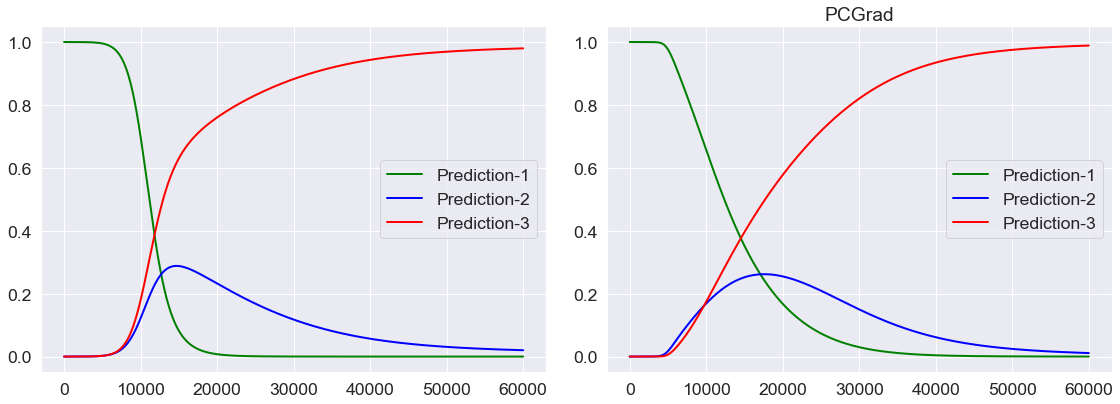

In [25]:
f, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'Prediction-1', color = 'green', linewidth = 2, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'Prediction-2', color = 'blue', linewidth = 2, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'Prediction-3', color = 'red', linewidth = 2, ax=ax[0])

sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'Prediction-1', color = 'green', linewidth = 2, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'Prediction-2', color = 'blue', linewidth = 2, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'Prediction-3', color = 'red', linewidth = 2, ax=ax[1])

ax[1].set_title("PCGrad")

plt.tight_layout()

### Visualize loss function

In [26]:
pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

Text(0, 0.5, 'Loss')

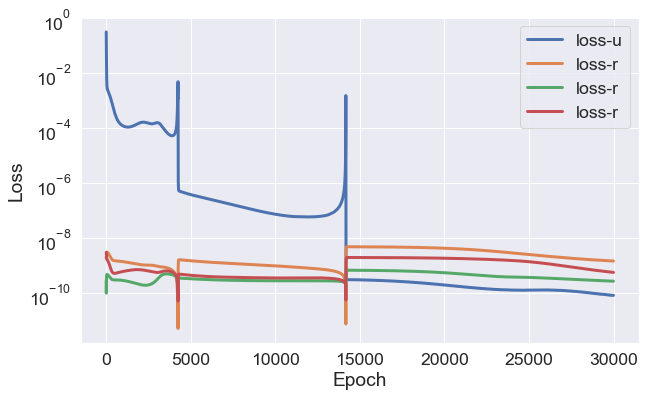

In [27]:
f, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x = range(len(pcgrad_loss_log[:, 0])), y = pcgrad_loss_log[:, 0], linewidth = 3, label='loss-u')
sns.lineplot(x = range(len(pcgrad_loss_log[:, 1])), y = pcgrad_loss_log[:, 1], linewidth = 3, label='loss-r')
sns.lineplot(x = range(len(pcgrad_loss_log[:, 2])), y = pcgrad_loss_log[:, 2], linewidth = 3, label='loss-r')
sns.lineplot(x = range(len(pcgrad_loss_log[:, 3])), y = pcgrad_loss_log[:, 3], linewidth = 3, label='loss-r')

ax.set(yscale="log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

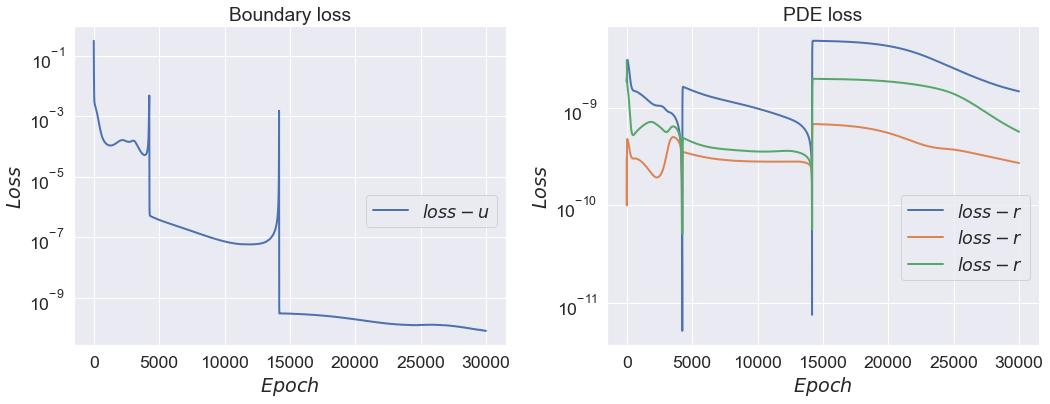

In [28]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x = range(len(pcgrad_loss_log[:, 0])), y = pcgrad_loss_log[:, 0],  linewidth = 2, label = "$loss-u$")
plt.legend(loc='best',bbox_to_anchor=(1,0.5))
plt.title('Boundary loss')
plt.xlabel('$Epoch$')
plt.ylabel('$Loss$')
plt.yscale("log")

plt.subplot(1, 2, 2)
sns.lineplot(x = range(len(pcgrad_loss_log[:, 1])), y = pcgrad_loss_log[:, 1],  linewidth = 2, label = "$loss-r$")
sns.lineplot(x = range(len(pcgrad_loss_log[:, 2])), y = pcgrad_loss_log[:, 2],  linewidth = 2, label = "$loss-r$")
sns.lineplot(x = range(len(pcgrad_loss_log[:, 3])), y = pcgrad_loss_log[:, 3],  linewidth = 2, label = "$loss-r$")
plt.legend(loc='best',bbox_to_anchor=(1,0.5))
plt.title('PDE loss')
plt.xlabel('$Epoch$')
plt.ylabel('$Loss$')
plt.yscale("log")

plt.tight_layout()